# Combined models of violent conflict and natural hazards improve predictions of household mobility in Bangladesh


## -  Main Analysis.

## Import packages

In [1]:
# Type hinting and utility imports
from typing import Any, Dict, List, Union, Optional, Tuple
import pickle # For saving and loading serialized objects
import glob # For file path pattern matching
import os # For operating system interactions

# Data management and manipulation tools
import pandas as pd # Data manipulation with DataFrames
import numpy as np # Numerical computations
import geopandas as gpd # Geographic data processing
import pyreadstat # Read and write SPSS, Stata, and SAS files
import random # Random number generation
from collections import Counter # Counting hashable objects
from itertools import product # Cartesian product of iterables

# Machine learning tools
from sklearn.experimental import enable_iterative_imputer # Enable experimental imputer
from sklearn.impute import IterativeImputer # Multivariate imputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # Random Forest models
from xgboost import XGBClassifier # XGBoost classifier
from sklearn import linear_model # Linear models

# Statsmodels for regressions
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model evaluation metrics and calibration
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, roc_curve, f1_score, recall_score, accuracy_score, precision_score
from sklearn.calibration import CalibratedClassifierCV # For calibrating classifier probabilities
from random import randrange # Random number within a range
import shap # SHAP values for model interpretability

# Visualization tools
import matplotlib as mp # Core matplotlib library
import matplotlib.pyplot as plt # Matplotlib plotting functions
import seaborn as sns # Seaborn data visualization

# Custom functions 
import functions_transforms as fun      
import evaluate_train_combined as fun_analysis
import plotting_functions as fun_plots 

# Utility imports for function operations
import operator  # For functional operations like itemgetter
import json

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-

## Define universal parameters

In [2]:
# Set seed.
random.seed(130822)

In [31]:
# Tune models: Note, set to False for replication.
do_tuning = False
# Train models: Note, set to False to skip re-training the models and work directly with the stored predictions. 
do_training = False

In [4]:
# Define folder structure to store results
base_folder_path = os.path.abspath(os.path.join(os.getcwd(), ".")) # You can also enter the path to your folder manually
#print('Check path:',base_folder_path) # Shows the path you are in

# Define input paths 
input_data_path = os.path.join(base_folder_path,'input_data')
#print('Data will be loaded from:',input_data_path) # Shows the path your data is read from

# Define results path
results_path = os.path.join(base_folder_path,'results')
results_path_ext = os.path.join(results_path, '{sub}')
#print('Results will be stored in:',results_path_ext) # Shows the path your results will be stored in

output_paths = {
    'descriptives': results_path_ext.format(sub=f'descriptives'),
    'models': results_path_ext.format(sub=f'models'),
    'predictions': results_path_ext.format(sub=f'predictions'),
    'features': results_path_ext.format(sub=f'features'),
    'evalscores': results_path_ext.format(sub=f'evalscores'),
    'regression': results_path_ext.format(sub=f'regression'),
    # Sub folders 
    'shapvals': os.path.join(results_path_ext.format(sub=f"features"), "shapvals"), 
}

## Descriptives:

In [5]:
# Load data
df = pd.read_csv(os.path.join(input_data_path,'merged_df_ncc.csv'))
print(df.head())

   mob_asset_value_own  land_size  active_member  \
0              11500.0       67.0            0.0   
1               9630.0       10.0            0.0   
2              18380.0      170.0            1.0   
3              18350.0      144.0            0.0   
4             103020.0      717.0            0.0   

   acled_prrio_count_ts_decay_6_tlag12  gdis_disastertype_landslide_tlag12  \
0                                  1.0                                 0.0   
1                                  1.0                                 0.0   
2                                  1.0                                 0.0   
3                                  1.0                                 0.0   
4                                  1.0                                 0.0   

    ln_loans  deco_best_sb_splag1_msum_12_tlag12  \
0   8.006701                                 0.0   
1   0.000000                                 0.0   
2  10.645449                                 0.0   
3   0.0000

In [6]:
print(df.year.min(),df.year.max())

2011 2018


In [7]:
# TABLE S4 Appendix:
events_per_year = (
    df.groupby('year')[['international_mig', 'internal_mig']]
      .sum()
      .assign(any=lambda d: d['international_mig'] + d['internal_mig'])
).reset_index()

# 
events_per_year['Household Share'] = (events_per_year['any'].div(5503))*100
events_per_year[['international_mig','internal_mig','any']]= events_per_year[['international_mig','internal_mig','any']].astype(int)

# Rename
events_per_year = events_per_year.rename(columns={
    "year": "Year",
    "international_mig": "Households (HH) w. international migration",
    "internal_mig": "HH w. internal migration",
    "any": "HH w. any migration",
    "Household Share": "Share of HH w. any migration"
}).round(2)

# Save tex
tex = events_per_year.to_latex(index=False)
with open(os.path.join(output_paths['descriptives'],
                       f"SI_tabs4_summary_stats_yearly.tex"), "w") as f:
    f.write(tex)

print(f"Wrote scores table to {output_paths['descriptives']}")
print(events_per_year)

Wrote scores table to /Users/maxle647/git_repos/migration_decisions_bangladesh/results/descriptives
   Year  Households (HH) w. international migration  HH w. internal migration  \
0  2011                                          72                       203   
1  2012                                          37                         7   
2  2013                                          50                       120   
3  2014                                          38                       135   
4  2015                                          34                        95   
5  2016                                          82                       386   
6  2017                                          76                       310   
7  2018                                          86                       353   

   HH w. any migration  Share of HH w. any migration  
0                  275                          5.00  
1                   44                          0.80  
2    

In [8]:
# TABLE S5 SI:

# Count households per district
district_counts = df.groupby('District_Name')['both_out'].sum().reset_index()
district_counts = district_counts.rename(columns={'both_out': 'Households'})

# Add percentage
total = district_counts['Households'].sum()
district_counts['Share (%)'] = (district_counts['Households'] / total * 100).round(2)

# Sort for readability (optional)
district_counts = district_counts.sort_values('Households', ascending=False)

# Export LaTeX table
tex = district_counts.to_latex(
    index=False,
    caption="Number and percentage of surveyed households by district.",
    label="tab:district_distribution",
    longtable=False
)

with open(os.path.join(output_paths['descriptives'], "SI_tabs5_district_distribution.tex"), "w") as f:
    f.write(tex)

print(district_counts)


   District_Name  Households  Share (%)
10       Comilla       117.0       5.61
7       Chandpur       102.0       4.89
8     Chittagong        94.0       4.51
60     Sunamganj        93.0       4.46
38    Mymensingh        71.0       3.41
..           ...         ...        ...
54     Rangamati         9.0       0.43
25  Khagrachhari         6.0       0.29
36      Meherpur         4.0       0.19
33        Magura         4.0       0.19
49    Panchagarh         4.0       0.19

[64 rows x 3 columns]


## Define outcome, features and models

In [9]:
# Define outcome
Y_outcome = 'both_out'

In [10]:
# Define features
# Baseline model, features for aspiration + ability

feat_baseline = [
    'head_age',
    'head_sex',
    # education of hh
    'prim_educ',
    'sec_educ',
    'ter_educ',
    'no_educ',
    'religion',
    'ethnicity',
    'head_ocup_agg',
    # Migration history
    'mig_history',
    # Forms of income
    'ln_mob_asset_value_own',
    'ln_savings',
    'ln_loans',
    'ln_land_size',
    'ln_pc_expm',
    'ag_subsidy',
    'ln_livestock_value',
    'sl_benefited',
    'ln_income',
    'ln_remittances_in_value',
    # Additional
    'active_member',
    'active_leader',
    'satisfied_leave',
    'satisfied_life',
    'mobile',
    'radio',
    'tv'
  ]

feat_baseline_district = [
    'nlight_mean',
    'PG_GCP_PPP_LI',
] + feat_baseline

feat_violence_agg = [
    'ged_best_ns_tlag12',
    'ged_best_sb_tlag12',
    'ged_best_osv_tlag12',
    'ged_best_ns_splag1_tlag12',
    'ged_best_sb_splag1_tlag12',
    'ged_best_osv_splag1_tlag12',
    'acled_prrio_count_tlag12',
    'acled_prrio_count_splag1_tlag12',
    'acled_prex_count_tlag12',
    'acled_prex_count_splag1_tlag12',
    'ged_best_ns_ts_decay_6_tlag12',
    'ged_best_osv_ts_decay_6_tlag12',
    'ged_best_sb_ts_decay_6_tlag12',
    'acled_prrio_count_ts_decay_6_tlag12',
    'acled_prrio_count_splag1_ts_decay_6_tlag12',
    'acled_prex_count_ts_decay_6_tlag12',
    'acled_prex_count_splag1_ts_decay_6_tlag12',
]

feat_elect_vio_agg = [
    'deco_best_ns_tlag12',
    'deco_best_sb_tlag12',
    'deco_best_osv_tlag12',
    'deco_best_ns_splag1_tlag12',
    'deco_best_sb_splag1_tlag12',
    'deco_best_osv_splag1_tlag12',
    'deco_best_ns_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
    'deco_best_sb_ts_decay_6_tlag12',
]

feat_disaster_agg = [
    'gdis_n_disasters_tlag12',
    'flood_dummy_ts_decay_6_tlag12',
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'gdis_disastertype_landslide_ts_decay_6_tlag12',
    'gdis_disastertype_storm_ts_decay_6_tlag12',
    'spei_3_severe_ts_decay_6_tlag12'
]

# Main models
feat_district_violence = feat_baseline_district + feat_violence_agg + feat_elect_vio_agg # Includes also deco.
feat_district_disaster = feat_baseline_district + feat_disaster_agg
feat_district_violence_disaster = feat_district_violence + feat_disaster_agg

# Add all the defined feature lists here to check for duplicates.
featurelists = [ 
    feat_baseline_district,
    feat_district_violence,
    feat_district_disaster,
    feat_district_violence_disaster,
]
# Check for duplicates
for ls in featurelists:
    print('has duplicates:',fun.checkIfDuplicates_1(ls))

has duplicates: False
has duplicates: False
has duplicates: False
has duplicates: False


In [11]:
# Define models.

baseline_district  = {
  'model_name': 'baseline_district',
  'cols_features': feat_baseline_district,
  'col_outcome': Y_outcome,
}

district_violence = {
  'model_name': 'district_violence',
  'cols_features': feat_district_violence,
  'col_outcome': Y_outcome,
}


district_disaster = {
  'model_name': 'district_disaster',
  'cols_features': feat_district_disaster,
  'col_outcome': Y_outcome,
}

district_violence_disaster = {
  'model_name': 'district_violence_disaster',
  'cols_features': feat_district_violence_disaster,
  'col_outcome': Y_outcome,
}

# Include all models in list
allmodels = [
    baseline_district,
    district_violence,
    district_disaster,
    district_violence_disaster,
]

for i in allmodels:
    print('Model name:', i['model_name'])

Model name: baseline_district
Model name: district_violence
Model name: district_disaster
Model name: district_violence_disaster


## Aggregation

In [12]:
df = df.set_index(['hh_n','yrmo']).sort_index(level=0)
df

mob_asset_value_own  land_size  active_member  \
hh_n yrmo                                                  
1    1                 11500.0       67.0            0.0   
     2                 11500.0       67.0            0.0   
     3                 11500.0       67.0            0.0   
     4                 11500.0       67.0            0.0   
     5                 11500.0       67.0            0.0   
...                        ...        ...            ...   
6503 92                34650.0       36.0            0.0   
     93                34650.0       36.0            0.0   
     94                34650.0       36.0            0.0   
     95                34650.0       36.0            0.0   
     96                34650.0       36.0            0.0   

           acled_prrio_count_ts_decay_6_tlag12  \
hh_n yrmo                                        
1    1                                1.000000   
     2                                0.890899   
     3                                1.000000   
     4                                1.000000   
     5                                0.890899   
...                                        ...   
6503 92                               0.890899   
     93                               0.793701   
     94                               0.707107   
     95                               1.000000   
     96                               0.890899   

           gdis_disastertype_landslide_tlag12  ln_loans  \
hh_n yrmo                                                 
1    1                                    0.0  8.006701   
     2                                    0.0  8.006701   
     3                                    0.0  8.006701   
     4                                    0.0  8.006701   
     5                                    0.0  8.006701   
...                                       ...       ...   
6503 92                                   0.0  9.210440   
     93                                   0.0  9.210440   
     94                                   0.0  9.210440   
     95                                   0.0  9.210440   
     96                                   0.0  9.210440   

           deco_best_sb_splag1_msum_12_tlag12  flood_dummy_ts_decay_6_tlag12  \
hh_n yrmo                                                                      
1    1                                    0.0                       0.396850   
     2                                    0.0                       0.353553   
     3                                    0.0                       1.000000   
     4                                    0.0                       1.000000   
     5                                    0.0                       0.890899   
...                                       ...                            ...   
6503 92                                   0.0                       1.000000   
     93                                   0.0                       0.890899   
     94                                   0.0                       0.793701   
     95                                   0.0                       0.707107   
     96                                   0.0                       0.629961   

           ged_best_ns_splag1_tlag12  ln_pc_expm  ...  deco_best_osv_tlag12  \
hh_n yrmo                                         ...                         
1    1                           0.0    7.507184  ...                   0.0   
     2                           0.0    7.507184  ...                   0.0   
     3                           0.0    7.507184  ...                   0.0   
     4                           0.0    7.507184  ...                   0.0   
     5                           0.0    7.507184  ...                   0.0   
...                              ...         ...  ...                   ...   
6503 92                          0.0    7.936799  ...                   0.0   
     93                          0.0    7.936799  ...      

In [13]:
df_agg = df.reset_index().groupby(['hh_n','year']).agg(
        {
            # Target
            'both_out':'max',

            # For random/fixed effects - Admin name. 
            'NAME_2':'first',
            'District_Name':'first',
            'Division_Name':'first',

            # Baseline
            'nlight_mean':'mean',
            'PG_GCP_PPP_LI':'mean',
            'head_age':'first',
            'head_sex':'first',
            'prim_educ':'first',
            'sec_educ':'first',
            'ter_educ':'first',
            'no_educ':'first',
            'religion':'first',
            'language':'first',
            'ethnicity':'first',
            'head_ocup_agg':'first',
            'mig_history':'first',
            'ln_mob_asset_value_own':'first',
            'mob_asset_value_own':'first',
            'ln_savings':'first',
            'savings':'first',
            'ln_loans':'first',
            'loans':'first',
            'ln_land_size':'first',
            'land_size':'first',
            'ln_pc_expm':'first',
            'pc_expm':'first',
            'ag_subsidy':'first',
            'ln_livestock_value':'first',
            'livestock_value':'first',
            'sl_benefited':'first',
            'ln_income':'first',
            'income':'first',
            'ln_remittances_in_value':'first',
            'remittances_in_value':'first',
            'active_member':'first',
            'active_leader':'first',
            'satisfied_leave':'first',
            'satisfied_life':'first',
            'mobile':'first',
            'tv':'first',
            'radio':'first',

            # Violence
            'ged_best_ns_tlag12':'sum',
            'ged_best_sb_tlag12':'sum',
            'ged_best_osv_tlag12':'sum',
            'ged_best_ns_splag1_tlag12':'sum',
            'ged_best_sb_splag1_tlag12':'sum',
            'ged_best_osv_splag1_tlag12':'sum',
            'acled_prrio_count_tlag12':'sum',
            'acled_prrio_count_splag1_tlag12':'sum',
            'acled_prex_count_tlag12':'sum',
            'acled_prex_count_splag1_tlag12':'sum',
            'ged_best_ns_msum_12_tlag12':'last',
            'ged_best_osv_msum_12_tlag12':'last',
            'ged_best_sb_msum_12_tlag12':'last',
            'ged_best_ns_splag1_msum_12_tlag12':'last',
            'ged_best_osv_splag1_msum_12_tlag12':'last',
            'ged_best_sb_splag1_msum_12_tlag12':'last',
            'acled_prrio_count_msum_12_tlag12':'last',
            'acled_prrio_count_splag1_msum_12_tlag12':'last',
            'acled_prex_count_msum_12_tlag12':'last',
            'ged_best_ns_ts_decay_6_tlag12':'max',
            'ged_best_osv_ts_decay_6_tlag12':'max',
            'ged_best_sb_ts_decay_6_tlag12':'max',
            'ged_best_ns_splag1_ts_decay_6_tlag12':'max',
            'ged_best_osv_splag1_ts_decay_6_tlag12':'max',
            'ged_best_sb_splag1_ts_decay_6_tlag12':'max',
            'acled_prrio_count_ts_decay_6_tlag12':'max',
            'acled_prrio_count_splag1_ts_decay_6_tlag12':'max',
            'acled_prex_count_ts_decay_6_tlag12':'max',
            'acled_prex_count_splag1_ts_decay_6_tlag12':'max',

            # Disasters.
            'gdis_n_disasters_tlag12':'sum',
            'gdis_disastertype_landslide_msum_12_tlag12':'sum',
            'gdis_disastertype_storm_msum_12_tlag12':'sum',
            'gdis_disastertype_earthquake_msum_12_tlag12':'sum',
            'gdis_disastertype_flood_msum_12_tlag12':'sum',
            'flood_dummy_ts_decay_6_tlag12':'max',
            'gdis_disastertype_flood_ts_decay_6_tlag12':'max',
            'gdis_disastertype_landslide_ts_decay_6_tlag12':'max',
            'gdis_disastertype_storm_ts_decay_6_tlag12':'max',
            'spei_3_severe_ts_decay_6_tlag12':'max',
            'gdis_disastertype_landslide_tlag12':'sum',
            'gdis_disastertype_storm_tlag12':'sum',
            'gdis_disastertype_earthquake_tlag12':'sum',
            'gdis_disastertype_flood_tlag12':'sum',

            # Elect violence.
            'deco_best_ns_tlag12':'sum',
            'deco_best_sb_tlag12':'sum',
            'deco_best_osv_tlag12':'sum',
            'deco_best_ns_splag1_tlag12':'sum',
            'deco_best_sb_splag1_tlag12':'sum',
            'deco_best_osv_splag1_tlag12':'sum',
            'deco_best_ns_msum_12_tlag12':'last',
            'deco_best_osv_msum_12_tlag12':'last',
            'deco_best_sb_msum_12_tlag12':'last',
            'deco_best_ns_splag1_msum_12_tlag12':'last',
            'deco_best_osv_splag1_msum_12_tlag12':'last',
            'deco_best_sb_splag1_msum_12_tlag12':'last',
            'deco_best_ns_ts_decay_6_tlag12':'max',
            'deco_best_osv_ts_decay_6_tlag12':'max',
            'deco_best_sb_ts_decay_6_tlag12':'max',
            'deco_best_ns_splag1_ts_decay_6_tlag12':'max',
            'deco_best_osv_splag1_ts_decay_6_tlag12':'max',
            'deco_best_sb_splag1_ts_decay_6_tlag12':'max',
            })

df_analysis = df_agg # Define aggregate dataframe as dataframe for analysis

In [14]:
# Check years: limit the years (2011 - 2018)
print(df_analysis.index.get_level_values(1).min(),df_analysis.index.get_level_values(1).max())

2011 2018


In [15]:
# TABLE S6-S8 SI:

corrlist = [ 
            feat_baseline_district, #Baseline 
            feat_violence_agg+feat_elect_vio_agg, # Violence
            feat_disaster_agg, # Disaster 
        ]

for feats,fname in zip(corrlist,['baselinedistrict','violence','disasters']):

    descr_vars = feats

    df_descr = df_analysis[descr_vars].describe().round(3).loc[['count','mean','std','min','max']].T
    print(df_descr)
    df_descr.to_csv(os.path.join(output_paths['descriptives'],f'SI_tabs6-s8_summary_stats_{fname}_yragg_preimp.csv'))

    tex = df_descr.reset_index().to_latex(index=False)
    # Get meta infromation
    with open(os.path.join(output_paths['descriptives'],f'SI_tabs6-s8_summary_stats_{fname}_yragg_preimp.tex'), "w") as f:
        f.write(tex)
    print(f"Wrote scores table to {output_paths['descriptives']}")

                           count    mean     std     min      max
nlight_mean              44024.0   6.032   4.266   0.000   44.750
PG_GCP_PPP_LI            44024.0   3.990   2.054   0.347   10.004
head_age                 44024.0  47.399  14.215  17.000  102.000
head_sex                 44024.0   1.185   0.389   1.000    2.000
prim_educ                42967.0   0.259   0.438   0.000    1.000
sec_educ                 42967.0   0.262   0.440   0.000    1.000
ter_educ                 42967.0   0.019   0.138   0.000    1.000
no_educ                  42967.0   0.459   0.498   0.000    1.000
religion                 44024.0   1.111   0.322   1.000    3.000
ethnicity                44024.0   1.006   0.110   1.000    3.000
head_ocup_agg            44024.0   0.389   0.488   0.000    1.000
mig_history              44024.0   0.062   0.241   0.000    1.000
ln_mob_asset_value_own   16509.0   9.924   2.407   0.000   15.281
ln_savings               16509.0   5.300   4.643   0.000   15.607
ln_loans  

In [16]:
# Additional information for TABLE S6 SI:

non_logged_hh = [
    'mob_asset_value_own',
    'savings',
    'loans',
    'land_size',
    'pc_expm',
    'livestock_value',
    'income',
    'remittances_in_value',
]

corrlist = [ 
            non_logged_hh, # Non-logged baseline features 
        ]

for feats,fname in zip(corrlist,['baseline_non_logged']):

    descr_vars = feats

    df_descr = df_analysis[descr_vars].describe().round(3).loc[['count','mean','std','min','max']].T
    print(df_descr)
    df_descr.to_csv(os.path.join(output_paths['descriptives'],f'SI_tabs6_1_summary_stats_{fname}_yragg_preimp.csv'))

    tex = df_descr.reset_index().to_latex(index=False)
    # Get meta infromation
    with open(os.path.join(output_paths['descriptives'],f'SI_tabs6_1_summary_stats_{fname}_yragg_preimp.tex'), "w") as f:
        f.write(tex)
    print(f"Wrote scores table to {output_paths['descriptives']}")

                        count       mean         std     min          max
mob_asset_value_own   16509.0  65907.694  117852.876    0.00  4328400.000
savings               16509.0  23545.126  102246.543    0.00  6000000.000
loans                 16509.0  53033.338  154292.253    0.00  8905000.000
land_size             16509.0     89.062     144.847    0.00     3092.000
pc_expm               26643.0   3449.913    2186.517  545.92    32663.111
livestock_value       33018.0  19370.623   38546.309    0.00  1072000.000
income                16509.0   3295.764   48244.494    0.00  5500000.000
remittances_in_value  26644.0  24436.895   83789.804    0.00  4000000.000
Wrote scores table to /Users/maxle647/git_repos/migration_decisions_bangladesh/results/descriptives


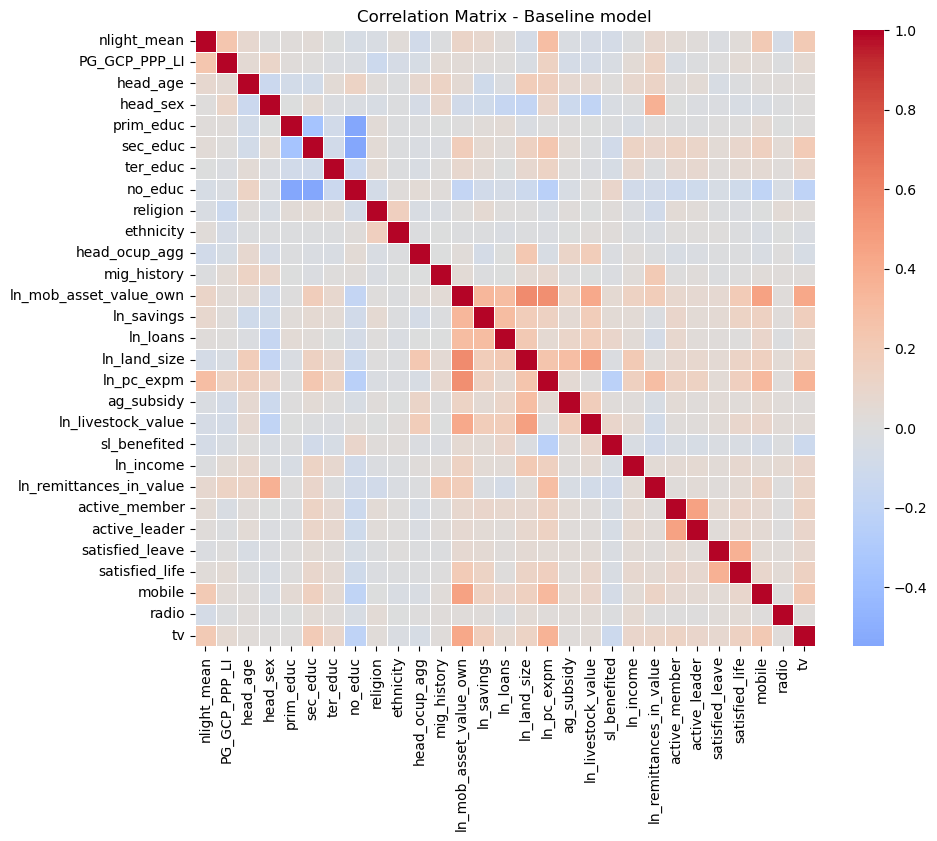

Saved correlation matrix plot for Baseline model


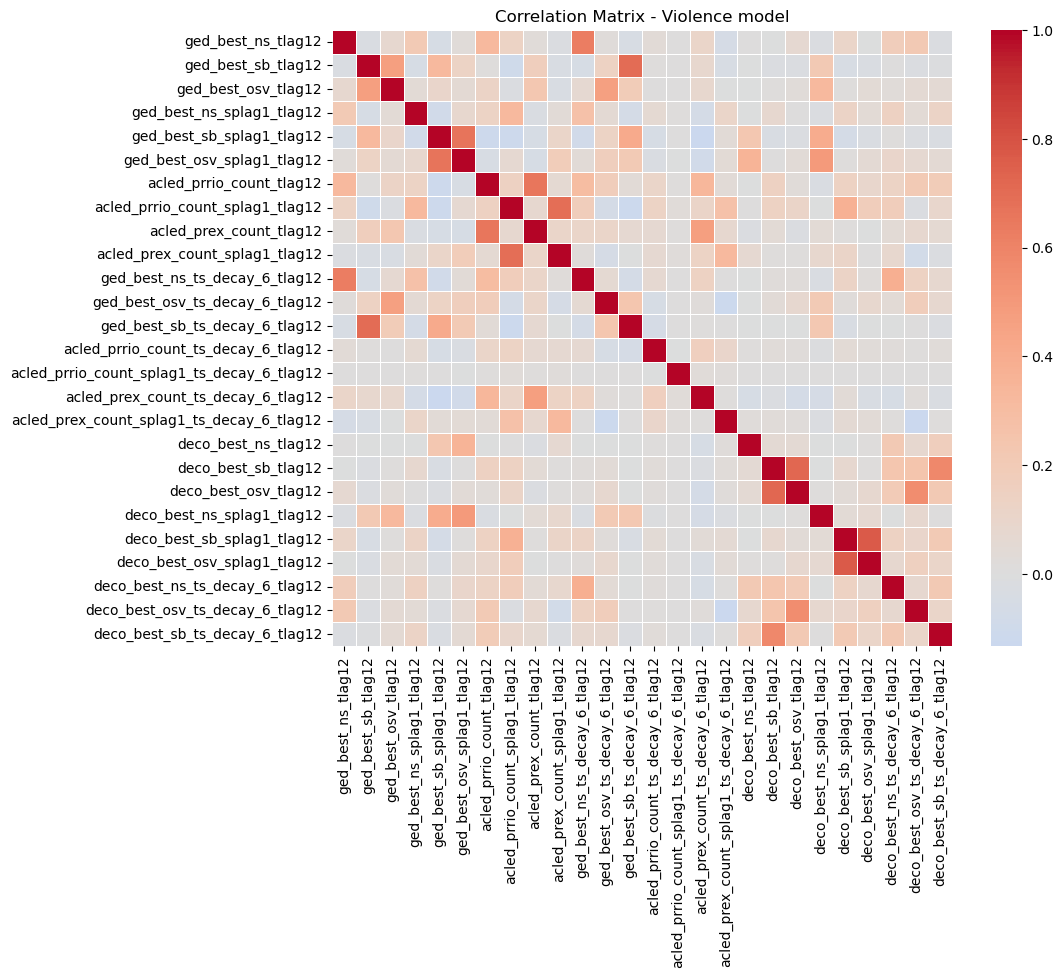

Saved correlation matrix plot for Violence model


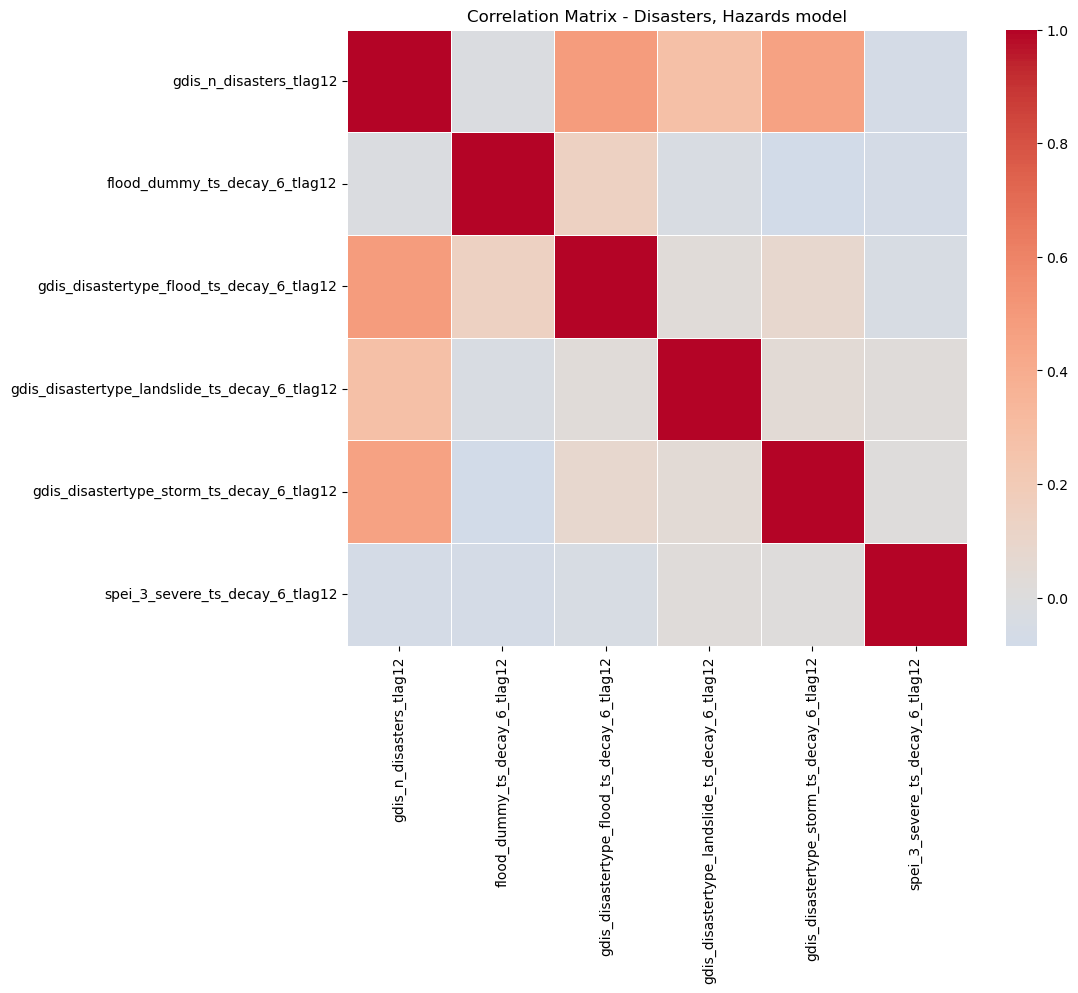

Saved correlation matrix plot for Disasters, Hazards model


In [17]:
# FIGURES S2-4 SI:

corrlist = [ 
            feat_baseline_district, #Baseline 
            feat_violence_agg+feat_elect_vio_agg, # Violence
            feat_disaster_agg, # Disaster 
        ]
for feats, fname in zip(corrlist, ['Baseline model', 'Violence model', 'Disasters, Hazards model']):

    # Compute and plot correlation matrix
    corr_matrix = df_analysis[feats].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm', linewidths=0.5,center=0)
    plt.title(f'Correlation Matrix - {fname}')

    # Save figure
    plt.savefig(os.path.join(output_paths['descriptives'], f'SI_correlation_matrix_{fname}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved correlation matrix plot for {fname}")

In [18]:
# TABLES S9 SI:
# Create a copy with relevant columns
df_violence_exp = df_analysis[[
    'ged_best_ns_tlag12',
    'ged_best_sb_tlag12',
    'ged_best_osv_tlag12',
    'deco_best_ns_tlag12',
    'deco_best_sb_tlag12',
    'deco_best_osv_tlag12',
]].copy()

# Create binary columns for each type of violence exposure
df_violence_exp['violence_ged_ns'] = df_violence_exp['ged_best_ns_tlag12'] > 0
df_violence_exp['violence_ged_sb'] = df_violence_exp['ged_best_sb_tlag12'] > 0
df_violence_exp['violence_ged_osv'] = df_violence_exp['ged_best_osv_tlag12'] > 0
df_violence_exp['violence_deco_ns'] = df_violence_exp['deco_best_ns_tlag12'] > 0
df_violence_exp['violence_deco_sb'] = df_violence_exp['deco_best_sb_tlag12'] > 0
df_violence_exp['violence_deco_osv'] = df_violence_exp['deco_best_osv_tlag12'] > 0

# Create a binary column for any violence exposure
df_violence_exp['any_violence'] = (
    df_violence_exp[['violence_ged_ns', 'violence_ged_sb', 'violence_ged_osv',
                     'violence_deco_ns', 'violence_deco_sb', 'violence_deco_osv']]
    .any(axis=1)
)

# Reset index
df_violence_exp = df_violence_exp.reset_index()

# Get all unique years in the dataset
all_years = pd.DataFrame({'year': df_violence_exp['year'].unique()})

# Group by year and calculate affected households for each type of violence
violence_counts = (
    df_violence_exp
    .groupby('year')
    .agg(
        violence_affected_households=('any_violence', lambda x: x.sum()),
        violence_ged_ns=('violence_ged_ns', lambda x: x.sum()),
        violence_ged_sb=('violence_ged_sb', lambda x: x.sum()),
        violence_ged_osv=('violence_ged_osv', lambda x: x.sum()),
        violence_deco_ns=('violence_deco_ns', lambda x: x.sum()),
        violence_deco_sb=('violence_deco_sb', lambda x: x.sum()),
        violence_deco_osv=('violence_deco_osv', lambda x: x.sum())
    )
    .reset_index()
)

# Merge with all years to include zeros for missing years
affected_hh = pd.merge(all_years, violence_counts, on='year', how='left').fillna(0)

# Convert affected households to integers
affected_hh.iloc[:, 1:] = affected_hh.iloc[:, 1:].astype(int)

# Write to CSV and LaTeX
output_path = output_paths['descriptives']

# Save to CSV
affected_hh.to_csv(os.path.join(output_path, 'SI_tabs9_violence_affected_households.csv'), index=False)

# Save to LaTeX
tex = affected_hh.to_latex(index=False)
with open(os.path.join(output_path, 'SI_tabs9_violence_affected_households.tex'), "w") as f:
    f.write(tex)

print(f"Wrote affected households table to {output_path}")

print(affected_hh)

Wrote affected households table to /Users/maxle647/git_repos/migration_decisions_bangladesh/results/descriptives
   year  violence_affected_households  violence_ged_ns  violence_ged_sb  \
0  2011                           400              280               60   
1  2012                             0                0                0   
2  2013                           320              140                0   
3  2014                          2903             1903                0   
4  2015                           443               40                0   
5  2016                          1143               60               60   
6  2017                          1980                0              520   
7  2018                          1020                0              920   

   violence_ged_osv  violence_deco_ns  violence_deco_sb  violence_deco_osv  
0                60                 0                 0                  0  
1                 0                 0                 0  

In [19]:
# TABLE S10 SI:
df_dis_exp = df_analysis[[
'gdis_disastertype_landslide_tlag12',
'gdis_disastertype_storm_tlag12',
'gdis_disastertype_earthquake_tlag12',
'gdis_disastertype_flood_tlag12',
]].copy()

# Create a binary column for any disaster exposure
df_dis_exp['any_dis'] = (
    df_dis_exp[['gdis_disastertype_landslide_tlag12',
    'gdis_disastertype_storm_tlag12',
    'gdis_disastertype_earthquake_tlag12',
    'gdis_disastertype_flood_tlag12',]]
    .sum(axis=1) > 0
)
df_dis_exp = df_dis_exp.reset_index()

# Get all unique years in the dataset
all_years = pd.DataFrame({'year': df_dis_exp['year'].unique()})

# Group by year for any disaster exposure
affected_hh = (
    df_dis_exp[df_dis_exp['any_dis']]
    .groupby('year')['hh_n']
    .nunique()
    .reset_index(name='disaster_affected_households')
)

# Merge with all years to include years with zero affected households
affected_hh = pd.merge(all_years, affected_hh, on='year', how='left').fillna(0)

# Convert affected households to integers (if needed)
affected_hh['disaster_affected_households'] = affected_hh['disaster_affected_households'].astype(int)

affected_hh

year  disaster_affected_households
0  2011                          1580
1  2012                          2700
2  2013                          2680
3  2014                           460
4  2015                          1600
5  2016                          3623
6  2017                          2940
7  2018                          3620

In [20]:
# TABLE S10 SI:
df_dis_exp = df_analysis[[
    'gdis_disastertype_landslide_tlag12',
    'gdis_disastertype_storm_tlag12',
    'gdis_disastertype_flood_tlag12',
]].copy()

# Create binary columns for each type of disaster exposure
df_dis_exp['dis_landslide'] = df_dis_exp['gdis_disastertype_landslide_tlag12'] > 0
df_dis_exp['dis_storm'] = df_dis_exp['gdis_disastertype_storm_tlag12'] > 0
df_dis_exp['dis_flood'] = df_dis_exp['gdis_disastertype_flood_tlag12'] > 0

# Create a binary column for any disaster exposure
df_dis_exp['any_dis'] = (
    df_dis_exp[['dis_landslide', 'dis_storm', 'dis_flood']].any(axis=1)
)

# Reset index
df_dis_exp = df_dis_exp.reset_index()

# Get all unique years in the dataset
all_years = pd.DataFrame({'year': df_dis_exp['year'].unique()})

# Group by year and calculate affected households for each type of disaster
disaster_counts = (
    df_dis_exp
    .groupby('year')
    .agg(
        disaster_affected_households=('any_dis', lambda x: x.sum()),
        disaster_landslide=('dis_landslide', lambda x: x.sum()),
        disaster_storm=('dis_storm', lambda x: x.sum()),
        disaster_flood=('dis_flood', lambda x: x.sum())
    )
    .reset_index()
)

# Merge with all years to include zeros for missing years
affected_hh = pd.merge(all_years, disaster_counts, on='year', how='left').fillna(0)

# Convert affected households to integers
affected_hh.iloc[:, 1:] = affected_hh.iloc[:, 1:].astype(int)

# Write to CSV and LaTeX
output_path = output_paths['descriptives']

# Save to CSV
affected_hh.to_csv(os.path.join(output_path, 'SI_tabs10_disaster_affected_households.csv'), index=False)

# Save to LaTeX
tex = affected_hh.to_latex(index=False)
with open(os.path.join(output_path, 'SI_tabs_disaster10_affected_households.tex'), "w") as f:
    f.write(tex)

print(f"Wrote disaster affected households table to {output_path}")
print(affected_hh)

Wrote disaster affected households table to /Users/maxle647/git_repos/migration_decisions_bangladesh/results/descriptives
   year  disaster_affected_households  disaster_landslide  disaster_storm  \
0  2011                          1580                 100             840   
1  2012                          2700                 960             840   
2  2013                          2680                   0            2580   
3  2014                           460                   0             460   
4  2015                          1600                   0             700   
5  2016                          2900                 960            1520   
6  2017                          2840                   0            1780   
7  2018                          3620                 300             560   

   disaster_flood  
0             860  
1            1460  
2             820  
3               0  
4            1500  
5            1920  
6            1360  
7            3100  


## Regression

Note that the regression results are included in the SI. 

### Multiple imputation in preparation for estimating regression models

In [21]:
# Numerical features for multiple imputation 
# Step 1
imp_numerical_missing = [
    'ln_mob_asset_value_own',
    'ln_savings',
    'ln_loans',
    'ln_land_size',
    'ln_pc_expm',
    'ln_livestock_value',
    'ln_income',
    'ln_remittances_in_value',
]

imp_numerical_predictors = [
    'nlight_mean', 
    'PG_GCP_PPP_LI',
    'head_age',
    'head_sex',
    'head_ocup_agg',
    'mig_history'
]

# Step 2
# Categorical features 
imp_cat_missing = [
    'prim_educ',
    'sec_educ',
    'ter_educ',
    'no_educ',
    'ag_subsidy',
    'sl_benefited',
    'active_member',
    'active_leader',
    #'satisfied_leave',
    #'satisfied_life',
    'mobile',
    'radio',
    'tv',
] 

imp_cat_predictors = [
    'religion', 
    'ethnicity', 
    'head_ocup_agg', 
    'head_sex',
    'head_ocup_agg',
    'mig_history',
    #'nlight_mean', 
    #'PG_GCP_PPP_LI',
    #'head_age',
]

# Step 3: ordinal variables
imp_ord_missing = [
    'satisfied_leave',
    'satisfied_life',
]

imp_ord_predictors = imp_numerical_missing + imp_numerical_predictors + imp_cat_missing

In [22]:
# Make function for imputation
def apply_imputation(
    imp_estimator, 
    df, 
    miss_vars,
    pred_vars,
    max_value,
    randomstate,

):
    # Initialise the imputer
    imputer_f = IterativeImputer(
        estimator=imp_estimator,
        min_value=0,
        max_value=max_value,
        skip_complete=True,
        max_iter=1500,
        random_state=randomstate,
        verbose=2)

    # 
    df_out = pd.DataFrame(
        imputer_f.fit_transform(df[miss_vars+pred_vars]),
        columns = miss_vars+pred_vars,
        index = df[miss_vars+pred_vars].index
        )
    return df_out[miss_vars]

In [23]:
# Apply to numerical variables
df_analysis_imp = df_analysis.copy()

print('Do numerical')    
imp_num_df = apply_imputation(
    imp_estimator=linear_model.BayesianRidge(), 
    df=df_analysis, 
    miss_vars=imp_numerical_missing,
    pred_vars=imp_numerical_predictors,
    randomstate=1308,
    max_value=None,
)

df_analysis_imp[imp_numerical_missing] = imp_num_df

print('Do categorical')
# Apply to categorical variables 
imp_cat_df = apply_imputation(
    imp_estimator=linear_model.LogisticRegression(max_iter=200),#RandomForestClassifier(random_state=0,n_jobs=-1), 
    df=df_analysis_imp, 
    miss_vars=imp_cat_missing,
    pred_vars=imp_cat_predictors,
    randomstate=1308,
    max_value=1,
)

df_analysis_imp[imp_cat_missing] = imp_cat_df

print('Do ordinal')
# Apply to ordinal variable
imp_ord_df = apply_imputation(
    imp_estimator=linear_model.BayesianRidge(), 
    df=df_analysis_imp, 
    miss_vars=imp_ord_missing,
    pred_vars=imp_ord_predictors,
    randomstate=1308,
    max_value=10,
)

df_analysis_imp[imp_ord_missing] = imp_ord_df.round()

Do numerical
[IterativeImputer] Completing matrix with shape (44024, 14)
[IterativeImputer] Ending imputation round 1/1500, elapsed time 0.17
[IterativeImputer] Change: 16.238888474748222, scaled tolerance: 0.10200000000000001 
[IterativeImputer] Ending imputation round 2/1500, elapsed time 0.30
[IterativeImputer] Change: 8.146985388160791, scaled tolerance: 0.10200000000000001 
[IterativeImputer] Ending imputation round 3/1500, elapsed time 0.41
[IterativeImputer] Change: 2.0965656991410953, scaled tolerance: 0.10200000000000001 
[IterativeImputer] Ending imputation round 4/1500, elapsed time 0.51
[IterativeImputer] Change: 0.7470472734982234, scaled tolerance: 0.10200000000000001 
[IterativeImputer] Ending imputation round 5/1500, elapsed time 0.60
[IterativeImputer] Change: 0.5735511435757452, scaled tolerance: 0.10200000000000001 
[IterativeImputer] Ending imputation round 6/1500, elapsed time 0.70
[IterativeImputer] Change: 0.4406909356819324, scaled tolerance: 0.10200000000000001

In [24]:
# Hot encode some of the categorical variables 
# Recode the variable for sex
df_analysis_imp['head_sex'] = df_analysis_imp['head_sex'].replace({1: 0, 2: 1})

make_dummies = [
    'religion',
    'ethnicity',
]

dummies_rel = pd.get_dummies(df_analysis_imp['religion'], prefix='religion')
dummies_ethn = pd.get_dummies(df_analysis_imp['ethnicity'], prefix='ethnicity')

dummies_df = dummies_rel.join(dummies_ethn,how='left')
df_analysis_imp = df_analysis_imp.join(dummies_df,how='left')

In [25]:
# Adjust features due to multicolinearity
dict_baseline_district_reg = {
    'nlight_mean': 'Nightlight',
    'PG_GCP_PPP_LI': 'GCP',
    'head_age': 'Head age of hh',
    'head_sex': 'Head sex of hh',
    'prim_educ': 'Primary education',
    'sec_educ': 'Secondary education',
    'ter_educ': 'Tertiary education',
    'religion_2.0': 'Hindu', 
    'religion_3.0': 'Christian',
    'ethnicity_2.0': 'Bihari',
    'ethnicity_3.0': 'Tribal',
    'head_ocup_agg': 'Head occupation of hh',
    'mig_history': 'Migration history',
    'ln_savings': 'Ln (savings)',
    'ln_loans': 'Ln (loans)',
    'ln_mob_asset_value_own':'Ln (mobile asset value)',
    'ag_subsidy':'Agricultural subsidies',
    'sl_benefited': 'Safety net program',
    'ln_income': 'Ln (income)',
    'ln_remittances_in_value': 'Ln (received remittances)',
    'active_member': 'Active member',
    'active_leader': 'Active leader',
    'satisfied_leave':'Satisfied with alt places',
    'satisfied_life': 'Satisfied with life',
    'mobile':'Mobile',
    'radio':'Radio',
    'tv':'TV',
}

# Add violence to baseline
dict_bl_vioged_reg = {
    'ged_best_ns_tlag12':'Count NS violence (t-12)',
    'ged_best_sb_tlag12':'Count SB violence (t-12)',
    'ged_best_osv_tlag12':'Count OSV violence (t-12)',
}
dict_bl_vioged_reg.update(dict_baseline_district_reg)

dict_bl_vioged_decay_reg = {
    'ged_best_ns_ts_decay_6_tlag12':'NS decay (t-12)',
    'ged_best_osv_ts_decay_6_tlag12':'OSV decay (t-12)',
    'ged_best_sb_ts_decay_6_tlag12':'SB decay (t-12)',
}
dict_bl_vioged_decay_reg.update(dict_baseline_district_reg)

dict_bl_viodeco_reg = {
    'deco_best_ns_tlag12':'NS electoral violence (t-12)',
    'deco_best_sb_tlag12':'SB electoral violence (t-12)',
    'deco_best_osv_tlag12':'OSV electoral violence (t-12)',
}
dict_bl_viodeco_reg.update(dict_baseline_district_reg)

dict_bl_viodeco_decay_reg = {
    'deco_best_ns_ts_decay_6_tlag12':'NS electoral violence decay (t-12)',
    'deco_best_osv_ts_decay_6_tlag12':'OSV electoral violence decay (t-12)',
    'deco_best_sb_ts_decay_6_tlag12':'SB electoral violence decay (t-12)',
}
dict_bl_viodeco_decay_reg.update(dict_baseline_district_reg)

dict_bl_spei_reg = {
    'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months decay (t-12)'
}
dict_bl_spei_reg.update(dict_baseline_district_reg)

dict_all_gdis_reg = {
    'gdis_disastertype_flood_ts_decay_6_tlag12':'Flood decay (t-12)',
    'gdis_disastertype_landslide_ts_decay_6_tlag12':'Landslide decay (t-12)',
    'gdis_disastertype_storm_ts_decay_6_tlag12':'Storm decay (t-12)',
    'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months  decay (t-12)',
}
dict_all_gdis_reg.update(dict_baseline_district_reg)


dict_all_gdis_and_vio_reg = {
    'gdis_disastertype_flood_ts_decay_6_tlag12':'Flood decay (t-12)',
    'gdis_disastertype_landslide_ts_decay_6_tlag12':'Landslide decay (t-12)',
    'gdis_disastertype_storm_ts_decay_6_tlag12':'Storm decay (t-12)',
    'spei_3_severe_ts_decay_6_tlag12':'SPEI over 3 months  decay (t-12)',
    'deco_best_ns_ts_decay_6_tlag12':'NS electoral violence decay (t-12)',
    'deco_best_osv_ts_decay_6_tlag12':'OSV electoral violence decay (t-12)',
    'deco_best_sb_ts_decay_6_tlag12':'SB electoral violence decay (t-12)',
}
dict_all_gdis_and_vio_reg.update(dict_baseline_district_reg)



regmodels = [
    dict_bl_vioged_reg,
    dict_bl_vioged_decay_reg,
    dict_bl_viodeco_reg,
    dict_bl_viodeco_decay_reg,
    dict_bl_spei_reg,
    dict_all_gdis_reg,
    dict_all_gdis_and_vio_reg,
]

/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    both_out 
No. Observations:      44024      Method:                REML     
No. Groups:            64         Scale:                 0.0422   
Min. group size:       160        Log-Likelihood:        6990.9831
Max. group size:       2080       Converged:             Yes      
Mean group size:       687.9                                      
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
ged_best_ns_tlag12      -0.004    0.002 -2.290 0.022 -0.007 -0.001
ged_best_sb_tlag12       0.001    0.001  0.999 0.318 -0.001  0.002
ged_best_osv_tlag12      0.001    0.001  0.686 0.493 -0.002  0.004
nlight_mean              0.001    0.000  3.926 0.000  0.001  0.002
PG_GCP_PPP_LI           -0.001    0.001 -1.373 0.170 -0.003  0.001
head_age  

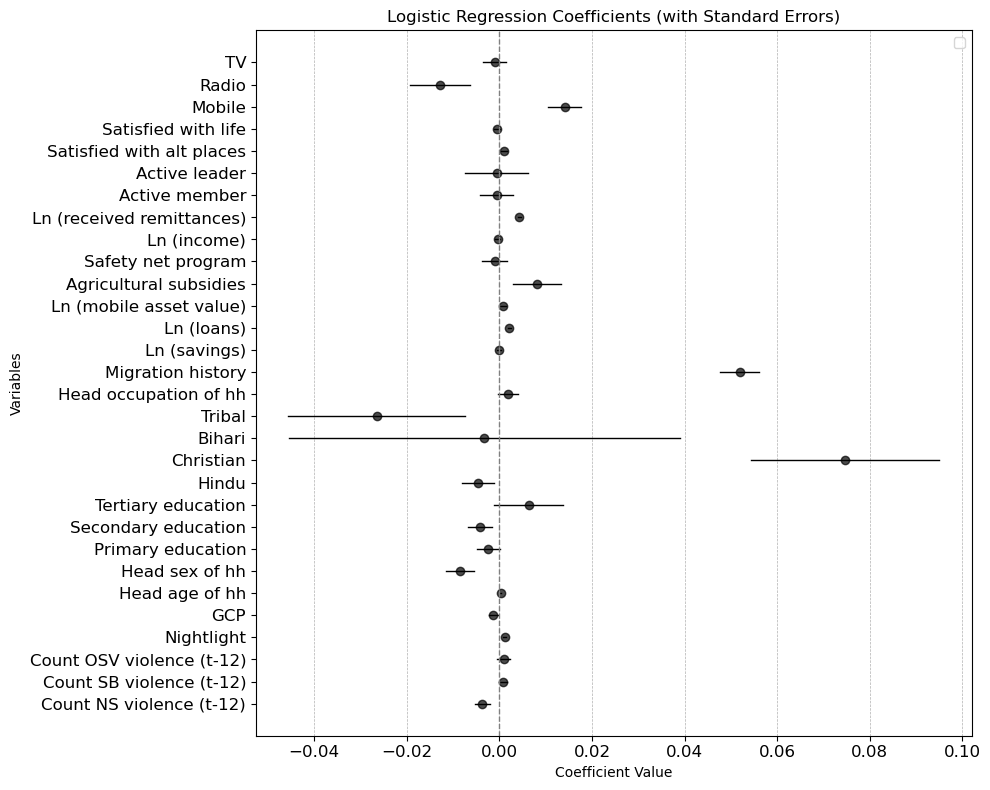

Logit dict_bl_vioged_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.543
  AUROC:                 0.683
  Average Precision (AP): 0.086


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       both_out 
No. Observations:       44024         Method:                   REML     
No. Groups:             64            Scale:                    0.0422   
Min. group size:        160           Log-Likelihood:           7008.3053
Max. group size:        2080          Converged:                Yes      
Mean group size:        687.9                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
ged_best_ns_ts_decay_6_tlag12  -0.022    0.004 -5.321 0.000 -0.031 -0.014
ged_best_osv_ts_decay_6_tlag12  0.011    0.005  2.126 0.034  0.001  0.022
ged_best_sb_ts_decay_6_tlag12  -0.001    0.006 -0.101 0.920 -0.012  0.011
nlight_mean                     0.001    0.000  4.019 0.

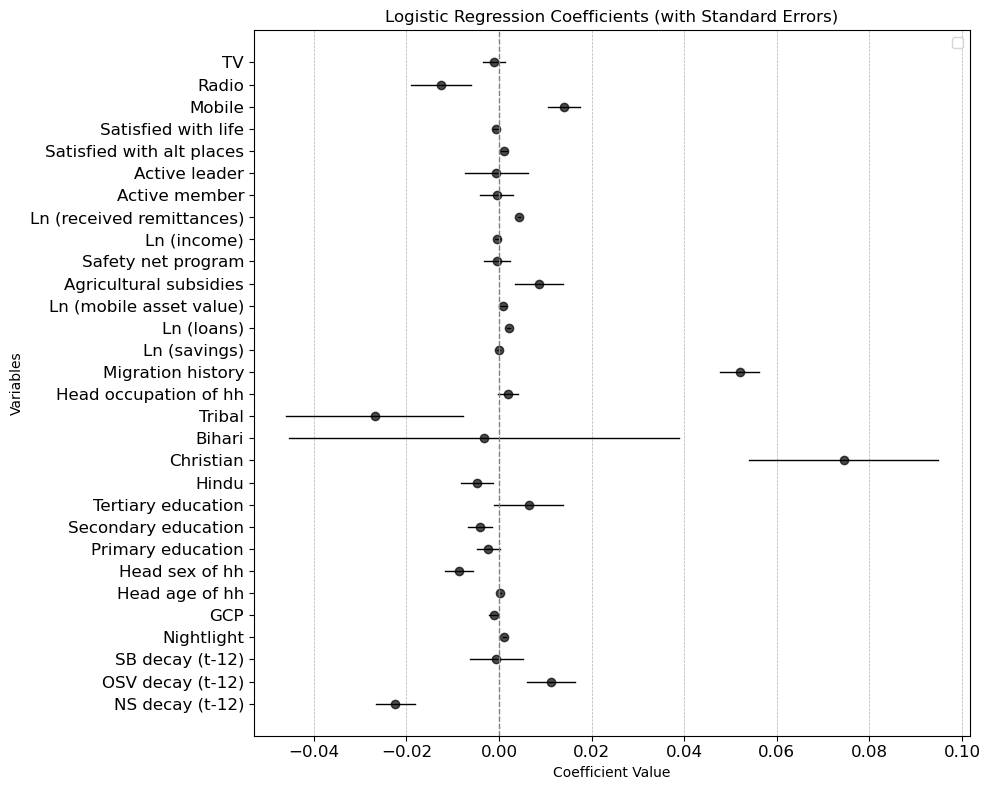

Logit dict_bl_vioged_decay_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.544
  AUROC:                 0.686
  Average Precision (AP): 0.087


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    both_out 
No. Observations:      44024      Method:                REML     
No. Groups:            64         Scale:                 0.0422   
Min. group size:       160        Log-Likelihood:        6991.5579
Max. group size:       2080       Converged:             Yes      
Mean group size:       687.9                                      
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
deco_best_ns_tlag12     -0.000    0.000 -1.377 0.169 -0.001  0.000
deco_best_sb_tlag12     -0.005    0.002 -3.200 0.001 -0.008 -0.002
deco_best_osv_tlag12     0.004    0.001  2.876 0.004  0.001  0.006
nlight_mean              0.001    0.000  4.048 0.000  0.001  0.002
PG_GCP_PPP_LI           -0.001    0.001 -1.143 0.253 -0.003  0.001
head_age  

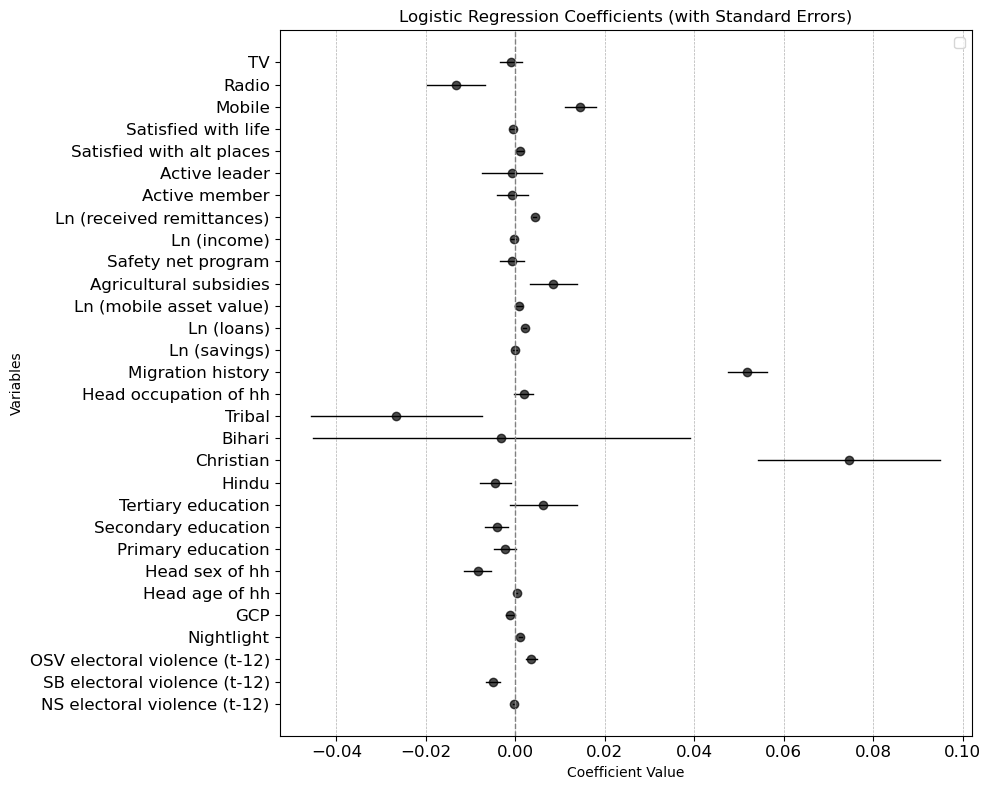

Logit dict_bl_viodeco_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.542
  AUROC:                 0.682
  Average Precision (AP): 0.087


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       both_out 
No. Observations:        44024         Method:                   REML     
No. Groups:              64            Scale:                    0.0422   
Min. group size:         160           Log-Likelihood:           6999.6684
Max. group size:         2080          Converged:                Yes      
Mean group size:         687.9                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
deco_best_ns_ts_decay_6_tlag12   0.014    0.005  2.859 0.004  0.004  0.023
deco_best_osv_ts_decay_6_tlag12  0.003    0.006  0.437 0.662 -0.009  0.014
deco_best_sb_ts_decay_6_tlag12  -0.017    0.005 -3.370 0.001 -0.026 -0.007
nlight_mean                      0.001    0.

/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


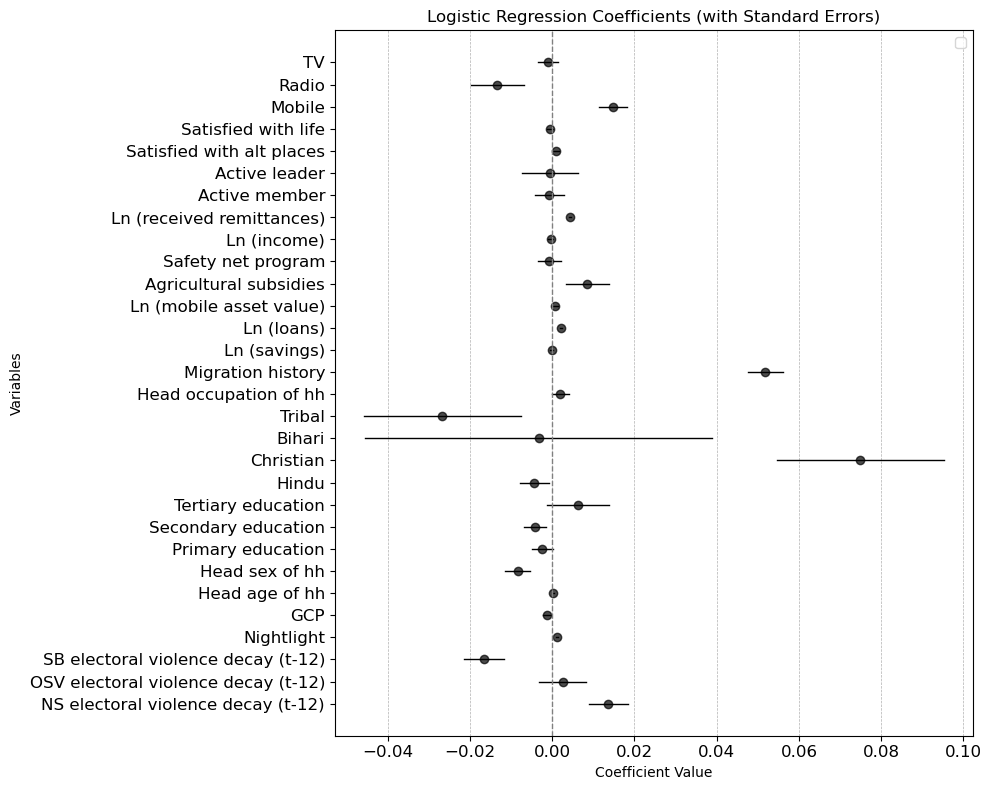

Logit dict_bl_viodeco_decay_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.543
  AUROC:                 0.678
  Average Precision (AP): 0.087


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       both_out 
No. Observations:        44024         Method:                   REML     
No. Groups:              64            Scale:                    0.0422   
Min. group size:         160           Log-Likelihood:           7011.0386
Max. group size:         2080          Converged:                Yes      
Mean group size:         687.9                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
spei_3_severe_ts_decay_6_tlag12 -0.012    0.002 -4.837 0.000 -0.016 -0.007
nlight_mean                      0.001    0.000  3.846 0.000  0.001  0.002
PG_GCP_PPP_LI                   -0.001    0.001 -0.897 0.370 -0.003  0.001
head_age                         0.000    0.

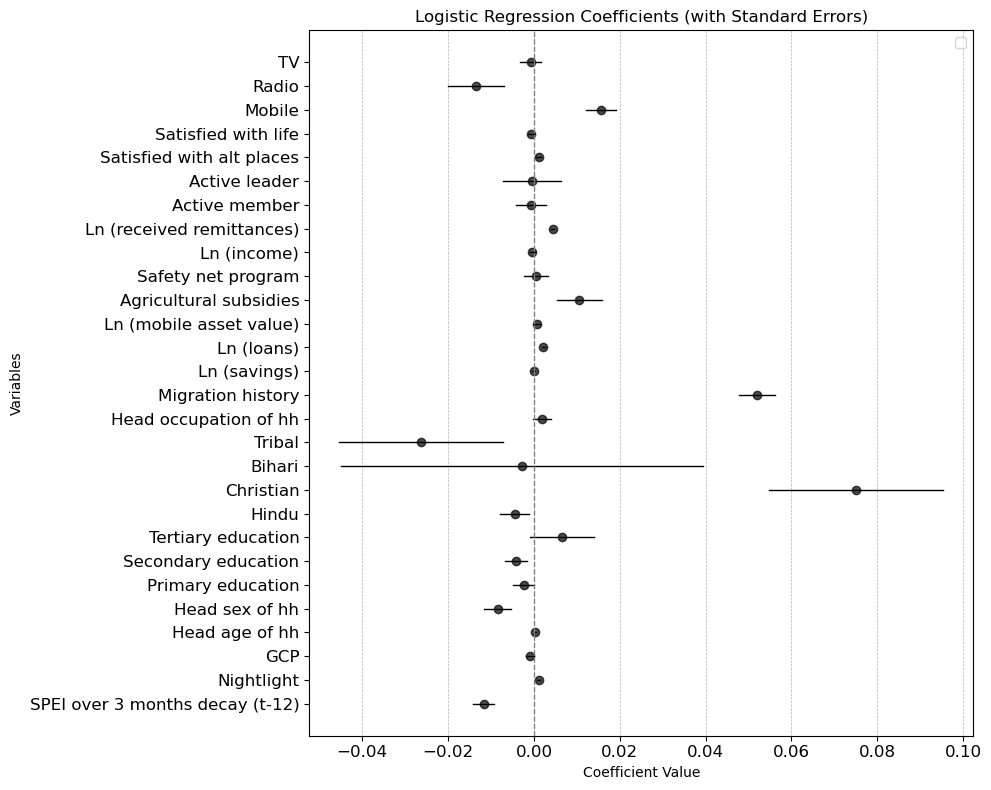

Logit dict_bl_spei_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.544
  AUROC:                 0.681
  Average Precision (AP): 0.088


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsm

                         Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            both_out 
No. Observations:            44024              Method:                        REML     
No. Groups:                  64                 Scale:                         0.0420   
Min. group size:             160                Log-Likelihood:                7002.8741
Max. group size:             2080               Converged:                     No       
Mean group size:             687.9                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
gdis_disastertype_flood_ts_decay_6_tlag12      0.027    0.003  9.188 0.000  0.021  0.032
gdis_disastertype_landslide_ts_decay_6_tlag12  

/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


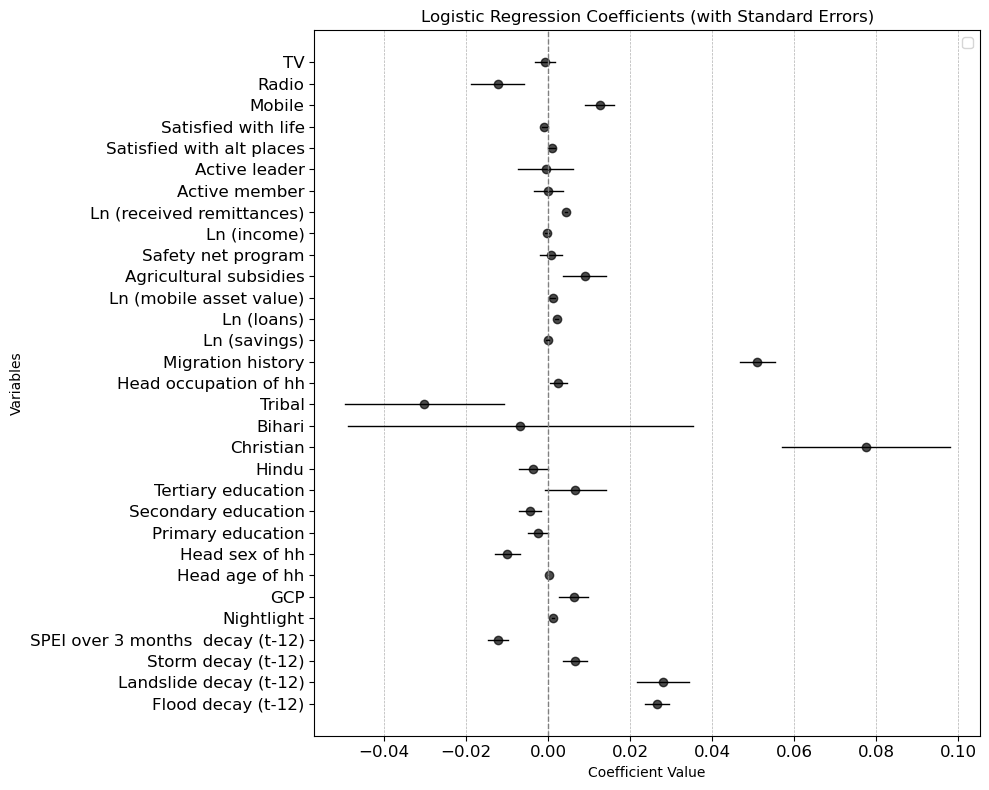

Logit dict_all_gdis_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.548
  AUROC:                 0.683
  Average Precision (AP): 0.091


/Users/maxle647/miniconda3/envs/ccm_bangladesh/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2127885762.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


                         Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            both_out 
No. Observations:            44024              Method:                        REML     
No. Groups:                  64                 Scale:                         0.0421   
Min. group size:             160                Log-Likelihood:                7062.3427
Max. group size:             2080               Converged:                     Yes      
Mean group size:             687.9                                                      
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
gdis_disastertype_flood_ts_decay_6_tlag12      0.025    0.003  9.147 0.000  0.020  0.031
gdis_disastertype_landslide_ts_decay_6_tlag12  

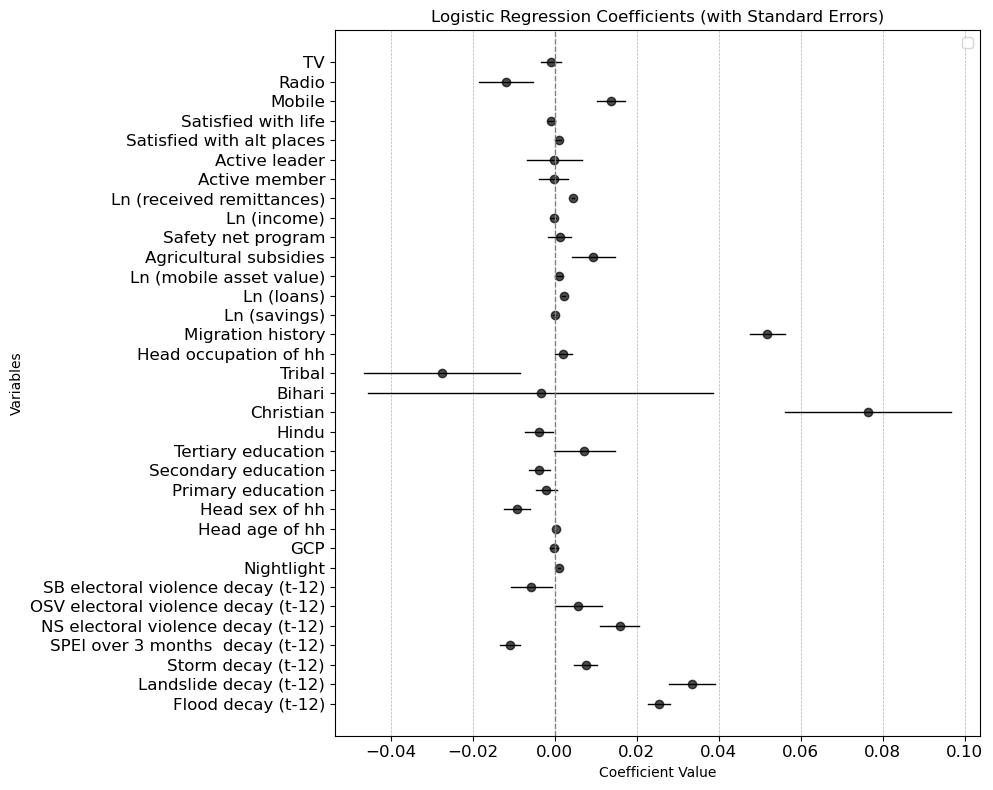

Logit dict_all_gdis_and_vio_reg performance:
  Macro F1 (0.5):        0.488
  Macro F1 (0.1):        0.550
  AUROC:                 0.698
  Average Precision (AP): 0.096


In [26]:
for m,name in zip(regmodels,[
    'dict_bl_vioged_reg',
    'dict_bl_vioged_decay_reg',
    'dict_bl_viodeco_reg',
    'dict_bl_viodeco_decay_reg',
    'dict_bl_spei_reg',
    'dict_all_gdis_reg',
    'dict_all_gdis_and_vio_reg',
]):
    iv_list = list(m.keys())
    X_reg = df_analysis_imp[iv_list].astype(float) 
    X_reg = sm.add_constant(X_reg, prepend=False) 

    # Mixed effects model
    m1_mfe_re = sm.MixedLM(endog=df_analysis_imp[Y_outcome], exog=X_reg, groups=df_analysis_imp['NAME_2'])
    m1_mfe_re.family = sm.families.Binomial()
    res_m1_mfe_re = m1_mfe_re.fit()

    # Print a summary of the logistic regression results
    print(res_m1_mfe_re.summary())

    # Get the coefficients and their standard errors from the results
    coefficients = res_m1_mfe_re.params
    coefficients = coefficients.drop(['const','Group Var'])
    std_errors = res_m1_mfe_re.bse
    std_errors = std_errors.drop(['const','Group Var'])
    coefficients = coefficients.rename(index=m)

    # Create a scatter plot of coefficients
    plt.figure(figsize=(10, 8))
    plt.scatter(coefficients, coefficients.index, c='black', marker='o', alpha=0.7)

    # Add vertical lines to represent standard errors
    for var, coef, se in zip(coefficients.index, coefficients, std_errors):
        plt.plot([coef - se, coef + se], [var, var], color='black', linestyle='-', linewidth=1)

    # Customize the plot
    plt.title('Logistic Regression Coefficients (with Standard Errors)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variables')
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  

    # Add a vertical line at 0
    plt.axvline(0, color='grey', linestyle='--', linewidth=1)

    # Display the plot
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_paths['regression'],f'SI_figs14-s15_regmod_{name}.png'))
    plt.show()
    plt.close()


    # --- NEW: Predictions & metrics ---
    y_prob = res_m1_mfe_re.predict(X_reg)  # predicted probabilities
    y_true = df_analysis_imp[Y_outcome]

    # Thresholded predictions
    y_pred_05 = (y_prob >= 0.5).astype(int)
    y_pred_01 = (y_prob >= 0.1).astype(int)

    # Precision, recall, accuracy at 0.5
    precision_05 = precision_score(y_true, y_pred_05, zero_division=0)
    recall_05 = recall_score(y_true, y_pred_05, zero_division=0)
    accuracy_05 = accuracy_score(y_true, y_pred_05)

    # F1 scores
    f1_macro_05 = f1_score(y_true, y_pred_05, average="macro", zero_division=0)
    f1_macro_01 = f1_score(y_true, y_pred_01, average="macro", zero_division=0)
    f1_weighted_05 = f1_score(y_true, y_pred_05, average="weighted", zero_division=0)

    # Threshold-free metrics
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    print(f"Logit {name} performance:")
    print(f"  Macro F1 (0.5):        {f1_macro_05:.3f}")
    print(f"  Macro F1 (0.1):        {f1_macro_01:.3f}")
    print(f"  AUROC:                 {auc:.3f}")
    print(f"  Average Precision (AP): {ap:.3f}")

## Tuning of ML models

Implemented to avoid over-fitting by finding optimal numbers of trees.

In [27]:
for m in allmodels:
    print(m['model_name'])

baseline_district
district_violence
district_disaster
district_violence_disaster


In [28]:
if do_tuning:
    # Note each model needs to be tuned seperately, therefore change the model name.
    model_early_stopping = district_violence_disaster 
    
    # Define parameters.
    random_state= 1308

    ############### Imputation
    new_imp = True
    model_to_impute = baseline_district
    imp_max_iter = 50

    ############### Sampling # Set to false if not implemented
    oversampling = False 
    o_sampling_strategy='minority'

    ###############  Tuning

    n_rep = 5
    early_stopping_rounds = 25  # stop if no improvement after 200 rounds
    rounds_boosting = 250
    
    ############## Hyper parameters 
    
    parm_1,parm_2 = 'max_depth','learning_rate'

    # Range of hyperparameters to tune. 
    max_depths = list(range(2,7,1)) # change to 8 for other models
    learning_rates = list(np.logspace(-3, -1, 5))
    
    full_dict = {
        parm_1:max_depths,
        parm_2:learning_rates,
    }
    
    keys, values = zip(*full_dict.items())
    full_search_dict = [dict(zip(keys, p)) for p in product(*values)]
    
    print(full_search_dict)

In [29]:
if do_tuning:
    
    master_cv = fun_analysis.cross_validation_split(df_analysis[model_early_stopping['col_outcome']],n_rep=n_rep,set_seed=1308)
    
    # Cv and get best params
    current_params, results_df = fun_analysis.cv_over_param_dict(
        df=df_analysis, 
        param_dict=full_search_dict, 
        parm_1=parm_1,
        parm_2=parm_2,
        model_early_stopping=model_early_stopping, 
        cv_folds=master_cv, 
        rounds_boosting=rounds_boosting, 
        early_stopping_rounds=early_stopping_rounds,
        evalmetricstr='aucpr',
        evalmetric = average_precision_score,
        random_state=random_state,
        new_imp=new_imp,
        model_to_impute = model_to_impute,
        imp_max_iter = imp_max_iter,
        oversampling = oversampling,
        o_sampling_strategy = o_sampling_strategy,
        output_paths=output_paths,
    )

In [30]:
if do_tuning:
    # Print results
    print(results_df)

## Train models and make predictions

In [32]:
if do_training:
    for m in allmodels:
        print(m['model_name'],len(m['cols_features']))

Note, this part needs to be run mutliple times to get all the results. 

- First, run with do_shapvals and do_shapinter set to "False" (runs all models with 250 repetitions). 
- Second, run with do_shapvals set to "True" and do_shapinter set to "False" (runs all models with 100 repetitions).
- Third, run with do_shapvals set to "False" and do_shapinter set to "True" (runs only the full model with 100 repetitions).

In [33]:
if do_training:
    
    do_shapvals = False 
    do_shapinter = False
    
    if do_shapvals:
        n_reps = 100
        run_models = allmodels
    elif do_shapinter: 
        n_reps = 100
        run_models = [district_violence_disaster]   
    else:
        n_reps = 250
        run_models = allmodels
    
    print('Running, number of repetitions =', n_reps)
    print('Running, number of models =', len(run_models))

In [34]:
if do_training:
    # Add tuned parameters to dictionary
    baseline_district['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2, 
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2, 
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_disaster['estimator'] = XGBClassifier(
        n_estimators=250, 
        max_depth=2,
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence_disaster['estimator'] = XGBClassifier(
        n_estimators=250,
        max_depth=3,
        learning_rate=0.03162,
        n_jobs=14,
    )
    district_violence_disaster_rob['estimator'] = XGBClassifier(
        n_estimators=250,
        max_depth=3,
        learning_rate=0.03162,
        n_jobs=14,
    )

In [35]:
# Define which models should be trained.
if do_training:
    print('Models to run:')
    for mod in run_models:
        print(mod['model_name'])

In [36]:
################## DO NOT CHANGE THESE PARAMETERS ################## 
esttype ='xgb' 
model_to_impute = baseline_district
imp_iter = 50

# Sampling
sampling = 'none' # Choices: 'none','under','over'
share_neg = 0.1 # Only applies if choice is not 'none'
osampling_strategy = 'minority' # Only applies if choice is not 'none'

# Imputation
impute_data = True
do_perm_imp = False # Permuted feature importance

In [37]:
if do_training:
    # Numerical features for multiple imputation 
    # Step 1
    imp_numerical_missing = [
        'ln_mob_asset_value_own',
        'ln_savings',
        'ln_loans',
        'ln_land_size',
        'ln_pc_expm',
        'ln_livestock_value',
        'ln_income',
        'ln_remittances_in_value',
    ]

    imp_numerical_predictors = [
        'nlight_mean', 
        'PG_GCP_PPP_LI',
        'head_age',
        'head_sex',
        'head_ocup_agg',
        'mig_history'
    ]

    # Step 2
    # Categorical features 
    imp_cat_missing = [
        'prim_educ',
        'sec_educ',
        'ter_educ',
        'no_educ',
        'ag_subsidy',
        'sl_benefited',
        'active_member',
        'active_leader',
        'mobile',
        'radio',
        'tv',
    ] 

    imp_cat_predictors = [
        'religion', 
        'ethnicity', 
        'head_ocup_agg', 
        'head_sex',
        'head_ocup_agg',
        'mig_history',
    ]

    # Step 3: ordinal variables
    imp_ord_missing = [
        'satisfied_leave',
        'satisfied_life',
    ]

    imp_ord_predictors = imp_numerical_missing + imp_numerical_predictors + imp_cat_missing

In [38]:
# Parameters 
if do_training:
    
    # Define empty dictonaries and lists to store results
    
    # Eval scores
    scores_dict = {}
    
    modelobjdict = {}
    shapvalsdict = {}
    shapinterdict = {}
    train_outdict = {}
    permimpsdict = {}
    auc_pr_cruve_dict={}
    preds_dict={}

    for mod in run_models:

        scores_dict[mod['model_name']] = {
            'auroc_mean':[],
            'auroc_sd':[],
            'ap_mean':[],
            'ap_sd':[],
            'ap_max':[],
            'auroc_max':[]
        }
        
        auc_pr_cruve_dict[mod['model_name']] = {
            'fprdict_auc':[],
            'tprdict_auc':[],
            'dict_precision':[],
            'dict_recall':[],
        }
        
        preds_dict[mod['model_name']] = {
            'preds': [],
            'actuals': [],
        }
            
    # Iterate through models:
    for mod in run_models:
        
        print('###############', mod['model_name'])

        # First split data into k folds:
        print('Creating folds')
        kfolds = fun_analysis.cross_validation_split(df_analysis,n_rep=n_reps,set_seed=1308)

        # Iterate through folds
        fpr_dict_auc,tpr_dict_auc,prec_dict,recall_dict = {},{},{},{}
        modelobj = {}
        shapvals = {}
        shapinters = {}
        train_out_df = {}
        permimps = {}
        ls_ap_scores = []
        ls_auroc_scores = []
        ls_preds = []
        ls_actuals = []
        
        
        for k in range(0,n_reps):
            
            print('Fold',k+1)
                
            if do_perm_imp == True:
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, 
                recall, thresh_pr, fitted_model, perm_imp = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis_imp,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = False, 
                    shap_val_inter = False,
                    perm_importance = True,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                print(ap)
                print(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                permimps[k] = perm_imp
                
            elif do_shapvals == True:
                
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model, shap_values, train_x_out = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = True, 
                    shap_val_inter = False,
                    perm_importance = False,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                shapvals[k] = shap_values
                train_out_df[k] = train_x_out
                
            elif do_shapinter == True:

                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model, shap_values, shap_inters, train_x_out = fun_analysis.split_train_test_eval(
                    test_indx = kfolds[k],
                    df=df_analysis,
                    cols_X = mod['cols_features'],
                    col_Y = mod['col_outcome'],
                    modelname = mod['model_name'],
                    esttype=esttype,
                    fold=k,
                    model_to_impute = model_to_impute,
                    imp_iter=imp_iter,
                    sampling=sampling,
                    osampling_strategy=osampling_strategy,
                    imputation=['numerical','categorical','ordinal'],
                    imp_numerical_missing =imp_numerical_missing,
                    imp_numerical_predictors =imp_numerical_predictors,
                    imp_ordinal_missing =imp_ord_missing,
                    imp_ordinal_predictors =imp_ord_predictors,
                    imp_categorical_missing =imp_cat_missing,
                    imp_categorical_predictors =imp_cat_predictors,
                    share_neg=share_neg,
                    estimator= mod['estimator'],
                    calibration=False,
                    method_calib='isotonic',
                    shap_val = False, 
                    shap_val_inter = True,
                    perm_importance = False,
                )

                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
                shapvals[k] = shap_values
                shapinters[k] = shap_inters
                train_out_df[k] = train_x_out
                
            else:
                print('Run models without shaps.')
                predicted_y, true_y, auc, ap, fpr_roc, tpr_roc, thresh_roc, precision, recall, thresh_pr, fitted_model = fun_analysis.split_train_test_eval(
                        test_indx = kfolds[k],
                        df=df_analysis,
                        cols_X = mod['cols_features'],
                        col_Y = mod['col_outcome'],
                        modelname = mod['model_name'],
                        esttype=esttype,
                        fold=k,
                        model_to_impute = model_to_impute,
                        imp_iter=imp_iter,
                        sampling=sampling,
                        osampling_strategy=osampling_strategy,
                        imputation=['numerical','categorical','ordinal'],
                        imp_numerical_missing =imp_numerical_missing,
                        imp_numerical_predictors =imp_numerical_predictors,
                        imp_ordinal_missing =imp_ord_missing,
                        imp_ordinal_predictors =imp_ord_predictors,
                        imp_categorical_missing =imp_cat_missing,
                        imp_categorical_predictors =imp_cat_predictors,
                        share_neg=share_neg,
                        estimator= mod['estimator'],
                        calibration=False,
                        method_calib='isotonic',
                        shap_val = False, 
                        shap_val_inter = False,
                        perm_importance = False,
                    )
    
                ls_ap_scores.append(ap)
                ls_auroc_scores.append(auc)
                ls_preds.append(predicted_y)
                ls_actuals.append(true_y)

                fpr_dict_auc[k],tpr_dict_auc[k],prec_dict[k],recall_dict[k] = fpr_roc, tpr_roc, precision, recall

                modelobj[k] = fitted_model
            
        # Summarize model performance
        ap_mean_s, ap_std_s, ap_max_s = np.mean(ls_ap_scores), np.std(ls_ap_scores), np.max(ls_ap_scores)
        auroc_mean_s, auroc_std_s, auroc_max_s = np.mean(ls_auroc_scores), np.std(ls_auroc_scores), np.max(ls_auroc_scores)

        # Store scores
        scores_dict[mod['model_name']]['auroc_mean'].append(auroc_mean_s)
        scores_dict[mod['model_name']]['auroc_sd'].append(auroc_std_s)
        scores_dict[mod['model_name']]['auroc_max'].append(auroc_max_s)
        scores_dict[mod['model_name']]['ap_mean'].append(ap_mean_s)
        scores_dict[mod['model_name']]['ap_sd'].append(ap_std_s)
        scores_dict[mod['model_name']]['ap_max'].append(ap_max_s)

        auc_pr_cruve_dict[mod['model_name']]['fprdict_auc']=fpr_dict_auc
        auc_pr_cruve_dict[mod['model_name']]['tprdict_auc']=tpr_dict_auc
        auc_pr_cruve_dict[mod['model_name']]['dict_precision']=prec_dict
        auc_pr_cruve_dict[mod['model_name']]['dict_recall']=recall_dict

        preds_dict[mod['model_name']]['preds']=ls_preds
        preds_dict[mod['model_name']]['actuals']=ls_actuals        

        modelobjdict[mod['model_name']]= modelobj
        
        if do_shapvals == True:
            shapvalsdict[mod['model_name']]=shapvals
            train_outdict[mod['model_name']]=train_out_df
            
        if do_shapinter == True:
            shapvalsdict[mod['model_name']]=shapvals
            shapinterdict[mod['model_name']]=shapinters
            train_outdict[mod['model_name']]=train_out_df
        
        if do_perm_imp == True:
            permimpsdict[mod['model_name']]=permimps

## Store and load predictions

In [39]:
# Define the name to store the results
run_preds = 'rr_nee_allmodels'
run_shap = 'rr_nee_shap_fullmodel'
run_shap_inter = 'rr_nee_shap_inter_fullmodel'

In [40]:
# Define whether to store predictions or to load perviously made predictions
storing_trained = False
load_scores = True

# Define whether to store shap and shap interaction values
storing_shapvals = False
storing_shapinter = False

# Define whether to do shap analysis
load_shap = True

In [41]:
if storing_trained:
    # Predictions and evaluation scores.
    with open(os.path.join(output_paths['predictions'], f"preds_dict_{run_preds}.p"), 'wb') as fp:
        pickle.dump(preds_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved predictions')

        preds_dict_eval = preds_dict.copy()
        
    with open(os.path.join(output_paths['evalscores'], f"evals_dict_{run_preds}.p"), 'wb') as fp:
        pickle.dump(scores_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved evalscores')

        scores_dict_eval = scores_dict.copy()
        
elif load_scores:
    preds_dict_eval = pd.read_pickle(os.path.join(output_paths['predictions'], f"preds_dict_{run_preds}.p"))
    scores_dict_eval = pd.read_pickle(os.path.join(output_paths['evalscores'], f"evals_dict_{run_preds}.p"))

In [42]:
if storing_shapvals:
    with open(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap}.p"), 'wb') as fp:
        pickle.dump(shapvalsdict, fp, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(output_paths['shapvals'], f"df_train_dict_{run_shap}.p"), 'wb') as fm:
        pickle.dump(train_outdict, fm, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(output_paths['shapvals'], f"preds_dict_{run_shap}.p"), 'wb') as fm:
        pickle.dump(preds_dict, fm, protocol=pickle.HIGHEST_PROTOCOL)

    # Rename
    preds_dict_shap = preds_dict.copy()

if storing_shapinter:
    with open(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap_inter}.p"), 'wb') as fp:
        pickle.dump(shapinterdict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
if load_shap:
    shapvalsdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap}.p"))
    shapinterdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"shap_dict_{run_shap_inter}.p"))
    preds_dict_shap = pd.read_pickle(os.path.join(output_paths['shapvals'], f"preds_dict_{run_shap}.p"))
    train_outdict = pd.read_pickle(os.path.join(output_paths['shapvals'], f"df_train_dict_{run_shap}.p"))

## Analysis

### Performance - evaluation scores

In [44]:
analysis_models = allmodels
n_reps_eval = 250

In [53]:
# Save to table
save_evalscores = True

df_evalscore = pd.DataFrame.from_dict(scores_dict_eval,orient='index')
df_evalscore['auroc_mean'] = df_evalscore.auroc_mean.astype('str').str.replace('[', '').str.replace(']', '')
df_evalscore['auroc_max'] = df_evalscore.auroc_max.astype('str').str.replace('[', '').str.replace(']', '')
df_evalscore['auroc_sd'] = df_evalscore.auroc_sd.astype('str').str.replace('[', '').str.replace(']', '')
df_evalscore['ap_mean'] = df_evalscore.ap_mean.astype('str').str.replace('[', '').str.replace(']', '')
df_evalscore['ap_max'] = df_evalscore.ap_max.astype('str').str.replace('[', '').str.replace(']', '')
df_evalscore['ap_sd'] = df_evalscore.ap_sd.astype('str').str.replace('[', '').str.replace(']', '')

df_evalscore = df_evalscore.replace(r'np\.float64\(|\)', '', regex=True)
df_evalscore = df_evalscore.astype(float)
df_evalscore = df_evalscore[['auroc_mean','ap_mean']]

if save_evalscores: 
    # Write to tex. file. 
    tex = df_evalscore.reset_index().to_latex(index=False)
    # Get meta infromation
    with open(os.path.join(output_paths['evalscores'], f"main_table1_{run_preds}_{esttype}.tex"), "w") as f:
        f.write(tex)
    print(df_evalscore)

else:
    print(df_evalscore)

                            auroc_mean   ap_mean
baseline_district             0.724387  0.109735
district_violence             0.748531  0.134157
district_disaster             0.744392  0.127966
district_violence_disaster    0.758639  0.146170


In [54]:
##### Compute CI intervals
for model in analysis_models:
    mname = model['model_name']
    max_auroc = []
    max_ap = []
    print(mname)
    for k in range(n_reps_eval):
        max_auroc.append(roc_auc_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k]))
        max_ap.append(average_precision_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k]))

    # 95% CI
    print(np.mean(max_ap) - (1.96 * np.std(max_ap) / np.sqrt(200))) 
    print(np.mean(max_ap) + 1.96 * np.std(max_ap) / np.sqrt(200))
    print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
    print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

    print(np.mean(max_auroc) - 1.96 * np.std(max_auroc) / np.sqrt(200))
    print(np.mean(max_auroc) + 1.96 * np.std(max_auroc) / np.sqrt(200))
    print('f', np.mean(max_auroc) - (np.std(max_auroc)*2)) 
    print('f', np.mean(max_auroc)+ (np.std(max_auroc)*2)) 

baseline_district
0.10856846642957295
0.11090060209644935
f 0.09290730013346704
f 0.12656176839255526
0.7229656511198009
0.7258081167337328
f 0.7038774276930854
f 0.7448963401604484
district_violence
0.1326380604748439
0.13567621366768706
f 0.11223572151062274
f 0.1560785526319082
0.7470210282242705
0.7500407726901553
f 0.7267423107707052
f 0.7703194901437207
district_disaster
0.12657485443010386
0.1293576471921034
f 0.10788735660042258
f 0.14804514502178467
0.7429083952221436
0.7458764601529335
f 0.7229767252430124
f 0.7658081301320647
district_violence_disaster
0.14451738929387836
0.1478231726848812
f 0.12231781310252302
f 0.17002274887623656
0.7571371618847491
0.7601399545277392
f 0.7369722822842508
f 0.7803048341282375


In [55]:
diff_models = [
    district_violence,
    district_disaster,
    district_violence_disaster,    
]
mean_ap,  mean_auc = [], []
ap_sd, auc_sd = [], []
for model in diff_models:

    mname = model['model_name']
    max_auroc = []
    max_ap = []
    print(mname)
    for k in range(n_reps_eval):
        max_auroc.append(roc_auc_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k]) - roc_auc_score(
            y_true = preds_dict_eval[f'baseline_district']['actuals'][k], 
            y_score = preds_dict_eval[f'baseline_district']['preds'][k]))
        max_ap.append(average_precision_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k])-average_precision_score(
            y_true = preds_dict_eval[f'baseline_district']['actuals'][k], 
            y_score = preds_dict_eval[f'baseline_district']['preds'][k]))

    # 95% CI
    print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
    print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

    mean_ap.append(np.mean(max_ap))
    ap_sd.append(np.std(max_ap)*2)

    mean_auc.append(np.mean(max_auroc))
    auc_sd.append(np.std(max_auroc)*2)

district_violence
f 0.010097637567893657
f 0.03874756804861498
district_disaster
f 0.0054678214865782945
f 0.03099561160960667
district_violence_disaster
f 0.018941376045611386
f 0.0539301174071259


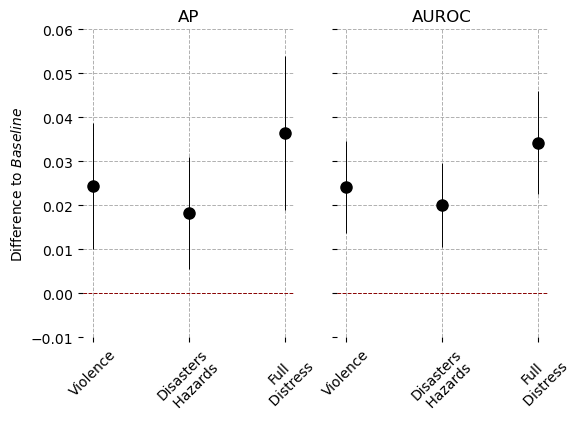

In [56]:
# MAIN FIGURE 2A: 
save_fig = True
fig, axs = plt.subplots(1,2,figsize=(6, 4))

# AP Difference to baseline
a = ['Violence','Disasters\n Hazards','Full\n Distress']
b = mean_ap
y_err = ap_sd

axs[0].errorbar(a, b ,yerr=y_err,
            marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
axs[0].grid(True,linestyle='--',lw=0.7)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

axs[0].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

axs[0].set_ylabel('Difference to $\it{Baseline}$')
axs[0].set_ylim(-0.01,0.06)
axs[0].tick_params(axis='x', labelrotation = 45)


axs[0].set_title('AP')

# AP Difference to baseline
a = ['Violence','Disasters\n Hazards','Full\n Distress']
b = mean_auc
y_err = auc_sd

axs[1].errorbar(a, b ,yerr=y_err,
            marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
axs[1].grid(True,linestyle='--',lw=0.7)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

#axs[1].set_ylabel('Difference in AP')
axs[1].set_ylim(-0.01,0.06)
axs[1].yaxis.set_ticklabels([])
axs[1].tick_params(axis='x', labelrotation = 45)

axs[1].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

axs[1].set_title('AUROC')

if save_fig:
    plt.savefig(os.path.join(output_paths['evalscores'],f'main_fig2a_ap_auc_diff_baseline_{run_preds}_errorplot.png'),bbox_inches='tight')

In [57]:
diff_models = [
    district_violence,
    district_disaster,  
]

mean_ap,  mean_auc = [], []
ap_sd, auc_sd = [], []

for model in diff_models:
    mname = model['model_name']
    max_auroc = []
    max_ap = []
    print(mname)
    for k in range(n_reps_eval):
        max_auroc.append(roc_auc_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k]) -
            roc_auc_score(y_true = preds_dict_eval[f'district_violence_disaster']['actuals'][k], 
            y_score = preds_dict_eval[f'district_violence_disaster']['preds'][k]))
        max_ap.append(average_precision_score(
            y_true = preds_dict_eval[f'{mname}']['actuals'][k], 
            y_score = preds_dict_eval[f'{mname}']['preds'][k])-
            average_precision_score(y_true = preds_dict_eval[f'district_violence_disaster']['actuals'][k], 
            y_score = preds_dict_eval[f'district_violence_disaster']['preds'][k]))

    # 95% CI
    print('f', np.mean(max_ap) - (np.std(max_ap)*2)) 
    print('f', np.mean(max_ap)+ (np.std(max_ap)*2)) 

    mean_ap.append(np.mean(max_ap))
    ap_sd.append(np.std(max_ap)*2)

    mean_auc.append(np.mean(max_auroc))
    auc_sd.append(np.std(max_auroc)*2)

    print('f', np.mean(max_auroc) - (np.std(max_auroc)*2)) 
    print('f', np.mean(max_auroc)+ (np.std(max_auroc)*2)) 

district_violence
f -0.02322388452946402
f -0.0008024033067646243
f -0.016932592677360876
f -0.0032827228207015476
district_disaster
f -0.0314640639359079
f -0.00494399642064443
f -0.02173914962623808
f -0.006753111411173306


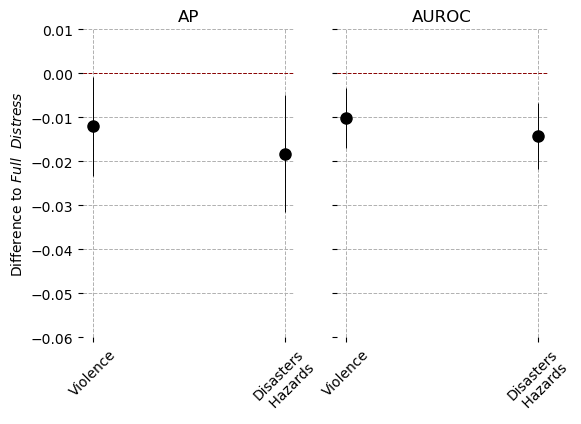

In [58]:
# MAIN FIGURE 2B: 
save_fig = True
fig, axs = plt.subplots(1,2,figsize=(6, 4))

# AP Difference to baseline
a = ['Violence','Disasters\n Hazards']
b = mean_ap
y_err = ap_sd

axs[0].errorbar(a, b ,yerr=y_err,
            marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
axs[0].grid(True,linestyle='--',lw=0.7)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)

axs[0].set_ylabel('Difference to $\it{Full}$  $\it{Distress}$')
axs[0].set_ylim(-0.06,0.01)
axs[0].tick_params(axis='x', labelrotation = 45)
axs[0].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)


axs[0].set_title('AP')

# AP Difference to baseline
a = ['Violence','Disasters\n Hazards']
b = mean_auc
y_err = auc_sd

axs[1].errorbar(a, b ,yerr=y_err,
            marker='o', markersize=8,linestyle='none',color='black',elinewidth=0.7)
axs[1].grid(True,linestyle='--',lw=0.7)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

#axs[1].set_ylabel('Difference in AP')
axs[1].set_ylim(-0.06,0.01)
axs[1].yaxis.set_ticklabels([])
axs[1].tick_params(axis='x', labelrotation = 45)

axs[1].axhline(y = 0, color = 'darkred', linestyle = '--',lw=0.7)

axs[1].set_title('AUROC')
if save_fig: 
    plt.savefig(os.path.join(output_paths['evalscores'],f'main_fig2b_ap_auc_diff_fulldistress_{run_preds}_errorplot.png'),bbox_inches='tight')

In [59]:
f1_models = [
    baseline_district,
    district_violence,
    district_disaster,
    district_violence_disaster,    
]
mean_f1 = []
for model in f1_models:
    mname = model['model_name']
    print(mname)
    
    f1_scores = []
    for k in range(n_reps_eval):
        y_true = preds_dict_eval[mname]['actuals'][k]
        y_prob = preds_dict_eval[mname]['preds'][k]

        # convert probabilities to binary predictions
        y_pred = (np.array(y_prob) >= 0.1).astype(int)

        # compute F1
        f1_scores.append(f1_score(y_true, y_pred,average='macro'))

    mean_f1.append(np.mean(f1_scores))
    print(f"{mname}: mean F1 = {np.mean(f1_scores):.3f}")
            

baseline_district
baseline_district: mean F1 = 0.559
district_violence
district_violence: mean F1 = 0.577
district_disaster
district_disaster: mean F1 = 0.576
district_violence_disaster
district_violence_disaster: mean F1 = 0.579


In [61]:
# TABLE S12 SI:
f1_models = [
    baseline_district,
    district_violence,
    district_disaster,
    district_violence_disaster,    
]

results = []
for model in f1_models:
    mname = model['model_name']

    macro_f1_01, macro_f1_05, weighted_f1_05 = [], [], []

    for k in range(n_reps_eval):
        y_true = preds_dict_eval[mname]['actuals'][k]
        y_prob = preds_dict_eval[mname]['preds'][k]

        # threshold 0.1
        y_pred_01 = (np.array(y_prob) >= 0.1).astype(int)
        macro_f1_01.append(f1_score(y_true, y_pred_01, average="macro"))

        # threshold 0.5
        y_pred_05 = (np.array(y_prob) >= 0.5).astype(int)
        macro_f1_05.append(f1_score(y_true, y_pred_05, average="macro"))
        weighted_f1_05.append(f1_score(y_true, y_pred_05, average="weighted"))

    results.append({
        "Model": mname,
        "Macro F1 (0.1)": np.mean(macro_f1_01),
        "Macro F1 (0.5)": np.mean(macro_f1_05),
        "Weighted F1 (0.5)": np.mean(weighted_f1_05)
    })

df_evalscore = pd.DataFrame(results).round(3)

if save_evalscores: 
    tex = df_evalscore.reset_index(drop=True).to_latex(index=False, float_format="%.3f")
    with open(os.path.join(output_paths['evalscores'], f"SI_tabs12_f1scores_{run_preds}_{esttype}.tex"), "w") as f:
        f.write(tex)
    print(df_evalscore)
else:
    print(df_evalscore)

                        Model  Macro F1 (0.1)  Macro F1 (0.5)  \
0           baseline_district           0.559           0.488   
1           district_violence           0.577           0.488   
2           district_disaster           0.576           0.488   
3  district_violence_disaster           0.579           0.488   

   Weighted F1 (0.5)  
0              0.932  
1              0.932  
2              0.932  
3              0.932  


baseline_district


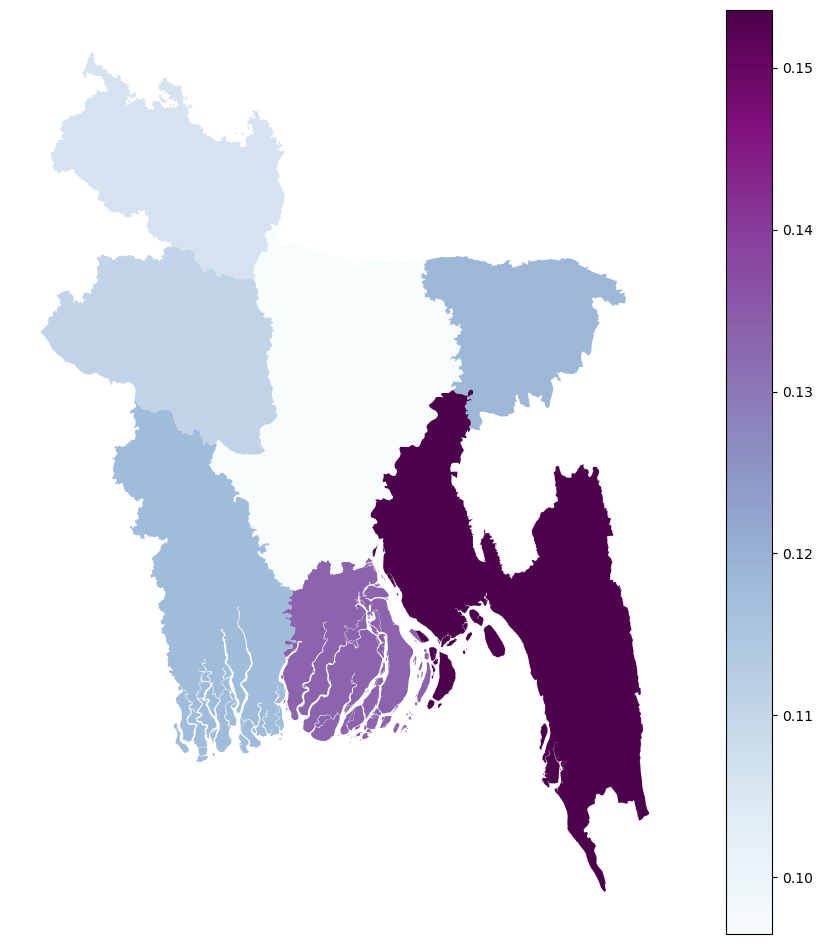

district_violence


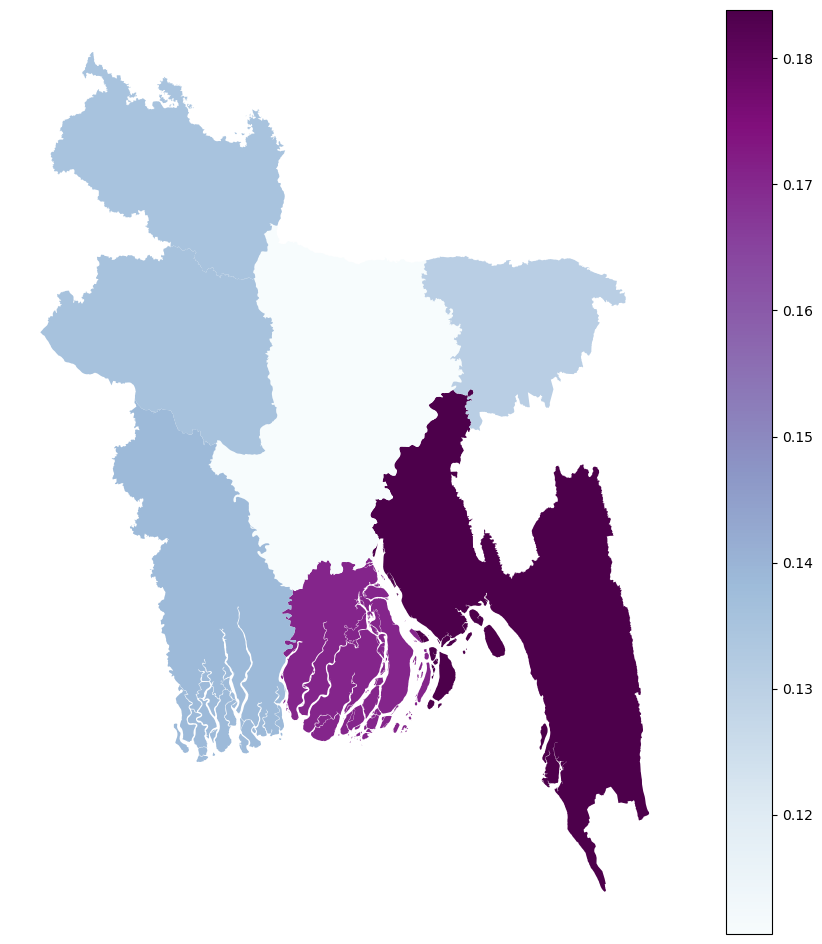

district_disaster


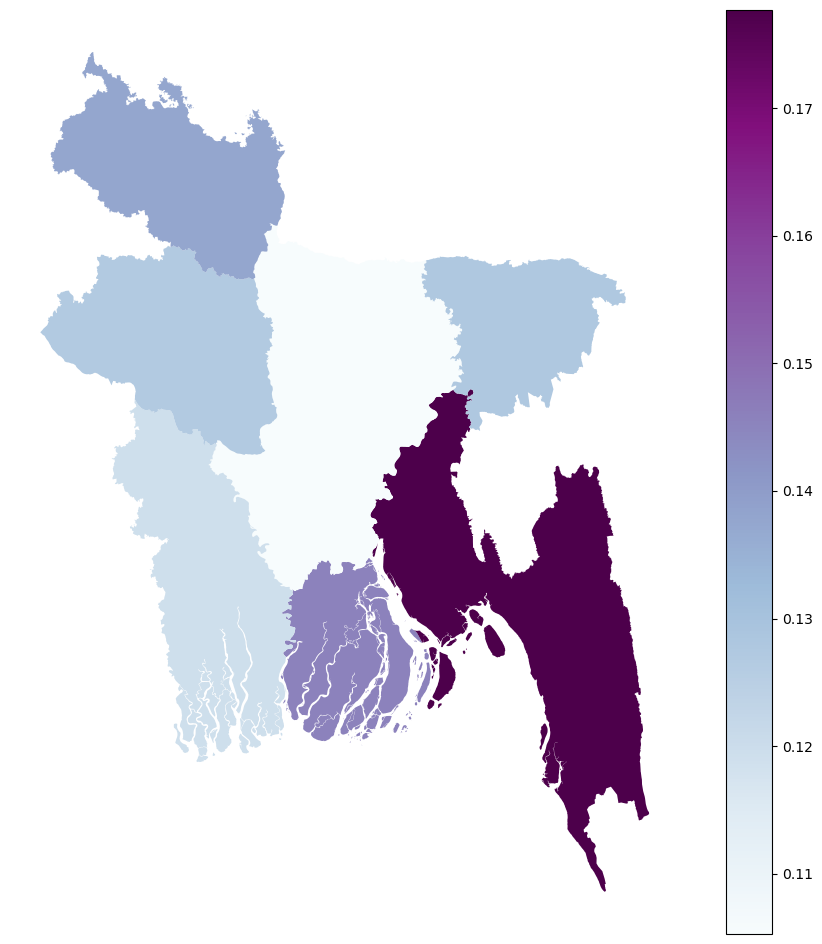

district_violence_disaster


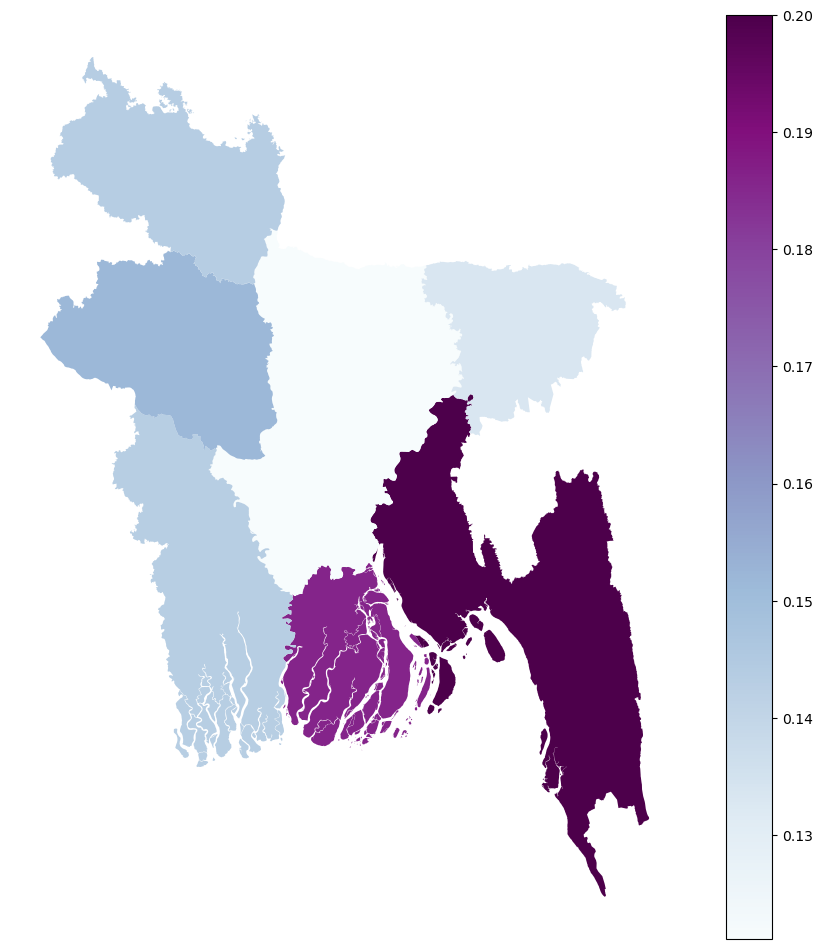

In [71]:
# FIGURE S6 SI: 
score_name = "ap" 
admin1_shp = gpd.read_file(os.path.join(input_data_path, 'gadm36_BGD_1.shp'))

ap_data = []
for model in analysis_models:
    mname = model['model_name']
    print(mname)

    # collect per-fold AP scores by division
    fold_results = []

    for k in range(n_reps_eval):
        # combine preds + actuals + division labels
        df_concat = pd.concat(
            [
                pd.DataFrame(preds_dict_eval[f'{mname}']['preds'][k]).rename(columns={0: 'preds'}),
                pd.DataFrame(preds_dict_eval[f'{mname}']['actuals'][k]).reset_index()
            ],
            axis=1,
            ignore_index=False
        )
        df_concat = df_concat.set_index(['hh_n','year']).join(df_agg[['Division_Name']], how='left')

        # compute AP per division (one value per division in this fold)
        df_div_ap = df_concat.groupby('Division_Name').apply(
            lambda g: average_precision_score(g['both_out'], g['preds']) 
                      if g['both_out'].nunique() > 1 else np.nan,
             include_groups=False
        )
        fold_results.append(df_div_ap)

    # stack results: rows = folds, columns = divisions
    df_divcon = pd.DataFrame(fold_results)

    # average AP per division across folds
    df_div_mean = df_divcon.mean(axis=0)

    # join with shapefile geometries
    df_div_plot = (
        pd.DataFrame({score_name: df_div_mean})
        .join(admin1_shp.set_index('NAME_1').geometry, how='left')
    )

    # plot
    fig, ax = plt.subplots(1, figsize=(12, 12))
    df_div_plot.set_geometry('geometry').plot(
        column=score_name, legend=True, ax=ax, cmap='BuPu',
        #vmin=v_min, vmax=v_max
    )
    ax.axis('off')

    plt.savefig(os.path.join(
        output_paths['evalscores'],
        f'SI_figs_division_{mname}_means_ap.png'
    ))
    plt.show()
    plt.close()

    ap_data.append(df_div_plot)

Model 1 vs baseline: min=0.012, max=0.037


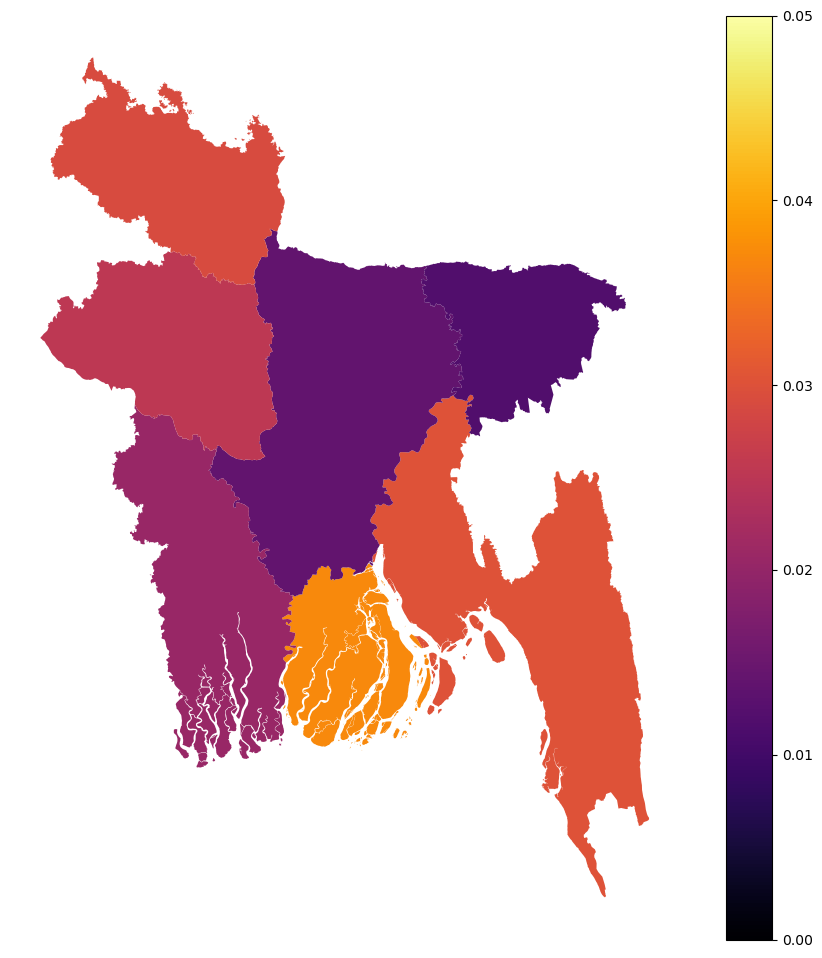

Model 2 vs baseline: min=0.002, max=0.031


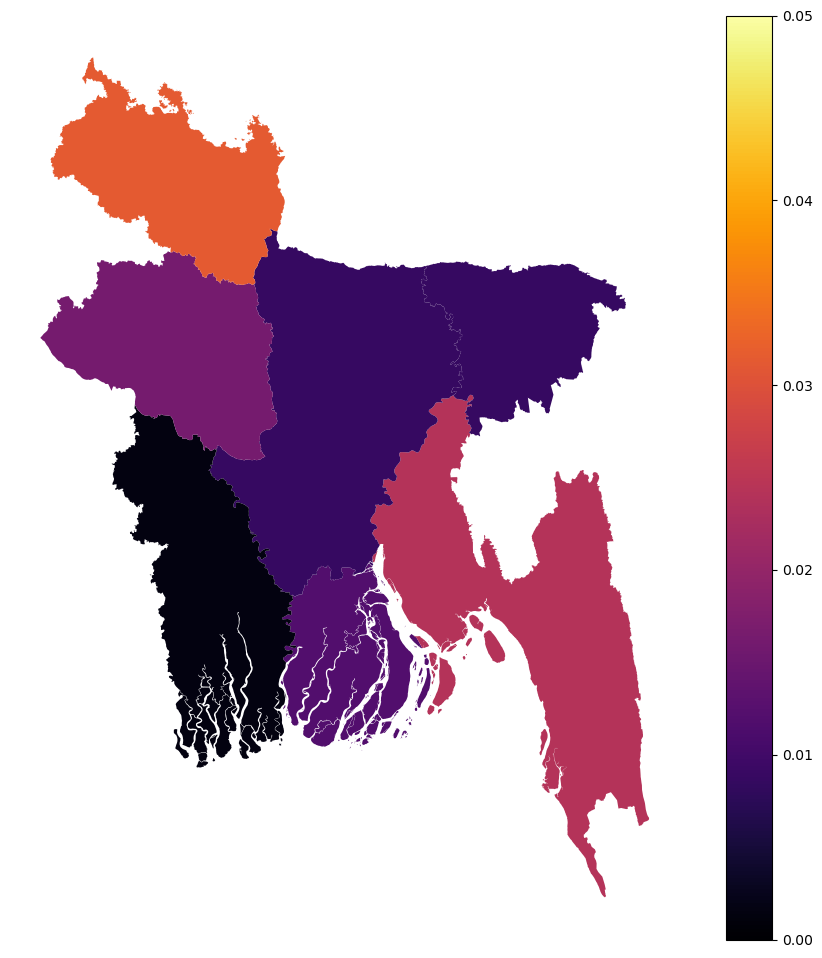

Model 3 vs baseline: min=0.014, max=0.053


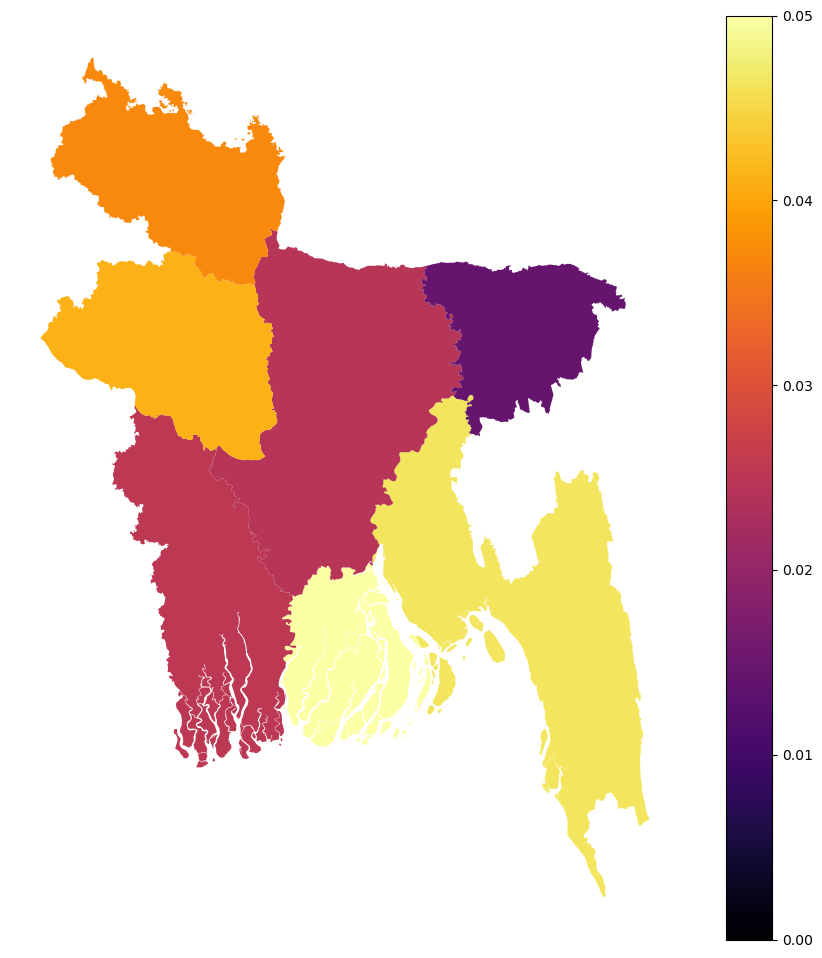

In [74]:
# FIGURE S6 SI: 
baseline = ap_data[0]  # baseline GeoDataFrame

for n in range(len(ap_data)):
    if n == 0:
        continue  # skip baseline vs. itself
    
    model_gdf = ap_data[n]  # GeoDataFrame for this model

    # compute difference in AP per division
    diff = model_gdf['ap'] - baseline['ap']

    # merge with geometry
    diff_gdf = pd.DataFrame(diff).join(baseline[['geometry']])
    diff_gdf = gpd.GeoDataFrame(diff_gdf, geometry='geometry')

    # check range
    print(f"Model {n} vs baseline: min={diff.min():.3f}, max={diff.max():.3f}")

    # plot differences
    fig, ax = plt.subplots(1, figsize=(12, 12))
    diff_gdf.plot(
        column='ap', legend=True, ax=ax, cmap='inferno',
        vmin=0, vmax=0.05 
    )
    ax.axis('off')

    plt.savefig(os.path.join(
        output_paths['evalscores'],
        f'SI_figs_ap_division_diff_bl_m{n}_means.png'
    ))
    plt.show()
    plt.close()


### ML interpretability tools - SHAP values

In [75]:
shap_eval = True
n_reps_shap = 100

In [76]:
# Load human variable names
if shap_eval:
    with open(os.path.join(os.getcwd(),'variable_dict.json'), 'r') as file:
        name_dict = json.load(file)

#### Influential predictors

district_violence_disaster


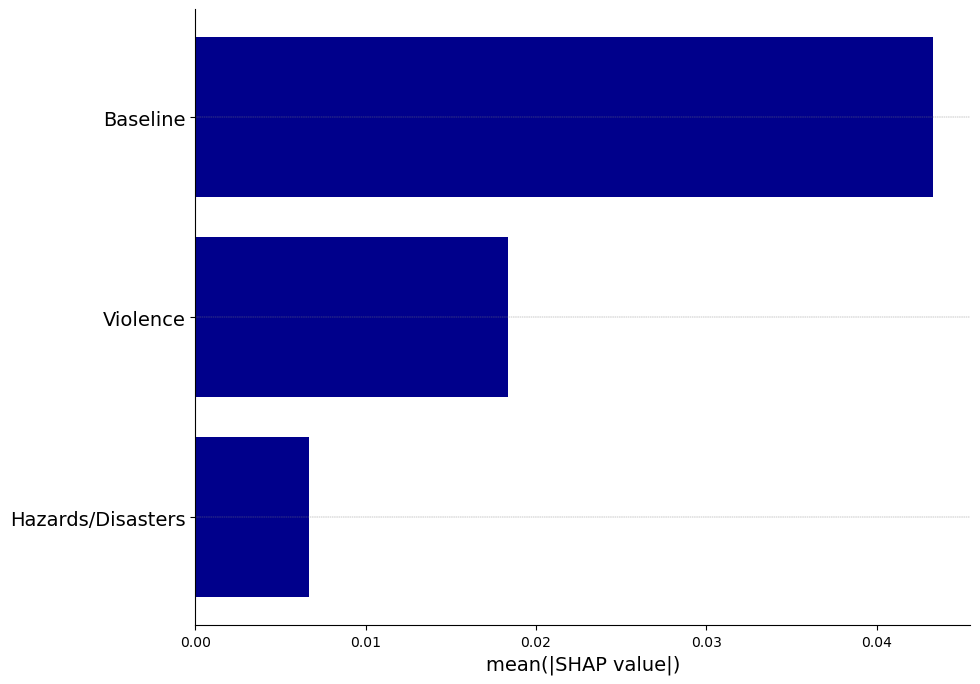

In [77]:
# MAIN FIGURE 3A: 
# Plot sum of shap values for all repetitions
analysis_models_shap = [district_violence_disaster]
figlabels = ['a)']
fig_nr = 'fig3a'

feat_group1 = ['nlight_mean', 'PG_GCP_PPP_LI', 'head_age', 'head_sex', 'prim_educ', 'sec_educ', 'ter_educ', 'no_educ', 'religion', 'ethnicity', 'head_ocup_agg', 'mig_history', 'ln_mob_asset_value_own', 'ln_savings', 'ln_loans', 'ln_land_size', 'ln_pc_expm', 'ag_subsidy', 'ln_livestock_value', 'sl_benefited', 'ln_income', 'ln_remittances_in_value', 'active_member', 'active_leader', 'satisfied_leave', 'satisfied_life', 'mobile', 'radio', 'tv']
feat_group2 =  ['ged_best_ns_tlag12', 'ged_best_sb_tlag12', 'ged_best_osv_tlag12', 'ged_best_ns_splag1_tlag12', 'ged_best_sb_splag1_tlag12', 'ged_best_osv_splag1_tlag12', 'acled_prrio_count_tlag12', 'acled_prrio_count_splag1_tlag12', 'acled_prex_count_tlag12', 'acled_prex_count_splag1_tlag12', 'ged_best_ns_ts_decay_6_tlag12', 'ged_best_osv_ts_decay_6_tlag12', 'ged_best_sb_ts_decay_6_tlag12', 'acled_prrio_count_ts_decay_6_tlag12', 'acled_prrio_count_splag1_ts_decay_6_tlag12', 'acled_prex_count_ts_decay_6_tlag12', 'acled_prex_count_splag1_ts_decay_6_tlag12', 'deco_best_ns_tlag12', 'deco_best_sb_tlag12', 'deco_best_osv_tlag12', 'deco_best_ns_splag1_tlag12', 'deco_best_sb_splag1_tlag12', 'deco_best_osv_splag1_tlag12', 'deco_best_ns_ts_decay_6_tlag12', 'deco_best_osv_ts_decay_6_tlag12', 'deco_best_sb_ts_decay_6_tlag12']
feat_group3 =  ['gdis_n_disasters_tlag12', 'flood_dummy_ts_decay_6_tlag12', 'gdis_disastertype_flood_ts_decay_6_tlag12', 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'gdis_disastertype_storm_ts_decay_6_tlag12', 'spei_3_severe_ts_decay_6_tlag12']

for mod,figlabel in zip(analysis_models_shap,figlabels):
    print(mod['model_name'])
    mname= mod['model_name']

    pathsave = os.path.join(
        output_paths['shapvals'],
        f'main_{fig_nr}_shap_mean_barplots_aggfeats_{esttype}_test_{run_shap}.png')

    fun_plots.plot_barshap_sumfeatures(
        dict_shaps=shapvalsdict, 
        dict_train_cols=train_outdict, 
        modelname=mname,
        do_mean=True,
        feature_sets=[feat_group1,feat_group2,feat_group3],
        feature_set_names=['Baseline','Violence','Hazards/Disasters'],
        n_range=n_reps_shap, 
        #figure_label=figlabel,
        save_fig_path=pathsave,
    )

district_violence_disaster
ln_remittances_in_value                          0.019594
deco_best_osv_ts_decay_6_tlag12                  0.010006
ln_loans                                         0.005365
mig_history                                      0.004781
head_age                                         0.003989
gdis_disastertype_flood_ts_decay_6_tlag12        0.002433
gdis_disastertype_landslide_ts_decay_6_tlag12    0.002037
satisfied_leave                                  0.001830
deco_best_sb_ts_decay_6_tlag12                   0.001829
nlight_mean                                      0.001806
Sum of 51 other features                         0.014711
dtype: float64
0.06838304420699319


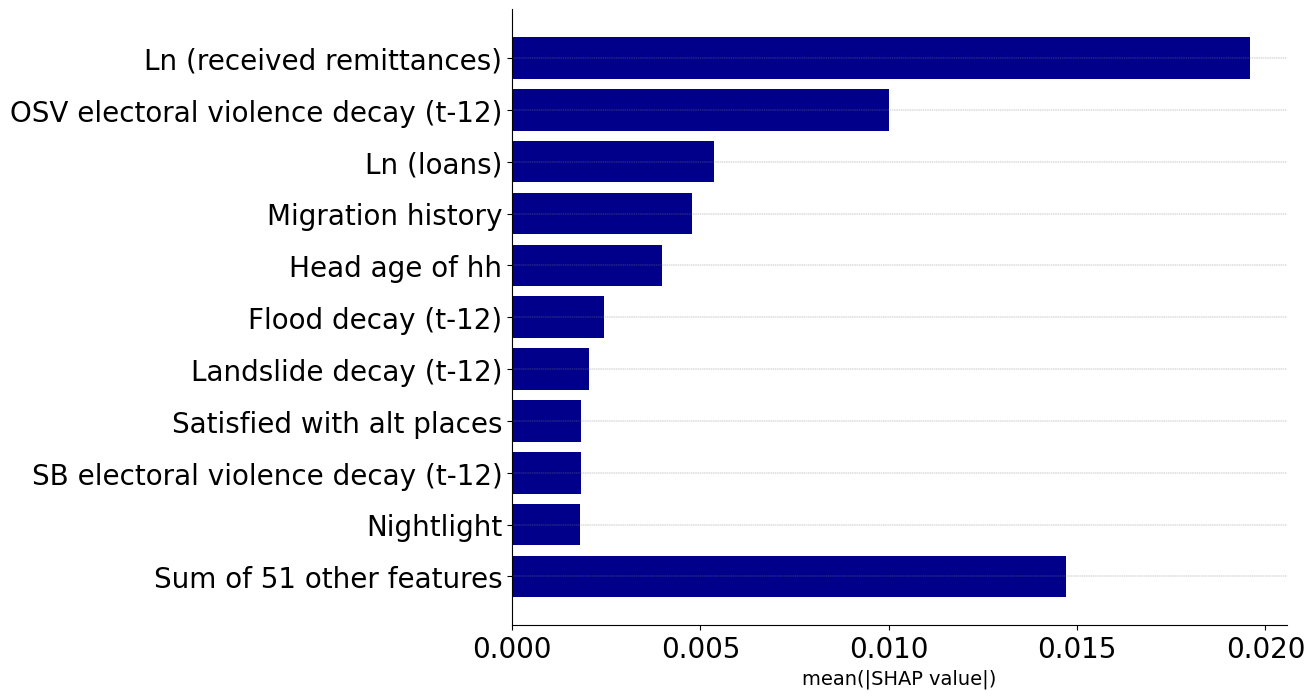

In [78]:
# MAIN FIGURE 3B: 
# Plot individual features for mean folds
analysis_models_shap = [district_violence_disaster]
figlabels = ['b)']
fig_nr = 'fig3b'

for mod,figlabel in zip(analysis_models_shap,figlabels):
    print(mod['model_name'])
    mname= mod['model_name']

    pathsave = os.path.join(
        output_paths['shapvals'],
        f'main_{fig_nr}_shap_mean_barplots_{mname}_{esttype}_test_{run_shap}.png')

    fun_plots.plot_barshap(
        dict_shaps=shapvalsdict, 
        dict_train_cols=train_outdict, 
        name_dict=name_dict,
        modelname=mname,
        do_mean=True,
        do_best=False,
        #bestfold=bf,
        n_range=n_reps_shap,
        #threshold=0.01,
        n_max_values=10,
        #figure_label=figlabel,
        save_fig_path=pathsave,
    )

baseline_district
ln_remittances_in_value     0.021193
ln_loans                    0.007302
mig_history                 0.004567
head_age                    0.003879
satisfied_leave             0.002306
ln_income                   0.001847
PG_GCP_PPP_LI               0.001774
mobile                      0.001604
ln_pc_expm                  0.001189
ln_mob_asset_value_own      0.000821
Sum of 19 other features    0.001977
dtype: float64
0.04845986587726781


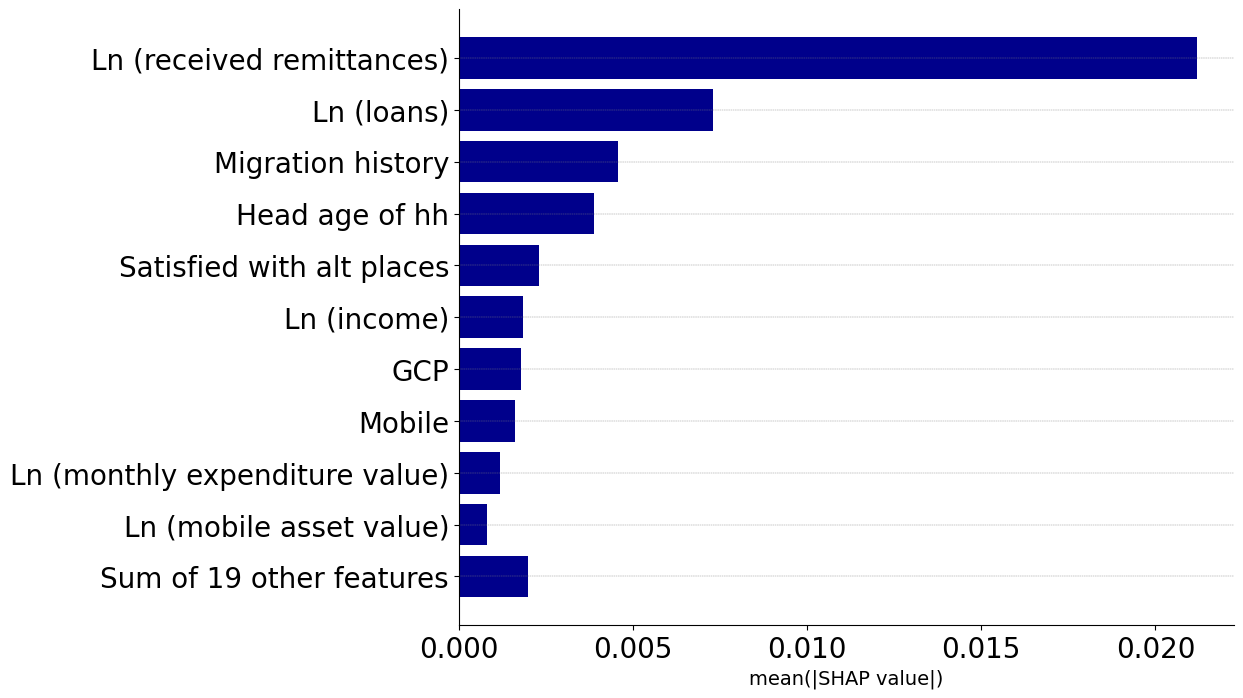

district_violence
ln_remittances_in_value                      0.018858
deco_best_osv_ts_decay_6_tlag12              0.010571
ln_loans                                     0.004963
mig_history                                  0.004464
head_age                                     0.003270
deco_best_sb_ts_decay_6_tlag12               0.003060
ged_best_ns_ts_decay_6_tlag12                0.001481
satisfied_leave                              0.001432
nlight_mean                                  0.001209
acled_prex_count_splag1_ts_decay_6_tlag12    0.001182
Sum of 45 other features                     0.007099
dtype: float64
0.057589242482440475


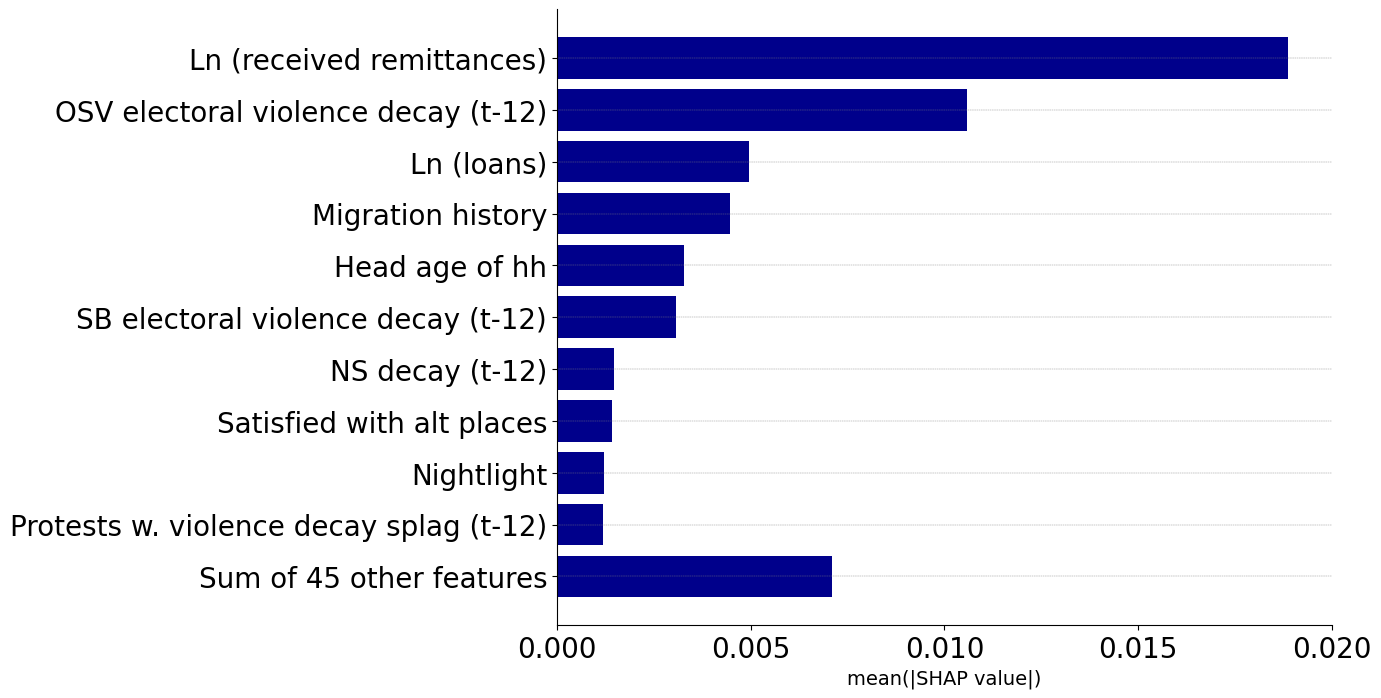

district_disaster
ln_remittances_in_value                          0.019653
gdis_disastertype_landslide_ts_decay_6_tlag12    0.007044
ln_loans                                         0.006152
gdis_disastertype_flood_ts_decay_6_tlag12        0.004761
mig_history                                      0.004344
head_age                                         0.003517
satisfied_leave                                  0.001550
flood_dummy_ts_decay_6_tlag12                    0.001543
gdis_disastertype_storm_ts_decay_6_tlag12        0.001321
ln_pc_expm                                       0.000860
Sum of 25 other features                         0.003721
dtype: float64
0.05446626493943075


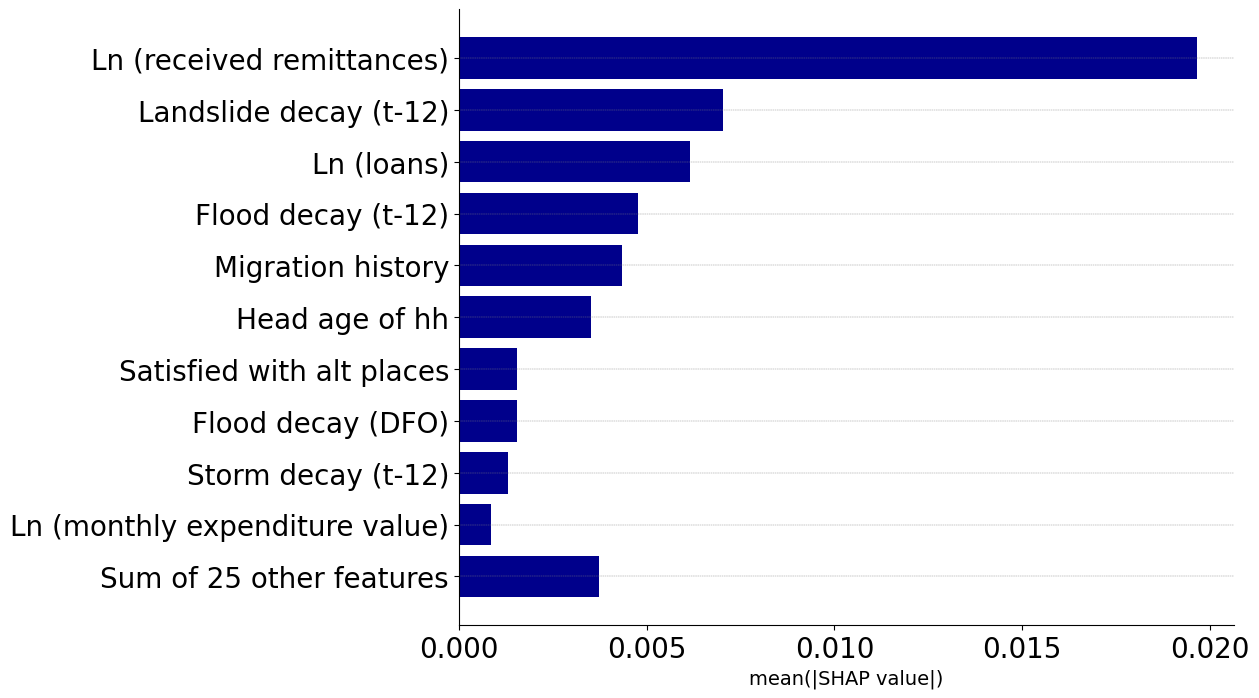

district_violence_disaster
ln_remittances_in_value                          0.019594
deco_best_osv_ts_decay_6_tlag12                  0.010006
ln_loans                                         0.005365
mig_history                                      0.004781
head_age                                         0.003989
gdis_disastertype_flood_ts_decay_6_tlag12        0.002433
gdis_disastertype_landslide_ts_decay_6_tlag12    0.002037
satisfied_leave                                  0.001830
deco_best_sb_ts_decay_6_tlag12                   0.001829
nlight_mean                                      0.001806
Sum of 51 other features                         0.014711
dtype: float64
0.06838304420699319


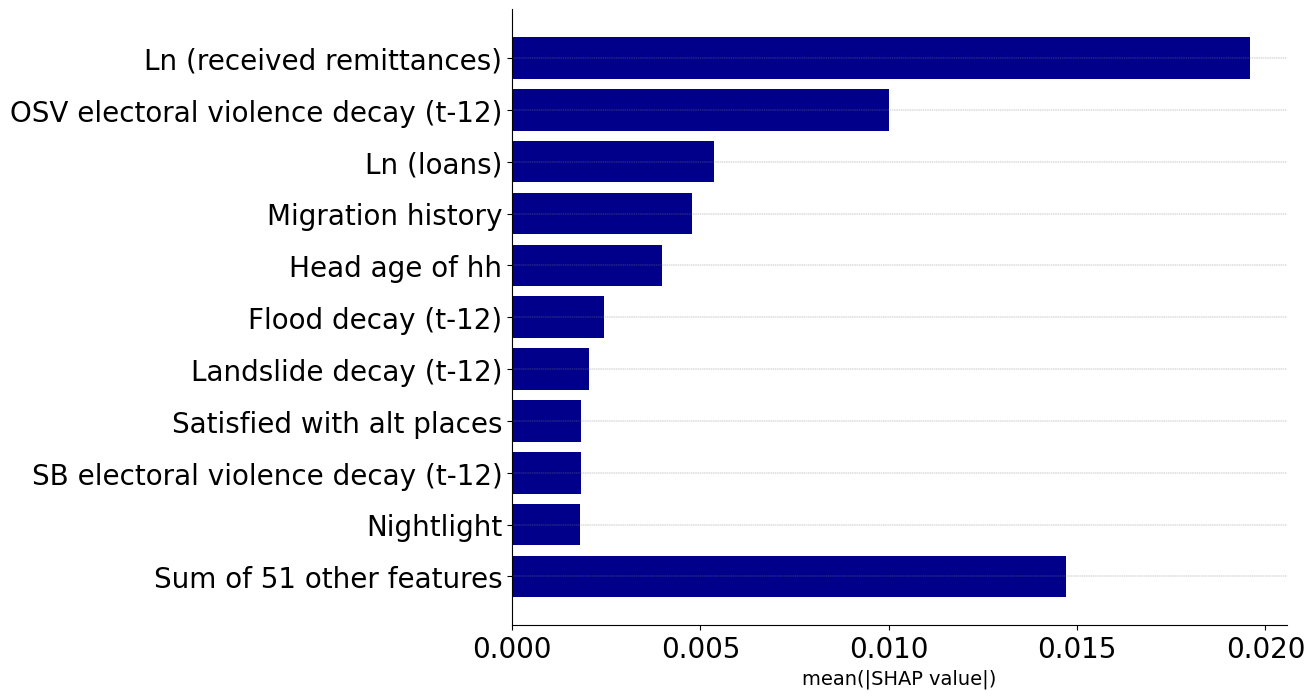

In [79]:
# FIGURE S7 SI: 
analysis_models_shap = allmodels
fig_nr = 'SI_figS7'

for mod in analysis_models_shap:
    print(mod['model_name'])
    mname= mod['model_name']

    pathsave = os.path.join(
        output_paths['shapvals'],
        f'{fig_nr}_shap_mean_barplots_{mname}_{esttype}_test_{run_shap}.png')

    fun_plots.plot_barshap(
        dict_shaps=shapvalsdict, 
        dict_train_cols=train_outdict, 
        name_dict=name_dict,
        modelname=mname,
        do_mean=True,
        do_best=False,
        #bestfold=bf,
        n_range=100, # Number of repetitions
        #threshold=0.01,
        n_max_values=10,
        save_fig_path=pathsave,
    )

In [80]:
analysis_models_shap = allmodels
selected_folds_dict = {}  

for mod in analysis_models_shap:
    print(mod['model_name'])
    mname = mod['model_name']

    # collect AP for each fold
    ap_scores = []
    for k in range(len(preds_dict_shap[mname]['preds'])):  
        ap_val = average_precision_score(
            y_true = preds_dict_shap[mname]['actuals'][k],
            y_score = preds_dict_shap[mname]['preds'][k]
        )
        ap_scores.append((k, ap_val))

    # compute median AP
    ap_vals = [val for _, val in ap_scores]
    median_ap = np.median(ap_vals)

    # select folds above (or equal to) median
    selected_folds = [fold for fold, val in ap_scores if val >= median_ap]
    selected_folds_dict[mname] = selected_folds  # save to dict

    print(f"Selected {len(selected_folds)} folds for model {mname} (≥ median AP = {median_ap:.3f})")

print(selected_folds_dict['district_violence_disaster'])

baseline_district
Selected 50 folds for model baseline_district (≥ median AP = 0.111)
district_violence
Selected 50 folds for model district_violence (≥ median AP = 0.136)
district_disaster
Selected 50 folds for model district_disaster (≥ median AP = 0.129)
district_violence_disaster
Selected 50 folds for model district_violence_disaster (≥ median AP = 0.149)
[2, 3, 7, 8, 9, 10, 12, 13, 16, 18, 21, 23, 24, 25, 27, 28, 30, 31, 32, 37, 38, 40, 41, 44, 46, 55, 56, 57, 58, 64, 67, 68, 69, 70, 71, 72, 74, 75, 80, 84, 86, 87, 89, 90, 92, 93, 95, 96, 97, 99]


In [81]:
# Select the 50-best peforming folds
shapvalsdict_filtered = {
    model: {fold: shapvalsdict[model][fold] 
            for fold in selected_folds_dict[model] if fold in shapvalsdict[model]}
    for model in selected_folds_dict.keys()
}

baseline_district
ln_remittances_in_value     0.020989
ln_loans                    0.007101
mig_history                 0.004566
head_age                    0.003936
satisfied_leave             0.002379
ln_income                   0.001981
PG_GCP_PPP_LI               0.001707
mobile                      0.001567
ln_pc_expm                  0.001198
ln_mob_asset_value_own      0.000806
Sum of 19 other features    0.001943
dtype: float64
0.04817213675764685


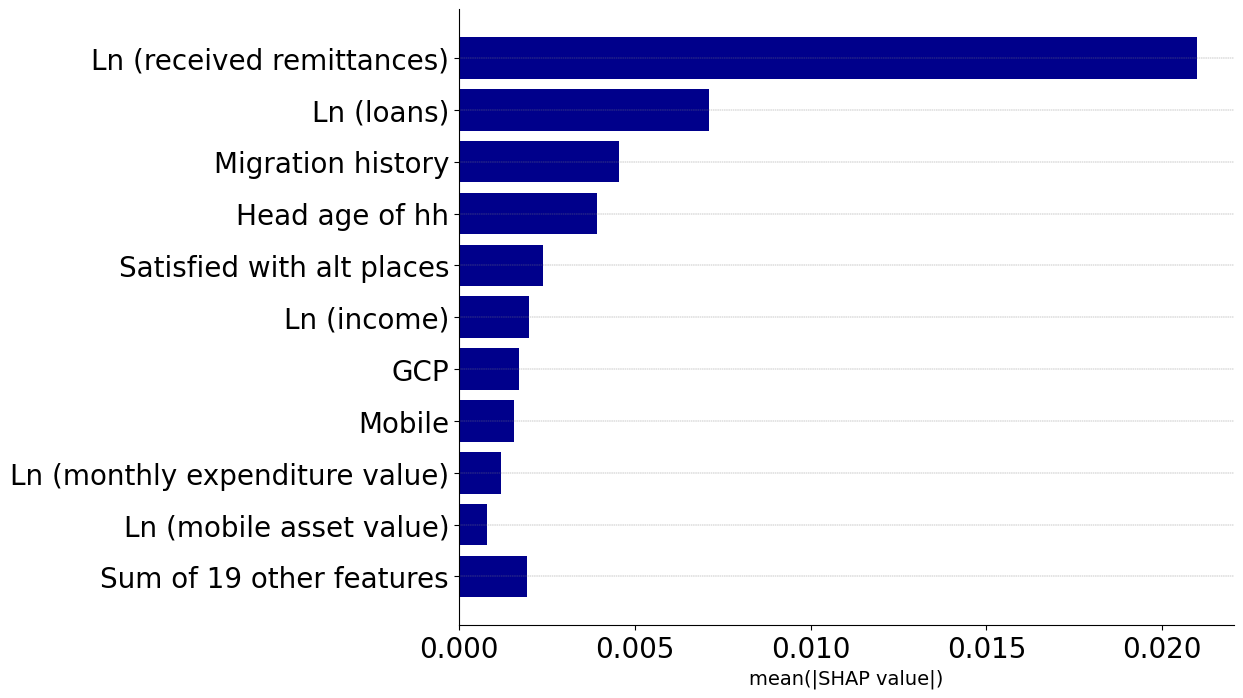

district_violence
ln_remittances_in_value            0.018712
deco_best_osv_ts_decay_6_tlag12    0.010290
ln_loans                           0.004906
mig_history                        0.004446
head_age                           0.003297
deco_best_sb_ts_decay_6_tlag12     0.002972
ged_best_ns_ts_decay_6_tlag12      0.001447
satisfied_leave                    0.001409
nlight_mean                        0.001240
ged_best_osv_ts_decay_6_tlag12     0.001202
Sum of 45 other features           0.006980
dtype: float64
0.056901375499633956


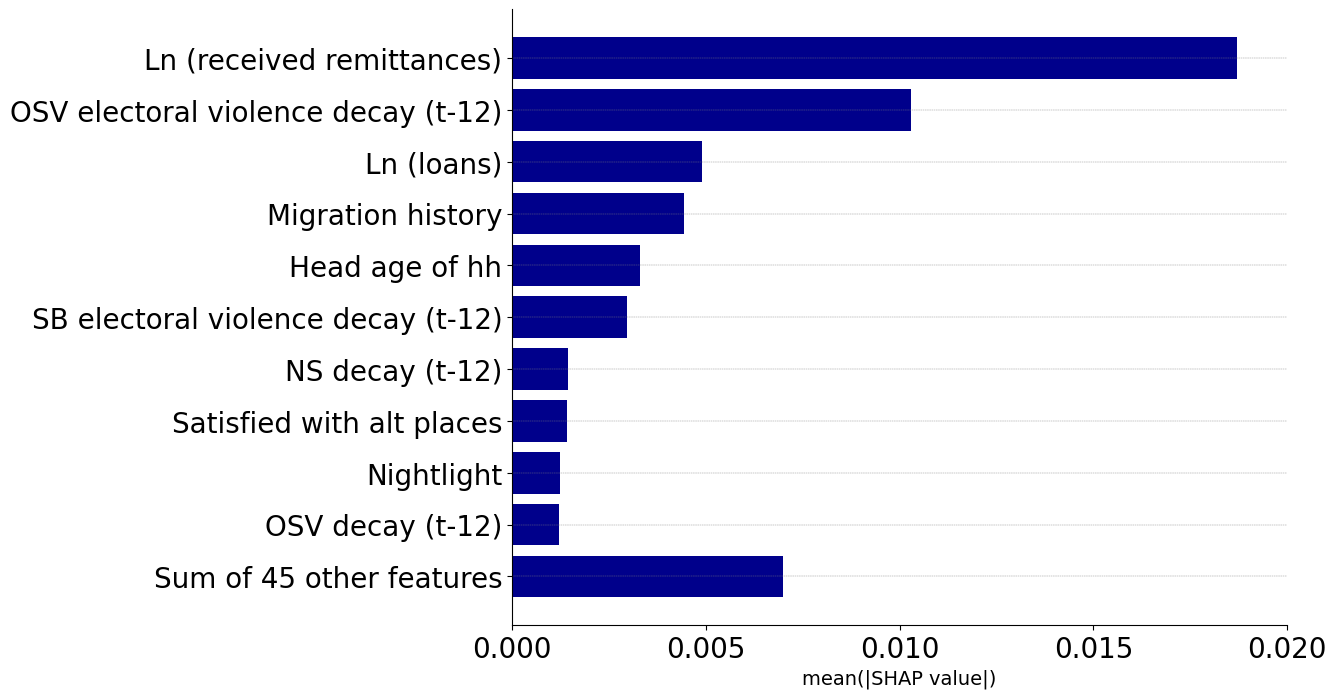

district_disaster
ln_remittances_in_value                          0.019570
gdis_disastertype_landslide_ts_decay_6_tlag12    0.006956
ln_loans                                         0.006064
gdis_disastertype_flood_ts_decay_6_tlag12        0.004632
mig_history                                      0.004297
head_age                                         0.003531
satisfied_leave                                  0.001568
flood_dummy_ts_decay_6_tlag12                    0.001514
gdis_disastertype_storm_ts_decay_6_tlag12        0.001302
ln_pc_expm                                       0.000901
Sum of 25 other features                         0.003735
dtype: float64
0.0540703148485331


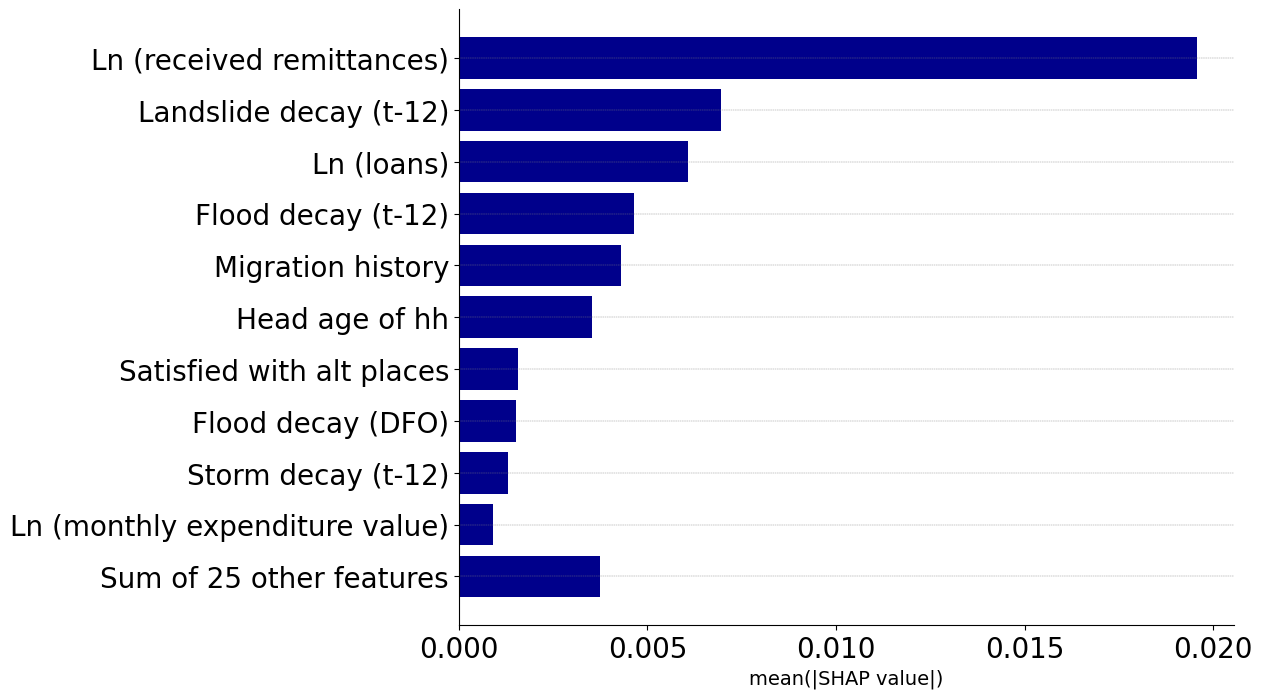

district_violence_disaster
ln_remittances_in_value                          0.019576
deco_best_osv_ts_decay_6_tlag12                  0.009699
ln_loans                                         0.005370
mig_history                                      0.004754
head_age                                         0.003954
gdis_disastertype_flood_ts_decay_6_tlag12        0.002349
gdis_disastertype_landslide_ts_decay_6_tlag12    0.001992
satisfied_leave                                  0.001835
deco_best_sb_ts_decay_6_tlag12                   0.001834
nlight_mean                                      0.001784
Sum of 51 other features                         0.014608
dtype: float64
0.06775408210813957


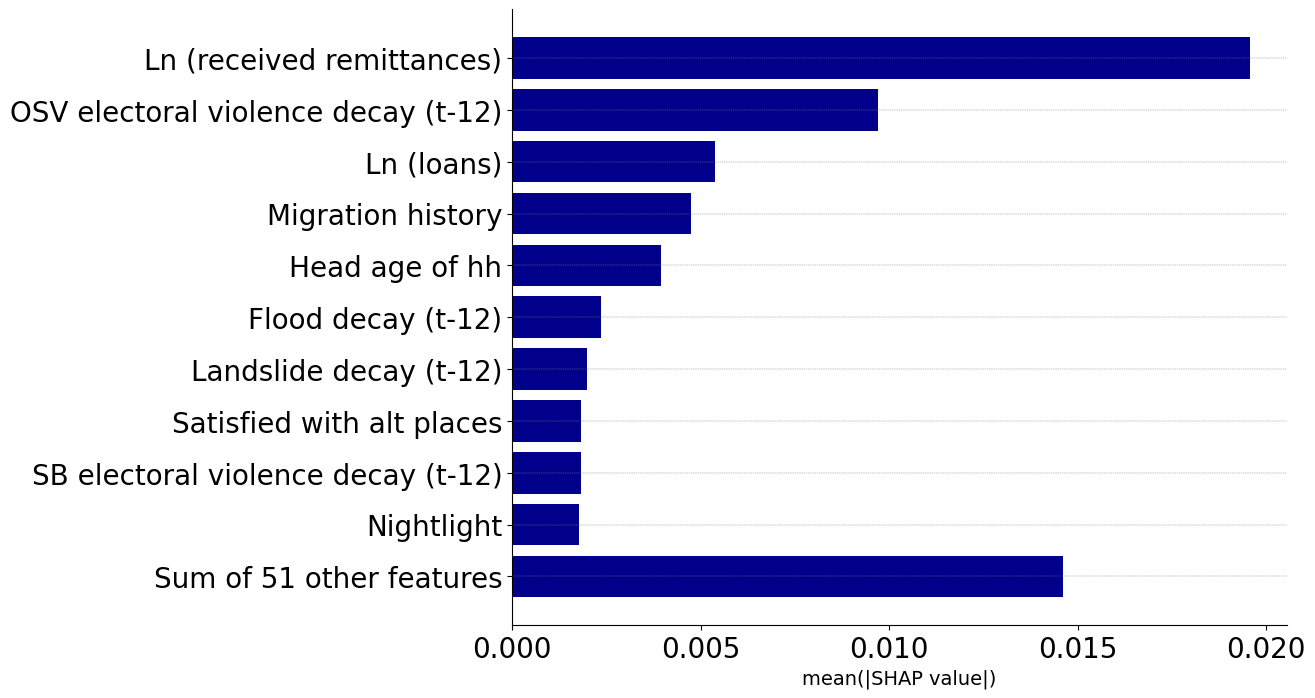

In [82]:
# Plot individual features for mean folds for best 50 folds 
# FIGURE S8 SI: 
analysis_models_shap = allmodels
fig_nr = 'SI_figS8'

for mod in analysis_models_shap:
    print(mod['model_name'])
    mname= mod['model_name']

    pathsave = os.path.join(
        output_paths['shapvals'],
        f'{fig_nr}_shap_mean_best50_barplots_{mname}_{esttype}_test_{run_shap}.png')

    fun_plots.plot_barshap(
        dict_shaps=shapvalsdict_filtered, 
        dict_train_cols=train_outdict, 
        name_dict=name_dict,
        modelname=mname,
        do_mean=False,
        do_best=True,
        #bestfold=bf,
        #n_range=100, # Number of repetitions
        selected_folds = selected_folds_dict[mname],
        #threshold=0.01,
        n_max_values=10,
        save_fig_path=pathsave,
    )

In [83]:
# Sample from the pooled 
pooled_shap_full_model = fun_plots.pool_shap_selected(
    shapdict_model=shapvalsdict['district_violence_disaster'],
    selected_folds=selected_folds_dict['district_violence_disaster'], 
    sample_size=10000, 
    random_state=1308
)

In [84]:
# Sample from the pooled for all folds as robustness test
pooled_shap_full_model_all = fun_plots.pool_shap_selected(
    shapdict_model=shapvalsdict['district_violence_disaster'],
    selected_folds=list(range(100)), 
    sample_size=10000, 
    random_state=1308
)

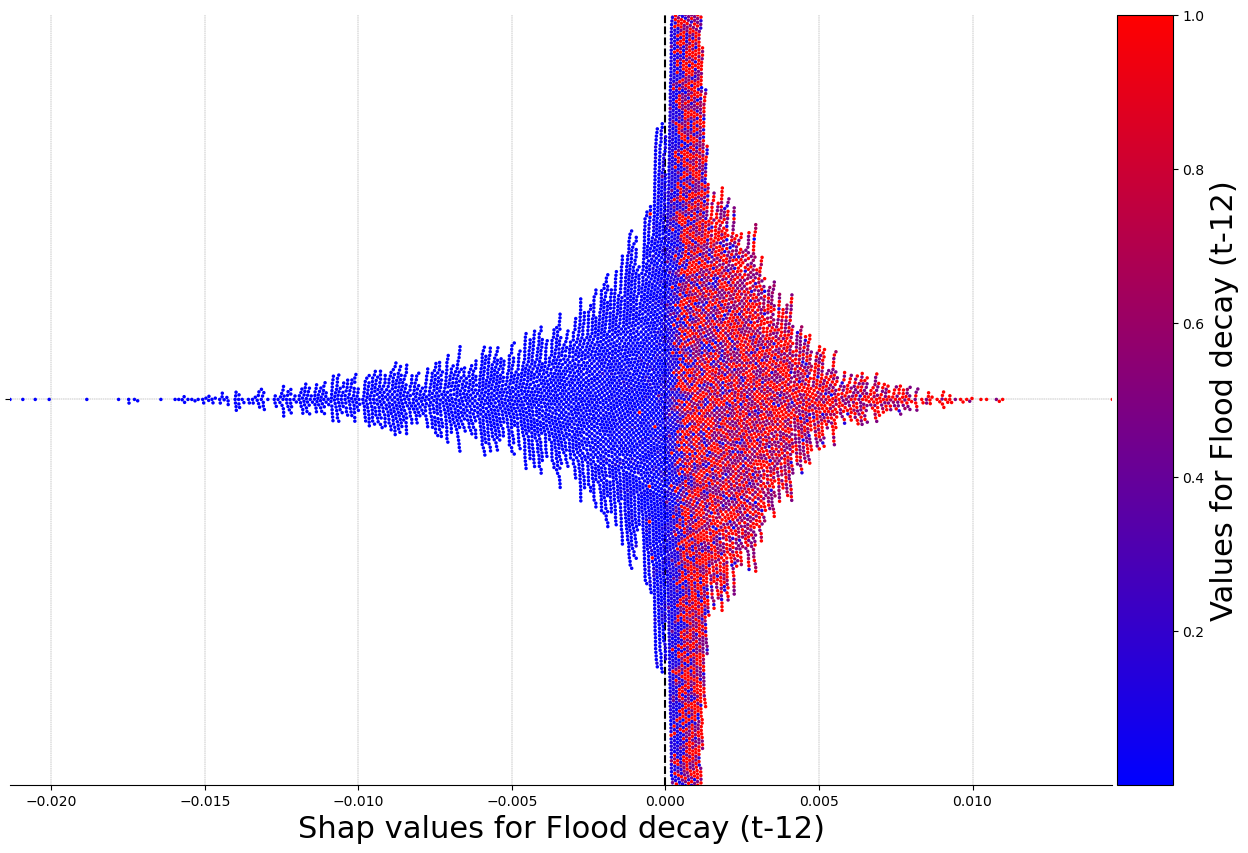

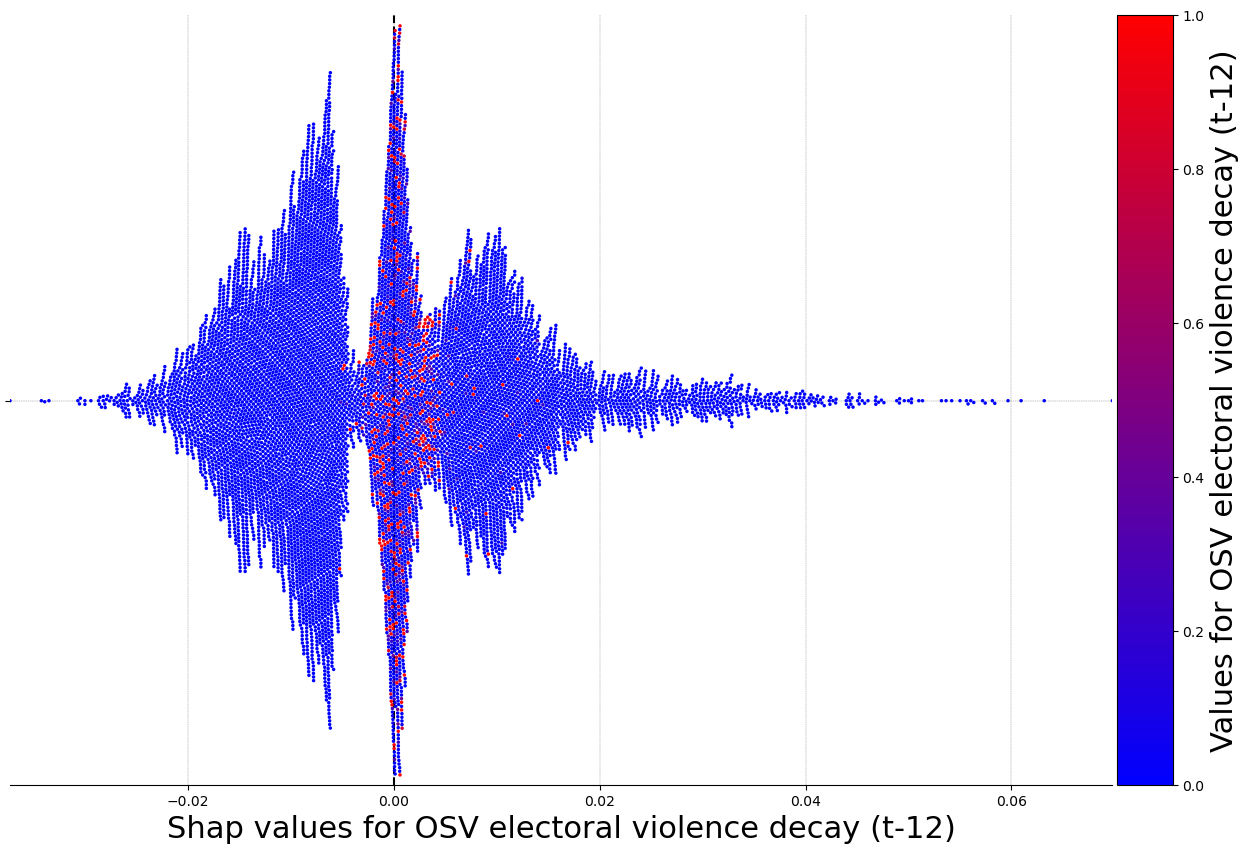

In [85]:
# MAIN FIGURE 4:
x_vars = [
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
]
labels = ["a)", "b)"]
fig_nr = "fig4"
txt_save = "actuals"

for x_var, figlab in zip(x_vars, labels):
    fun_plots.beeswarmplot_continuous(
        shapvals=pooled_shap_full_model_all, # pooled model
        model=district_violence_disaster, 
        varname=x_var, 
        name_dict=name_dict,
        #figure_label=figlab,
        path_figure=os.path.join(
            output_paths['shapvals'],
            f"main_{fig_nr}{figlab}_beeswarm_{x_var}_{txt_save}_{esttype}_pooled_{run_shap}.png"
        ),
    )

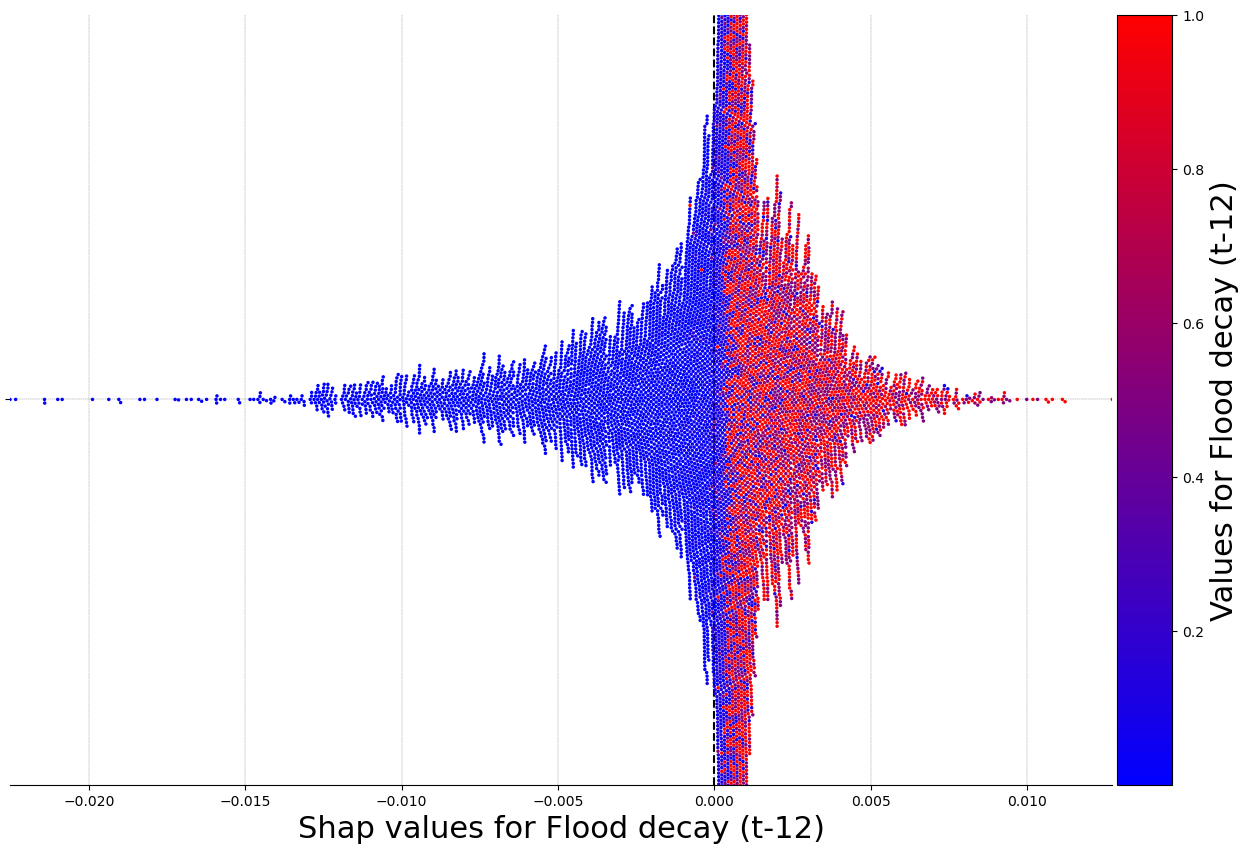

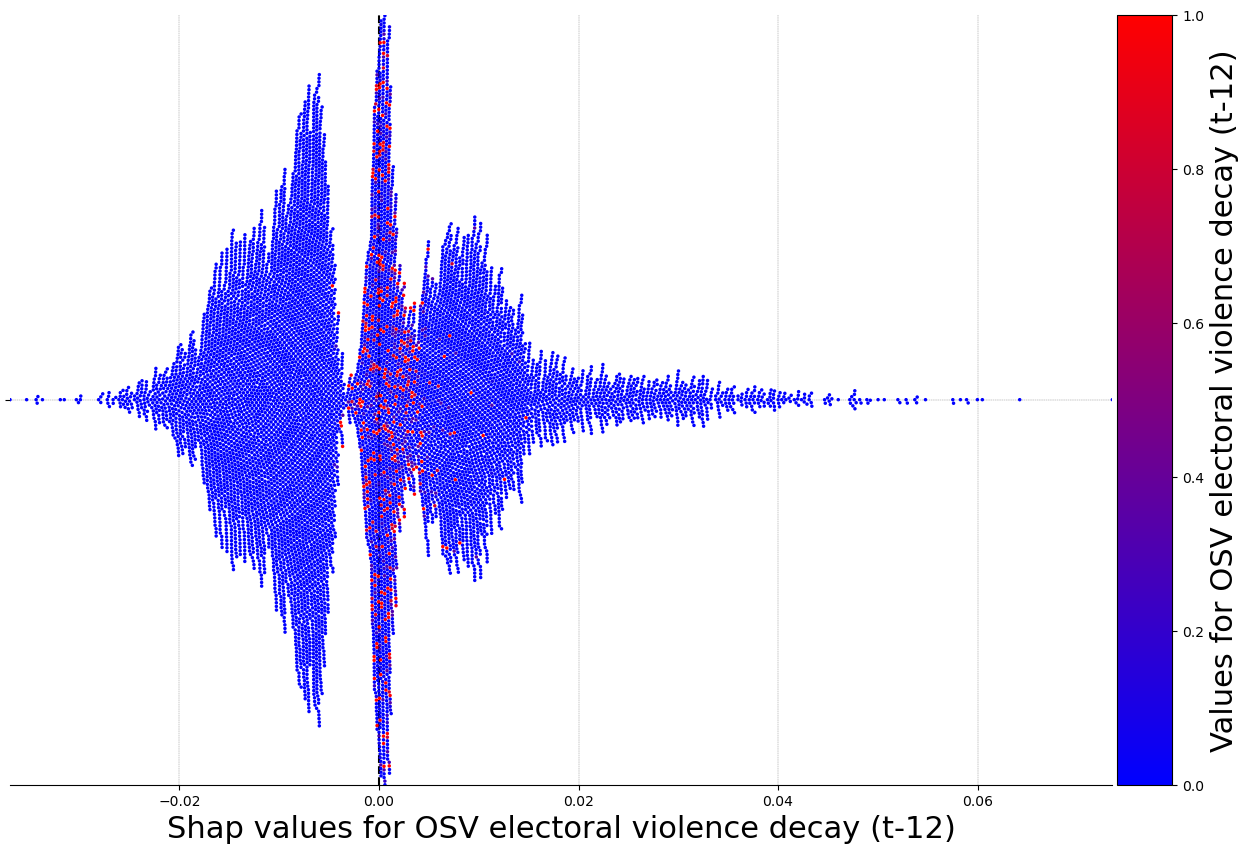

In [86]:
# FIGURE S9 SI:
x_vars = [
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
]
labels = ["a)", "b)"]
fig_nr = "SI_figS9"
txt_save = "actuals"

for x_var, figlab in zip(x_vars, labels):
    fun_plots.beeswarmplot_continuous(
        shapvals=pooled_shap_full_model, # pooled model only beased on best folds
        model=district_violence_disaster, 
        varname=x_var, 
        name_dict=name_dict,
        #figure_label=figlab,
        path_figure=os.path.join(
            output_paths['shapvals'],
            f"{fig_nr}{figlab}_beeswarm_{x_var}_{txt_save}_{esttype}_pooled_robustness_{run_shap}.png"
        ),
    )

In [87]:
analysis_models_shap = allmodels
best_folds_dict = {}  

for mod in analysis_models_shap:
    print(mod['model_name'])
    mname = mod['model_name']

    # collect AP for each fold
    ap_scores = []
    for k in range(len(preds_dict_shap[mname]['preds'])):  
        ap_val = average_precision_score(
            y_true = preds_dict_shap[mname]['actuals'][k],
            y_score = preds_dict_shap[mname]['preds'][k]
        )
        ap_scores.append((k, ap_val))

    # compute median AP
    ap_vals = [val for _, val in ap_scores]
    median_ap = np.max(ap_vals)

    # select folds above (or equal to) median
    selected_folds = [fold for fold, val in ap_scores if val == median_ap]
    best_folds_dict[mname] = selected_folds  # save to dict

    print(f"Selected {len(selected_folds)} folds for model {mname} (≥ median AP = {median_ap:.3f})")

print(best_folds_dict)

baseline_district
Selected 1 folds for model baseline_district (≥ median AP = 0.144)
district_violence
Selected 1 folds for model district_violence (≥ median AP = 0.162)
district_disaster
Selected 1 folds for model district_disaster (≥ median AP = 0.161)
district_violence_disaster
Selected 1 folds for model district_violence_disaster (≥ median AP = 0.176)
{'baseline_district': [37], 'district_violence': [38], 'district_disaster': [38], 'district_violence_disaster': [38]}


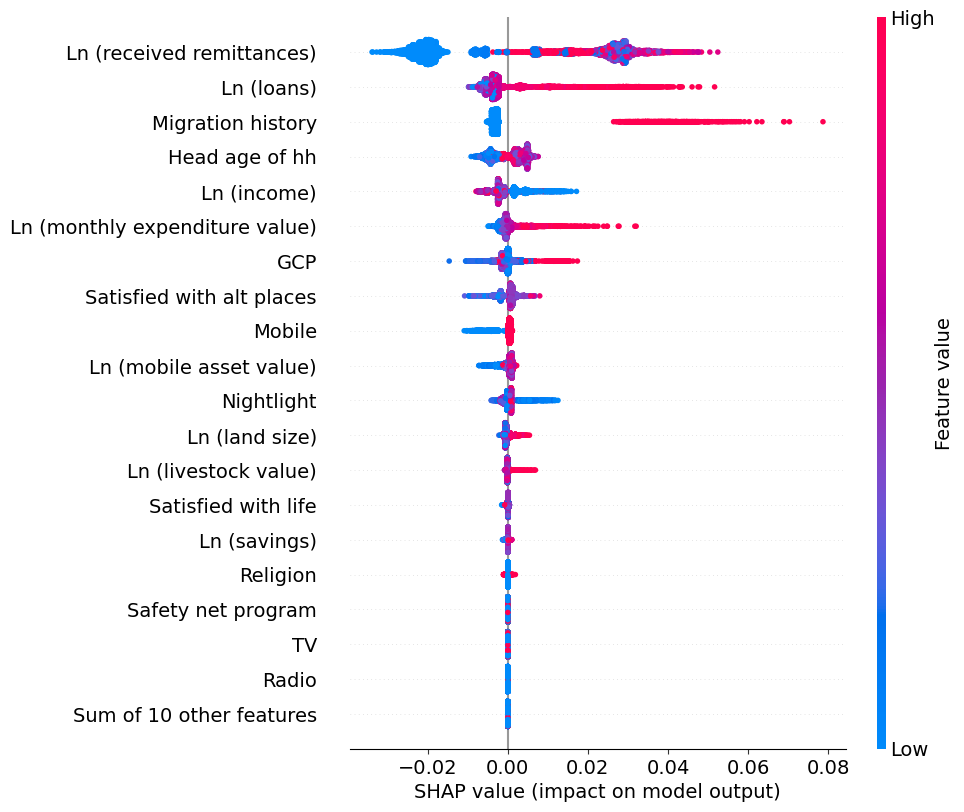

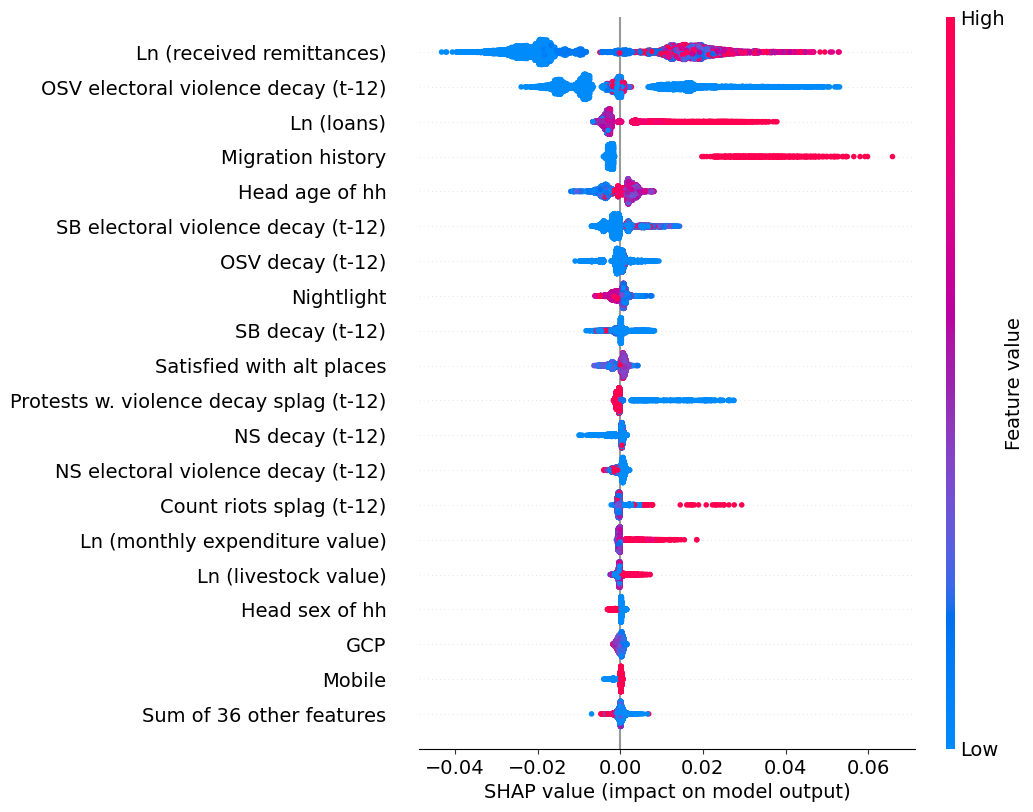

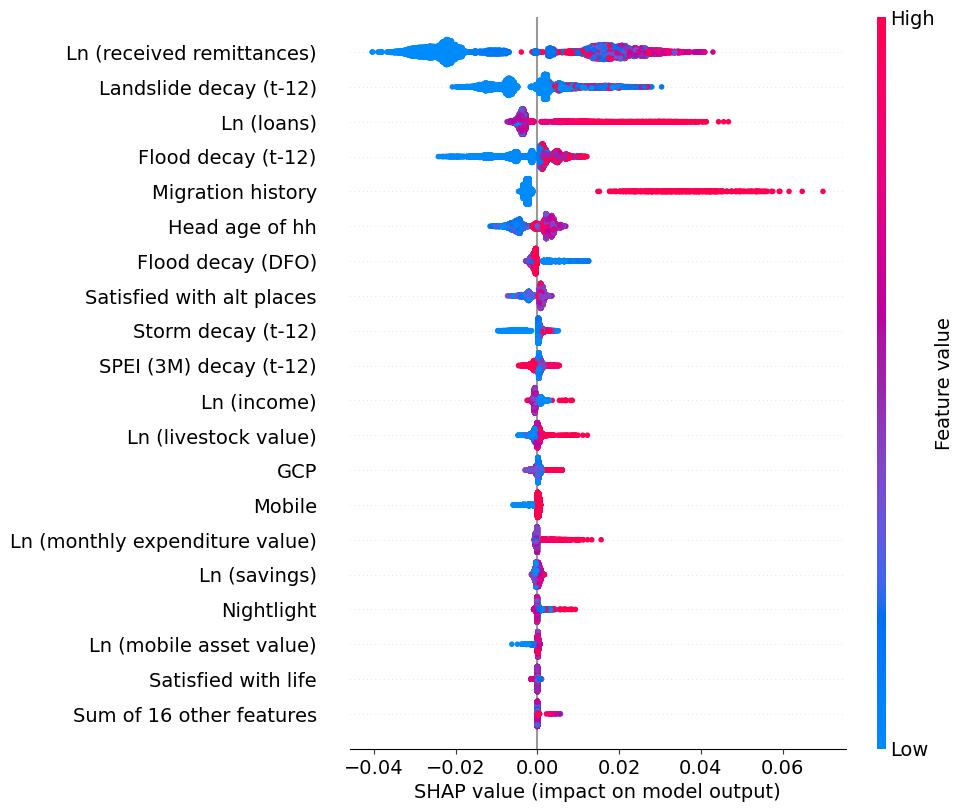

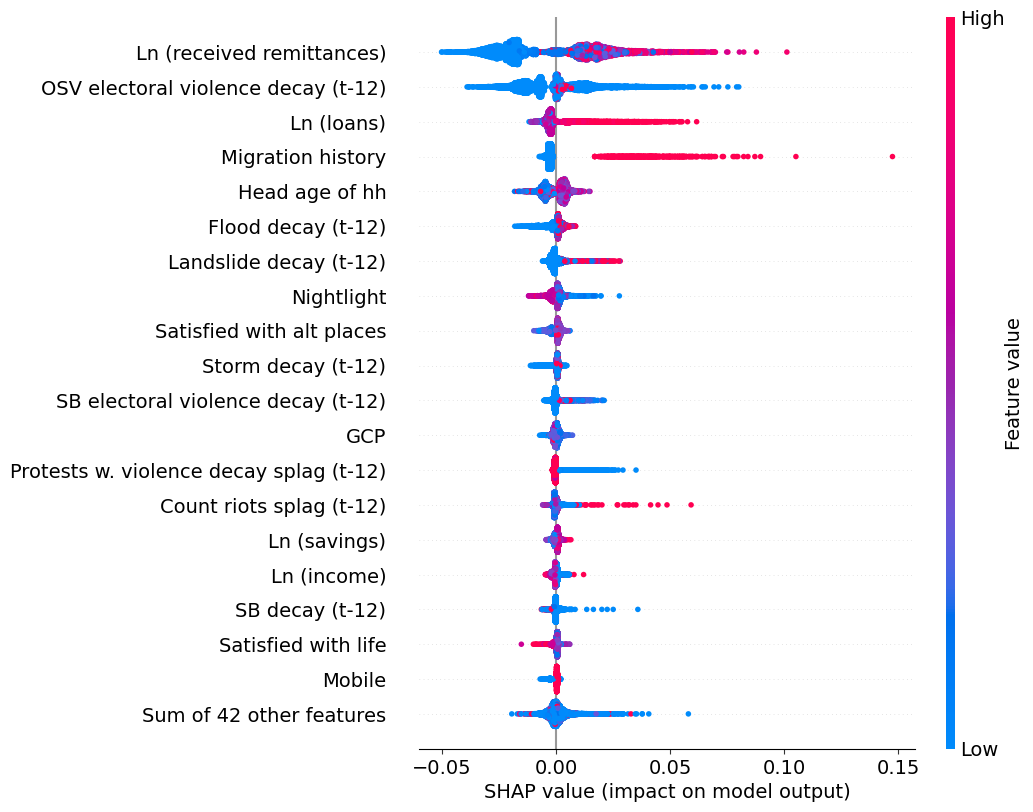

In [90]:
# FIGURE S16 SI:
fig_nr = 'SI_figs16'
analysis_models_shap = allmodels

bestfolds = [37,38,38,38]

for mod,bf in zip(analysis_models_shap,bestfolds):
    mname = mod['model_name']
    fig, ax = plt.subplots()
    shap.plots.beeswarm(
        shapvalsdict[mname][bf],
        max_display=20,show=False)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=14)
    ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
    plt.tick_params(axis='x', labelcolor='black')
    
    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=14)
    cb_ax.set_ylabel("Feature value", fontsize=14)
    
    # Re-label
    y_labels = [label.get_text() for label in plt.gca().get_yticklabels()]
    relabeled_strings = [name_dict.get(label, label) for label in y_labels]
    
    ax.set_yticklabels(relabeled_strings,size=14,color='black')
    
    if save_fig:
    
        plt.savefig(os.path.join(
            output_paths['shapvals'],
            f'{fig_nr}_shap_summaryplots_bestfold_{mname}_{esttype}_test_{run_shap}.png')
                    ,bbox_inches="tight", dpi=400,
                    transparent=False)
        plt.show(fig)
        plt.close()
    
        plt.show()
    
    else:
        plt.show

#### Heterogenous effects

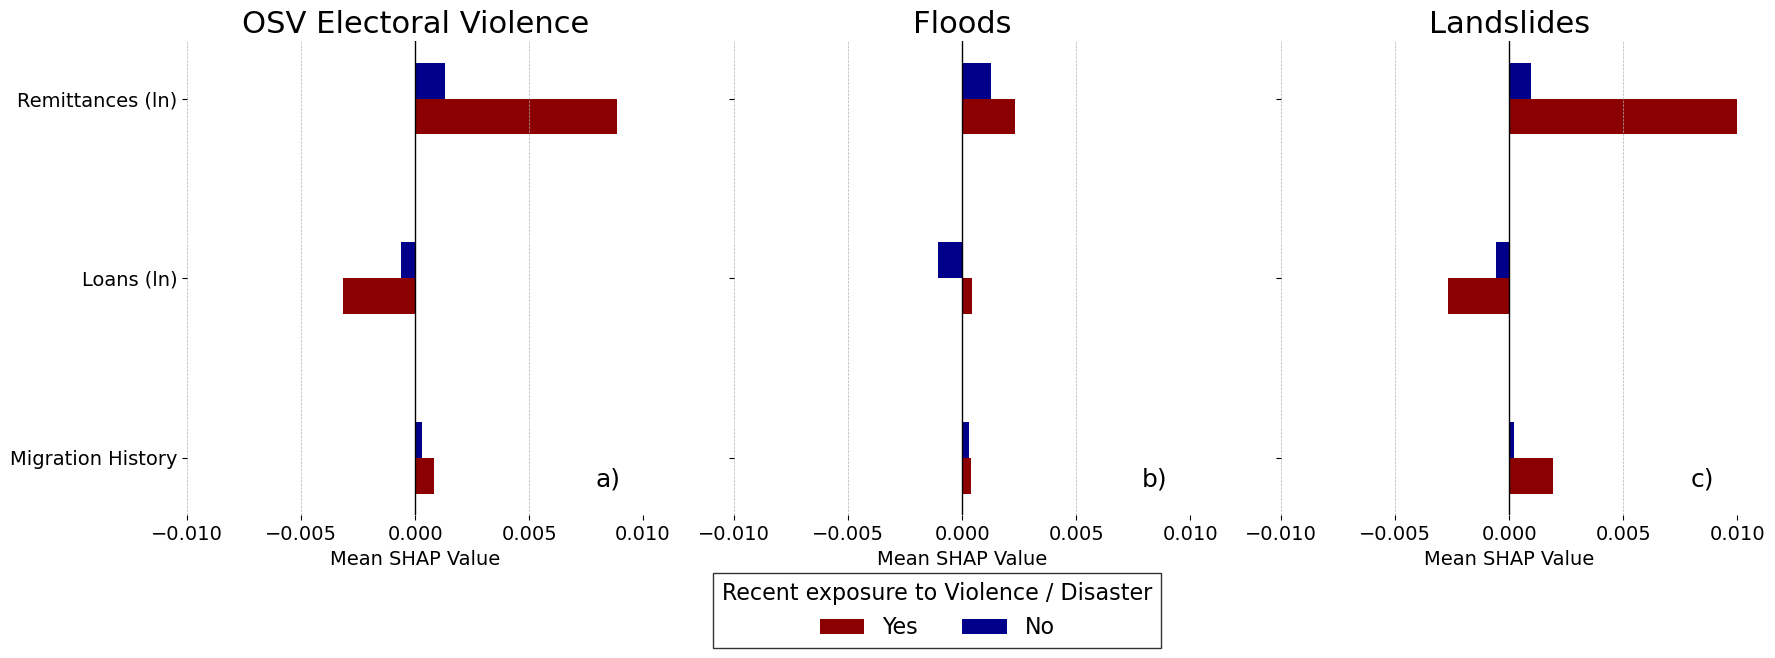

In [94]:
# MAIN FIGURE 5: 
esttype = 'xgb'
path_figure = os.path.join(
    output_paths['shapvals'],
    f'main_fig5_{esttype}_allfolds_train_{run_shap}.png'
)

# Define multiple variable sets and their corresponding names for each plot
plot_configs = [
    {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},
    {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},
    {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}
]

# Variables to be used across all the plots
select_vars = ['mig_history', 'ln_loans', 'ln_remittances_in_value']

# Mapping select_vars to more readable labels
var_labels = {
    'ln_remittances_in_value': 'Remittances (ln)',
    'ln_loans': 'Loans (ln)',
    'mig_history': 'Migration History',
}

# Define the labels for the textboxes
textbox_labels = ['a)', 'b)', 'c)']

do_net_effects = True

# Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Iterate over each plot configuration to generate the plots
for i, config in enumerate(plot_configs):
    select_var2 = config['select_var2']
    var2_pretty_name = config['pretty_name']
    var2_cutoffs = config['cutoffs']

    # --- collect shapdf across all folds ---
    all_shapdfs = []
    for f in list(range(n_reps_shap)):  
        shapdf_f = pd.DataFrame(
            shapvalsdict["district_violence_disaster"][f].values,
            columns=train_outdict["district_violence_disaster"][f].columns
        )
        shapdf_f[var2_pretty_name] = (
            pd.DataFrame(
                shapvalsdict["district_violence_disaster"][f].data,
                columns=train_outdict["district_violence_disaster"][f].columns
            )[select_var2].values
        )
        all_shapdfs.append(shapdf_f)

    shapdf = pd.concat(all_shapdfs, ignore_index=True)

    # Create an empty DataFrame to store results for each cutoff
    shap_means_df = pd.DataFrame()

    # Iterate over each cutoff and calculate SHAP values
    for cutoff in var2_cutoffs:
        if do_net_effects:
            shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
            shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
        else:
            shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
            shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)

        # Store the results in the DataFrame
        shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
        shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt

    # Offset the "No" group slightly to the left for visibility
    offset = 0.1

    # Plot the current variable cohort in the corresponding subplot
    bars1 = axes[i].barh(np.arange(len(select_vars)) - offset,
                         shap_means_df[f'{var2_pretty_name} >= {cutoff}'],
                         height=0.2, color='darkred', label='Yes')
    bars2 = axes[i].barh(np.arange(len(select_vars)) + offset,
                         shap_means_df[f'{var2_pretty_name} < {cutoff}'],
                         height=0.2, color='darkblue', label='No')

    # Add vertical line at zero and horizontal dashed lines for the grid
    axes[i].axvline(0, color='black', linewidth=1)
    axes[i].grid(axis='x', linestyle='--', linewidth=0.5)
    axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
    axes[i].set_xlabel('Mean SHAP Value', fontsize=14)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)

    # Rename the y-tick labels using var_labels
    axes[i].set_yticks(np.arange(len(select_vars)))
    axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)

    # Adjust x-ticks: fewer and larger
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].set_xlim([-0.01, 0.01])

    # Add text box in the lower right corner of each plot
    axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

# Add a single legend below the figure
fig.legend([bars1, bars2], ['Yes', 'No'], loc='lower center', ncol=2,
           fontsize=16, title_fontsize=16,
           title='Recent exposure to Violence / Disaster', fancybox=False,
           edgecolor='black', bbox_to_anchor=(0.5, -0.15))

# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.09)

if path_figure: 
    plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
    plt.show()
else:
    plt.show()

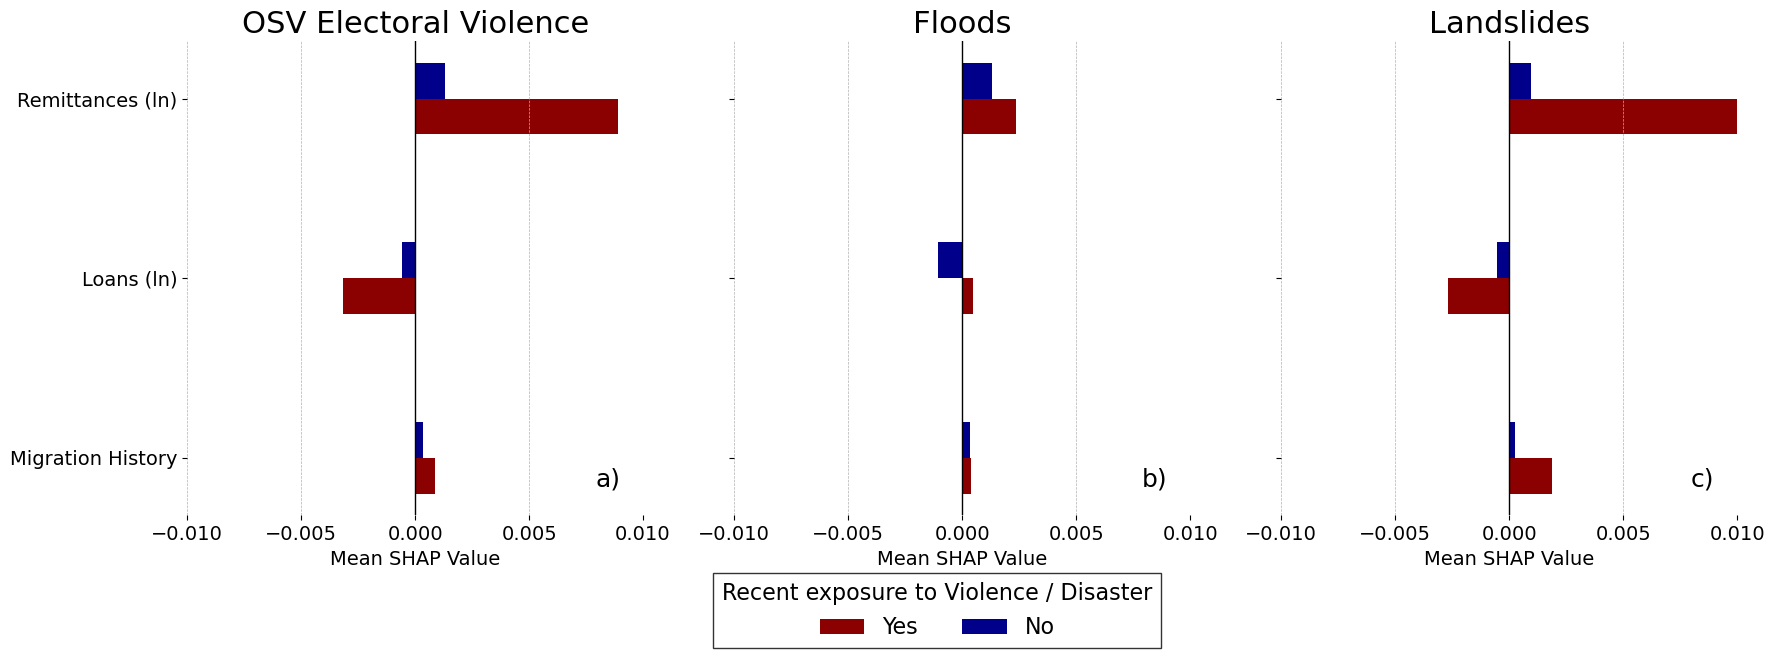

In [95]:
# FIGURE S10 SI:

esttype = 'xgb'
path_figure = os.path.join(
    output_paths['shapvals'],
    f'SI_figS10_{esttype}_bestfolds_train_{run_shap}.png'
)

# Define multiple variable sets and their corresponding names for each plot
plot_configs = [
    {'select_var2': 'deco_best_osv_ts_decay_6_tlag12', 'pretty_name': 'OSV Electoral Violence', 'cutoffs': [1]},
    {'select_var2': 'gdis_disastertype_flood_ts_decay_6_tlag12', 'pretty_name': 'Floods', 'cutoffs': [1]},
    {'select_var2': 'gdis_disastertype_landslide_ts_decay_6_tlag12', 'pretty_name': 'Landslides', 'cutoffs': [1]}
]

# Variables to be used across all the plots
select_vars = ['mig_history', 'ln_loans', 'ln_remittances_in_value']

# Mapping select_vars to more readable labels
var_labels = {
    'ln_remittances_in_value': 'Remittances (ln)',
    'ln_loans': 'Loans (ln)',
    'mig_history': 'Migration History',
}

# Define the labels for the textboxes
textbox_labels = ['a)', 'b)', 'c)']

do_net_effects = True

# Set up subplots: create 1 row and 4 columns, sharing y-axis for the same select_vars
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Iterate over each plot configuration to generate the plots
for i, config in enumerate(plot_configs):
    select_var2 = config['select_var2']
    var2_pretty_name = config['pretty_name']
    var2_cutoffs = config['cutoffs']

    # --- collect shapdf across all folds ---
    all_shapdfs = []
    for f in selected_folds_dict['district_violence_disaster']:  
        shapdf_f = pd.DataFrame(
            shapvalsdict_filtered["district_violence_disaster"][f].values,
            columns=train_outdict["district_violence_disaster"][f].columns
        )
        shapdf_f[var2_pretty_name] = (
            pd.DataFrame(
                shapvalsdict_filtered["district_violence_disaster"][f].data,
                columns=train_outdict["district_violence_disaster"][f].columns
            )[select_var2].values
        )
        all_shapdfs.append(shapdf_f)

    shapdf = pd.concat(all_shapdfs, ignore_index=True)

    # Create an empty DataFrame to store results for each cutoff
    shap_means_df = pd.DataFrame()

    # Iterate over each cutoff and calculate SHAP values
    for cutoff in var2_cutoffs:
        if do_net_effects:
            shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].mean(0)
            shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].mean(0)
        else:
            shap_mean_gte = shapdf[shapdf[var2_pretty_name] >= cutoff][select_vars].abs().mean(0)
            shap_mean_lt = shapdf[shapdf[var2_pretty_name] < cutoff][select_vars].abs().mean(0)

        # Store the results in the DataFrame
        shap_means_df[f'{var2_pretty_name} >= {cutoff}'] = shap_mean_gte
        shap_means_df[f'{var2_pretty_name} < {cutoff}'] = shap_mean_lt

    # Offset the "No" group slightly to the left for visibility
    offset = 0.1

    # Plot the current variable cohort in the corresponding subplot
    bars1 = axes[i].barh(np.arange(len(select_vars)) - offset,
                         shap_means_df[f'{var2_pretty_name} >= {cutoff}'],
                         height=0.2, color='darkred', label='Yes')
    bars2 = axes[i].barh(np.arange(len(select_vars)) + offset,
                         shap_means_df[f'{var2_pretty_name} < {cutoff}'],
                         height=0.2, color='darkblue', label='No')

    # Add vertical line at zero and horizontal dashed lines for the grid
    axes[i].axvline(0, color='black', linewidth=1)
    axes[i].grid(axis='x', linestyle='--', linewidth=0.5)
    axes[i].set_title(f'{var2_pretty_name}', fontsize=22)
    axes[i].set_xlabel('Mean SHAP Value', fontsize=14)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)

    # Rename the y-tick labels using var_labels
    axes[i].set_yticks(np.arange(len(select_vars)))
    axes[i].set_yticklabels([var_labels[var] for var in select_vars], fontsize=14)

    # Adjust x-ticks: fewer and larger
    axes[i].tick_params(axis='x', labelsize=14)
    axes[i].set_xlim([-0.01, 0.01])

    # Add text box in the lower right corner of each plot
    axes[i].text(0.95, 0.05, textbox_labels[i], fontsize=18, transform=axes[i].transAxes,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.5'))

# Add a single legend below the figure
fig.legend([bars1, bars2], ['Yes', 'No'], loc='lower center', ncol=2,
           fontsize=16, title_fontsize=16,
           title='Recent exposure to Violence / Disaster', fancybox=False,
           edgecolor='black', bbox_to_anchor=(0.5, -0.15))

# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.09)

if path_figure: 
    plt.savefig(path_figure, bbox_inches="tight", dpi=400, transparent=False)
    plt.show()
else:
    plt.show()

#### Interaction effects

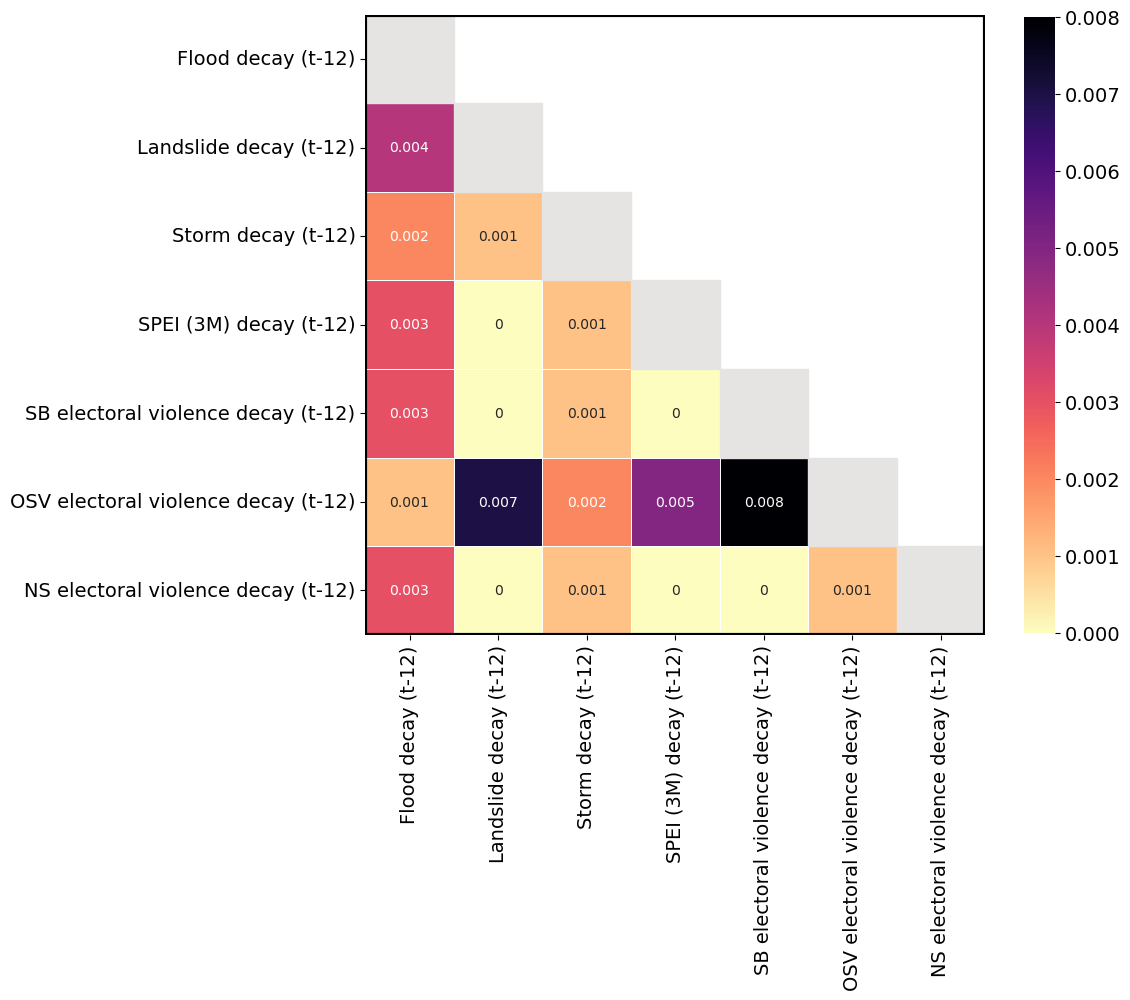

In [97]:
# FIGURE S11 SI:
model_inter = district_violence_disaster
list_inter = [
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'gdis_disastertype_landslide_ts_decay_6_tlag12',
    'gdis_disastertype_storm_ts_decay_6_tlag12',
    'spei_3_severe_ts_decay_6_tlag12',
    'deco_best_sb_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
    'deco_best_ns_ts_decay_6_tlag12',
             ]
########
saveintername = 'viodis'
path_out_save = os.path.join(output_paths['shapvals'],
                                 f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
interactdf,interactdf_raw = fun_plots.df_interactions_abs(
    shap_interactions_dict = shapinterdict,
    train_dict = train_outdict,
    model = model_inter,
    name_dict = name_dict,
    inter_vars = list_inter,
    selected_folds= list(range(n_reps_shap)),
    remove_zeros = False,
    agg_effect=False,
    save_fig=True, 
    path_out=path_out_save,
    colorpalette='magma_r'
)

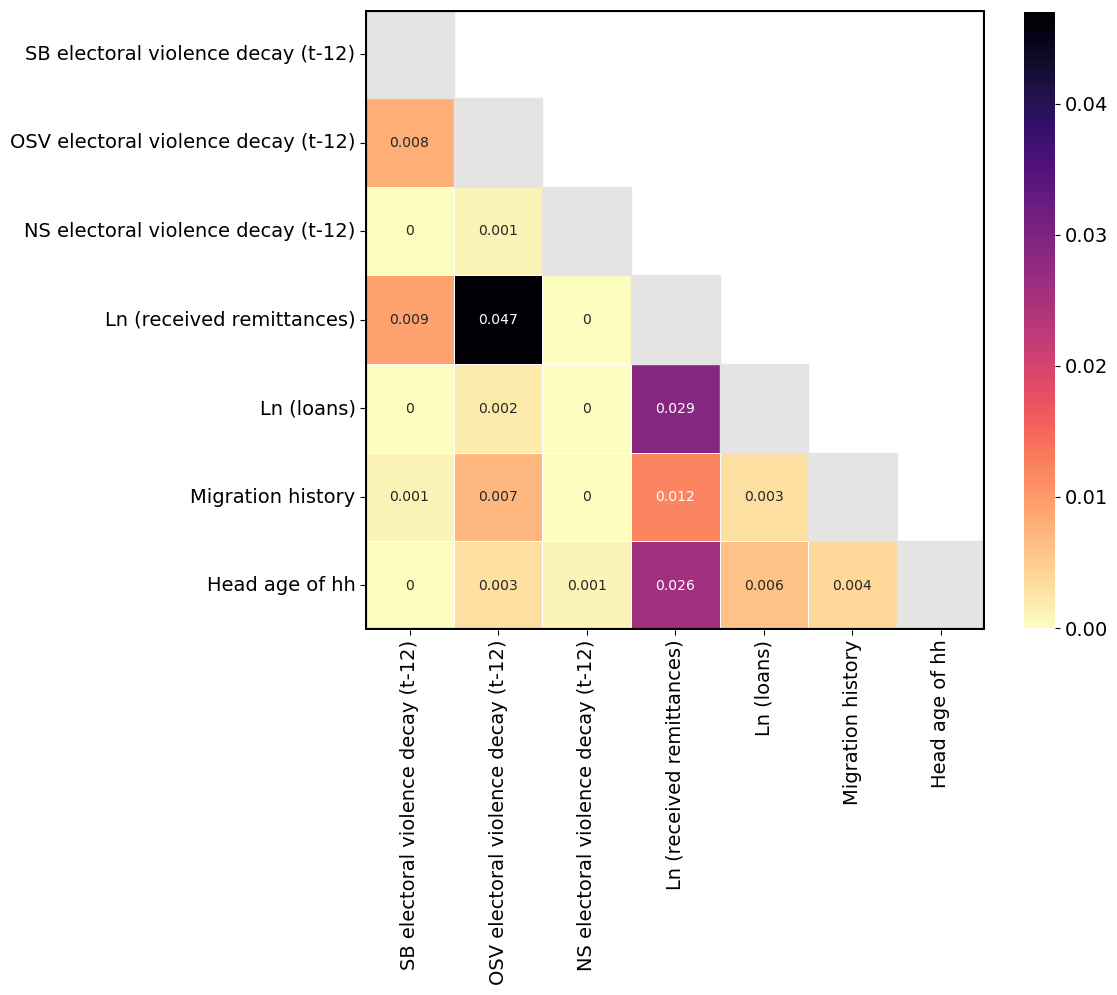

In [98]:
# FIGURE S11 SI:
model_inter = district_violence_disaster
list_inter = [
    'deco_best_sb_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
    'deco_best_ns_ts_decay_6_tlag12',
    'ln_remittances_in_value',
    'ln_loans',
    'mig_history',
    'head_age',
]

########
saveintername = 'viohh'
path_out_save = os.path.join(output_paths['shapvals'],
                                 f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
interactdf_viohh,interactdf_raw_viohh = fun_plots.df_interactions_abs(
    shap_interactions_dict = shapinterdict,
    train_dict = train_outdict,
    model = model_inter,
    name_dict = name_dict,
    inter_vars = list_inter,
    selected_folds= list(range(n_reps_shap)),
    remove_zeros = False,
    agg_effect=False,
    save_fig=True, 
    path_out=path_out_save,
    colorpalette='magma_r'
)

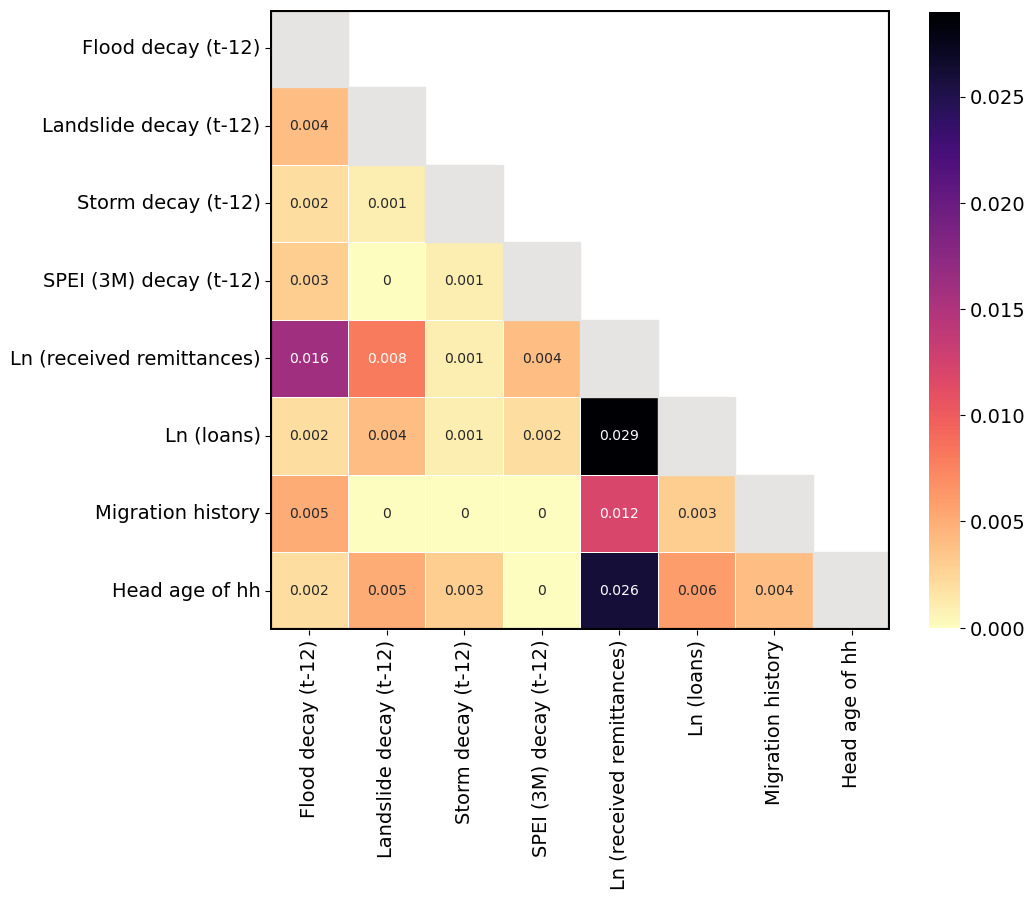

In [99]:
# FIGURE S11 SI:
model_inter = district_violence_disaster
list_inter = [
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'gdis_disastertype_landslide_ts_decay_6_tlag12',
    'gdis_disastertype_storm_ts_decay_6_tlag12',
    'spei_3_severe_ts_decay_6_tlag12',
    'ln_remittances_in_value',
    'ln_loans',
    'mig_history',
    'head_age',
]

########
saveintername = 'dishh'
path_out_save = os.path.join(output_paths['shapvals'],
                                 f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
interactdf_dishh,interactdf_raw_dishh = fun_plots.df_interactions_abs(
    shap_interactions_dict = shapinterdict,
    train_dict = train_outdict,
    model = model_inter,
    name_dict = name_dict,
    inter_vars = list_inter,
    selected_folds= list(range(n_reps_shap)),
    remove_zeros = False,
    agg_effect=False,
    save_fig=True, 
    path_out=path_out_save,
    colorpalette='magma_r'
)

/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/2753109009.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)


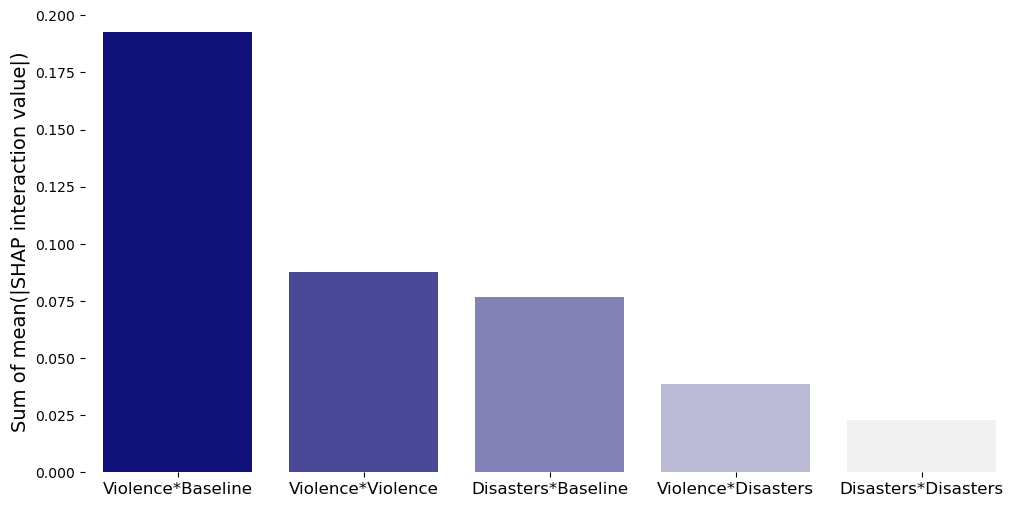

In [101]:
# MAIN FIGURE 6: 
save_fig = True
path_out_save = os.path.join(output_paths['shapvals'],
                                 f'main_fig6_shapinteraction_barplot.png')


# Replace diagonals with 0
np.fill_diagonal(interactdf_raw.values, 0)

# Compute the sums for the specified groups
interaction_sums = {
    'Violence*Disasters': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_disaster_agg].sum().sum(),
    'Violence*Baseline': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_baseline_district].sum().sum(),
    'Disasters*Baseline': interactdf_raw.loc[feat_disaster_agg, feat_baseline_district].sum().sum(),
    'Violence*Violence': interactdf_raw.loc[feat_elect_vio_agg+feat_violence_agg, feat_elect_vio_agg+feat_violence_agg].sum().sum(),
    'Disasters*Disasters': interactdf_raw.loc[feat_disaster_agg, feat_disaster_agg].sum().sum()
}

# Convert the interaction sums to a pandas DataFrame for easy plotting
interaction_df = pd.DataFrame(list(interaction_sums.items()), columns=['Group', 'Sum'])

# Sort the values by the 'Sum' column
interaction_df = interaction_df.sort_values(by='Sum', ascending=False)

# Create a custom color palette from dark blue to lighter blue
custom_palette = sns.light_palette("darkblue", reverse=True, n_colors=len(interaction_df))

# Create a barplot with sorted values
fig, ax = plt.subplots(figsize=(12, 6))  
sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)

# Add labels and title
plt.ylabel('Sum of mean(|SHAP interaction value|)', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)

# Customize the axes and spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Display the plot
if save_fig:

    plt.savefig(path_out_save,bbox_inches="tight", dpi=400,
                    transparent=False)

    plt.show(fig)
    plt.close()
else: 
    plt.show(fig)

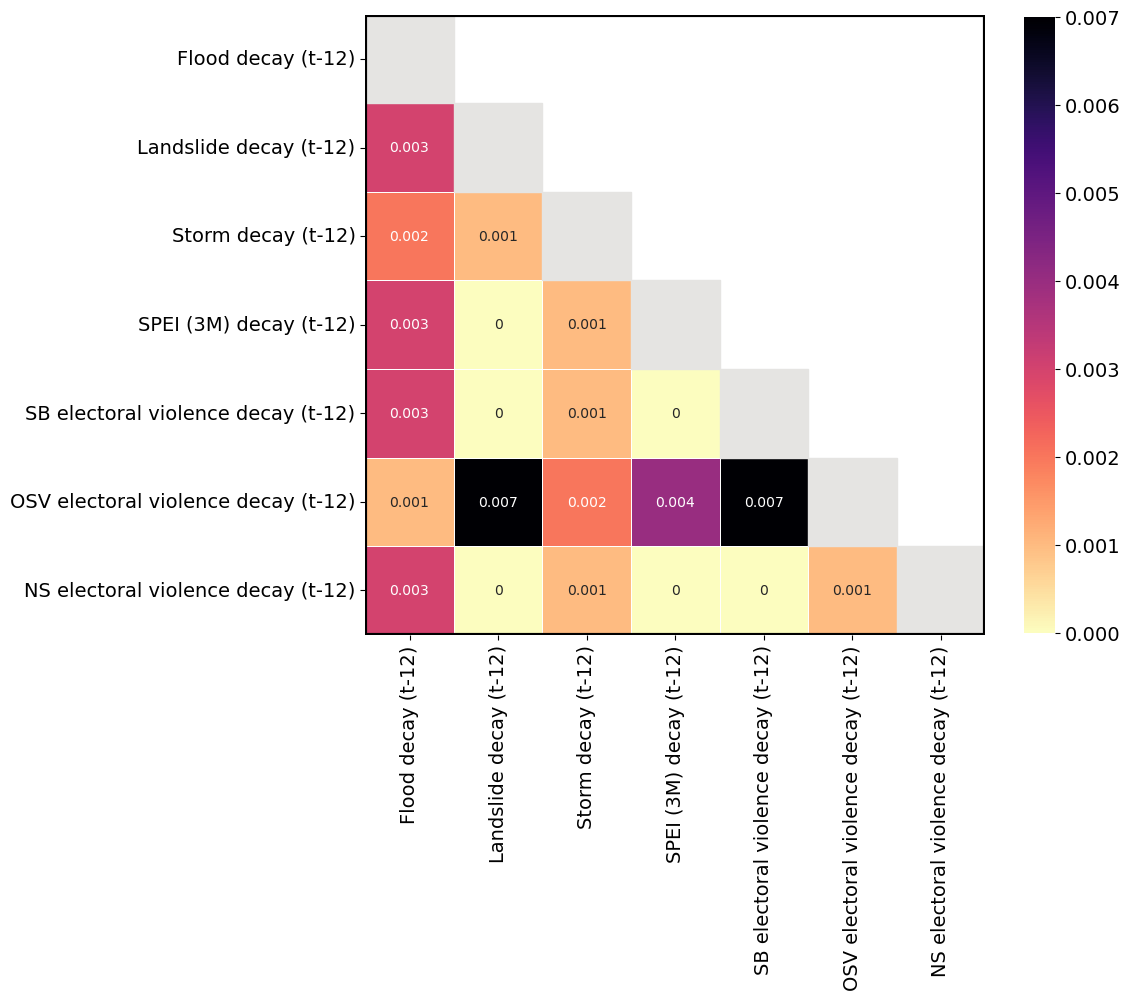

In [104]:
# For robustness, look only at best-performing folds
model_inter = district_violence_disaster
list_inter = [
    'gdis_disastertype_flood_ts_decay_6_tlag12',
    'gdis_disastertype_landslide_ts_decay_6_tlag12',
    'gdis_disastertype_storm_ts_decay_6_tlag12',
    'spei_3_severe_ts_decay_6_tlag12',
    'deco_best_sb_ts_decay_6_tlag12',
    'deco_best_osv_ts_decay_6_tlag12',
    'deco_best_ns_ts_decay_6_tlag12',
             ]
########
saveintername = 'viodis'
#path_out_save = os.path.join(output_paths['shapvals'],
                                 #f'SI_figs11_shapinteraction_heatmap_absmean_{saveintername}.png')
interactdf_rob,interactdf_raw_rob = fun_plots.df_interactions_abs(
    shap_interactions_dict = shapinterdict,
    train_dict = train_outdict,
    model = model_inter,
    name_dict = name_dict,
    inter_vars = list_inter,
    selected_folds= selected_folds_dict['district_violence_disaster'],
    remove_zeros = False,
    agg_effect=False,
    save_fig=False, 
    #path_out=path_out_save,
    colorpalette='magma_r'
)

/var/folders/4_/5tykrfk16l3_j0dx711k_cq00000gp/T/ipykernel_70687/3181035752.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)


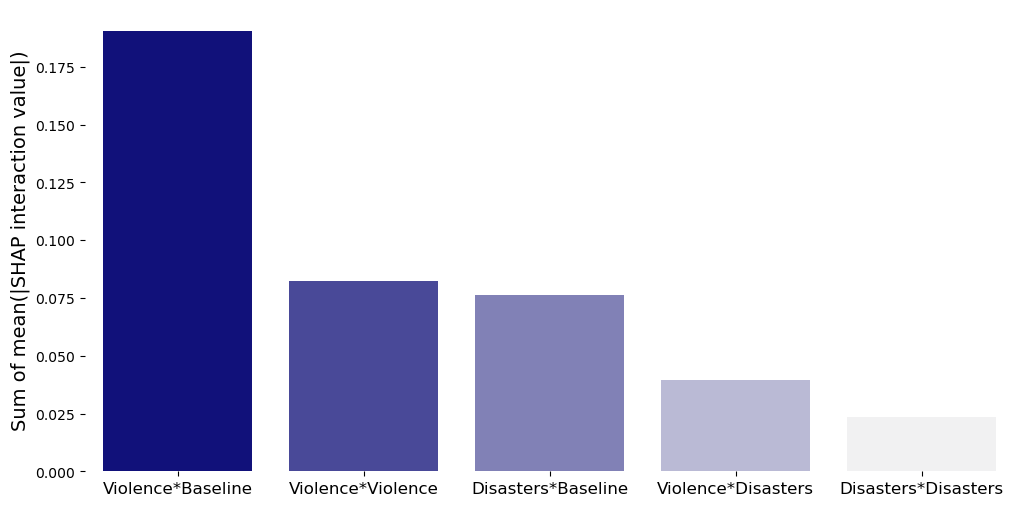

In [106]:
# FIGURE S13 SI:
save_fig = True
path_out_save = os.path.join(output_paths['shapvals'],
                                 f'SI_figs13_shapinteraction_barplot_f.png')


# Replace diagonals with 0
np.fill_diagonal(interactdf_raw_rob.values, 0)

# Compute the sums for the specified groups
interaction_sums = {
    'Violence*Disasters': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_disaster_agg].sum().sum(),
    'Violence*Baseline': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_baseline_district].sum().sum(),
    'Disasters*Baseline': interactdf_raw_rob.loc[feat_disaster_agg, feat_baseline_district].sum().sum(),
    'Violence*Violence': interactdf_raw_rob.loc[feat_elect_vio_agg+feat_violence_agg, feat_elect_vio_agg+feat_violence_agg].sum().sum(),
    'Disasters*Disasters': interactdf_raw_rob.loc[feat_disaster_agg, feat_disaster_agg].sum().sum()
}

# Convert the interaction sums to a pandas DataFrame for easy plotting
interaction_df = pd.DataFrame(list(interaction_sums.items()), columns=['Group', 'Sum'])

# Sort the values by the 'Sum' column
interaction_df = interaction_df.sort_values(by='Sum', ascending=False)

# Create a custom color palette from dark blue to lighter blue
custom_palette = sns.light_palette("darkblue", reverse=True, n_colors=len(interaction_df))

# Create a barplot with sorted values
fig, ax = plt.subplots(figsize=(12, 6))  
sns.barplot(x='Group', y='Sum', data=interaction_df, palette=custom_palette, ax=ax)

# Add labels and title
plt.ylabel('Sum of mean(|SHAP interaction value|)', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)

# Customize the axes and spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Display the plot
if save_fig:

    plt.savefig(path_out_save,bbox_inches="tight", dpi=400,
                    transparent=False)

    plt.show(fig)
    plt.close()
else: 
    plt.show(fig)